# Chapter 3: Model Comparison and Optimisation

Comparison of machine learning models and optimisation approaches for dairy concentrate allocation.

## Models Compared
- Random Forest
- Neural Networks (Adam, SGD)
- LSTM
- Gaussian Process

## Optimisation Approaches
- Scipy (trust-constr)
- OR-Tools

## Data Requirements
- Training/test data CSVs in `data/` directory
- Pre-trained model files

## Repository
https://github.com/Stansfash/thesis-python_codes/new/main/chapter-3-data-driven-optimisation


## Import all Libraries

In [38]:
# !pip install gpytorch
# !pip install PyLBFGS
# !pip install regex
# !pip install tqdm
# !pip install -U scikit-learn
# !pip install properscoring

In [1]:
#Import all libraries
#Import all libraries
%set_env CUDA_VISIBLE_DEVICES=0
import random
import warnings
import math
import torch
import gpytorch
# import lbfgs
import sys
import os
import time
import logging
import urllib.request
import os.path
import seaborn as sns
import gpflow
import tensorflow as tf
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import gc
import tqdm
import sklearn
import copy
import properscoring as ps


# GPyTorch Imports
import gpytorch
from gpytorch.models import ExactGP, IndependentModelList, ApproximateGP, GP
from gpytorch.means import ConstantMean, MultitaskMean, LinearMean
from gpytorch.kernels import ScaleKernel, MultitaskKernel
from gpytorch.kernels import RBFKernel,  ScaleKernel, ProductKernel
from gpytorch.likelihoods import GaussianLikelihood, LikelihoodList, MultitaskGaussianLikelihood
from gpytorch.mlls import SumMarginalLogLikelihood, ExactMarginalLogLikelihood, VariationalELBO, AddedLossTerm
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

# General libraries
from matplotlib import pyplot as plt
from random import randrange,sample,randint
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy import linalg
from scipy.io import loadmat
from time import time
from math import floor  
from torch import nn, optim
from torch.autograd import Variable
from math import exp, pi
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,LabelEncoder,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, learning_curve
from sklearn.pipeline import make_pipeline
# pip install -U scikit-learn
# Used to split data into training and test data
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import(RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)


#Sklearn Libraries

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression,mutual_info_classif,SelectFromModel,RFE
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance
import xgboost
from xgboost import XGBRegressor
import lightgbm as lgb

## ANN LIBRARY
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Multiple math functions
from tensorflow import math
from tensorflow.keras.utils import plot_model
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# added these lines to include PyTorch-LBFGS
import sys
#sys.path.append(r"data/file.csv")
#sys.path.append("data/file.csv")
# sys.path.append("data/file.csv")
# from LBFGS import LBFGS, FullBatchLBFGS

#Added Torch Libraries
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.transforms import SigmoidTransform, PowerTransform
from torch.distributions.normal import Normal

from drs import drs

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2
    
plt.style.use('ggplot')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

## Data Splitting

In [6]:
data= pd.read_csv("data/")
#Dataset is now stored in a Pandas Dataframe
# data = data.drop(["Unnamed: 0"], axis=1) # Features
data['id'] = 'C' + data['id'].astype(str)
object_columns = ['sampling_year', 'sampling_day', 'lact', 'calving_year','calving_day'] # Creates list of all column headers
data[object_columns] = data[object_columns].astype("object")
data['smp_date'] = data['smp_date'].astype('datetime64[ns]')
data["Response"] = data["my"] / data["conc"]
print(data.columns)
pd.options.display.max_rows=100
print(data.info())
print(data.isnull().sum())
data.head(10)
Full_dataframe = data.copy(deep=True)

Index(['smp_date', 'smp_seas', 'sampling_year', 'sampling_month',
       'sampling_day', 'id', 'Breed', 'treatment', 'lact', 'calv_date',
       'calving_year', 'calving_month', 'calving_day', 'calv_seas', 'dim',
       'sol', 'lw', 'conc', 'my', 'Response'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32504 entries, 0 to 32503
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   smp_date        32504 non-null  datetime64[ns]
 1   smp_seas        32504 non-null  object        
 2   sampling_year   32504 non-null  object        
 3   sampling_month  32504 non-null  object        
 4   sampling_day    32504 non-null  object        
 5   id              32504 non-null  object        
 6   Breed           32504 non-null  object        
 7   treatment       32504 non-null  object        
 8   lact            32504 non-null  object        
 9   calv_date       32504 non-null  

In [4]:
# Delete non-numeric data (Changes don't effect the original)
inputs=Full_dataframe.drop('my', axis = 1)
target=Full_dataframe['my']
df= pd.concat([inputs, target], axis = 1)

In [6]:
X=df.drop('my', axis = 1)
Y=df['my']
# print(X)
#print(Y)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2023)

In [8]:
df_train = pd.concat([X_train, Y_train], axis = 1)
df_test = pd.concat([X_test, Y_test], axis = 1)
#Predictors
X_train= pd.DataFrame(X_train)
X_test= pd.DataFrame(X_test)
new_arrangement = ["lact", "dim", "lw", "conc"]
train_x = X_train[new_arrangement]
test_x = X_test[new_arrangement]

In [9]:
dloc = "data/"

In [10]:
df.to_csv("data/", index=False)
df_train.to_csv("data/", index=False)
df_test.to_csv("data/", index=False)
train_x.to_csv("data/", index=False)
test_x.to_csv("data/", index=False)
Y_train.to_csv("data/", index=False)
Y_test.to_csv("data/", index=False)

## Load Splitted Datasets into pandas

In [11]:
import csv
Full_dataframe_130_cows = pd.read_csv("data/")
df_train_130 = pd.read_csv("data/")
df_test_130 = pd.read_csv("data/")
X_train = pd.read_csv("data/")
X_test = pd.read_csv("data/")
y_train = pd.read_csv("data/")
y_test = pd.read_csv("data/")

### Data Preprocessing for Prediction

In [12]:
#Dataset is now stored in a Pandas Dataframe
#Adjusting Features data types
pd.options.display.max_rows=100
object_columns = ['sampling_year', 'sampling_day', 'lact', 'calving_year','calving_day'] # Creates list of all column headers
Full_dataframe_130_cows[object_columns] = Full_dataframe_130_cows[object_columns].astype("object")
Full_dataframe_130_cows['smp_date'] = Full_dataframe_130_cows['smp_date'].astype('datetime64[ns]')
df = Full_dataframe_130_cows.copy(deep=True)
print(Full_dataframe_130_cows.columns)
print(df.info())
print(X_train.info(), "\n")
print(X_test.info(), "\n")
print(y_train.info(), "\n")
print(y_test.info())

Index(['smp_date', 'smp_seas', 'sampling_year', 'sampling_month',
       'sampling_day', 'id', 'Breed', 'treatment', 'lact', 'calv_date',
       'calving_year', 'calving_month', 'calving_day', 'calv_seas', 'dim',
       'sol', 'lw', 'conc', 'Response', 'my'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32504 entries, 0 to 32503
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   smp_date        32504 non-null  datetime64[ns]
 1   smp_seas        32504 non-null  object        
 2   sampling_year   32504 non-null  object        
 3   sampling_month  32504 non-null  object        
 4   sampling_day    32504 non-null  object        
 5   id              32504 non-null  object        
 6   Breed           32504 non-null  object        
 7   treatment       32504 non-null  object        
 8   lact            32504 non-null  object        
 9   calv_date       32504 non-null  

In [13]:
new_arrangement = ["lact","dim", "lw", "conc", "my"]
df1 = df[new_arrangement]
## drop dependent feature from dataset
trainX_all = df1.drop(['my'],axis=1)
## Capture the dependent feature
trainY_all = df1[['my']]

#Output and input variables ravelling
# Create a list of dataframes
dataframes = [trainY_all, y_train, y_test, trainX_all, X_train, X_test]

# Create a list of original names
original_names = ['trainY_all', 'y_train', 'y_test', 'trainX_all', 'X_train', 'X_test']

# Iterate over each dataframe, apply values.ravel() or values based on the index, and assign to original names
for i, (name, df) in enumerate(zip(original_names, dataframes)):
    if i < 3:
        modified_df = df.values.ravel()
    else:
        modified_df = df.values
    exec(f"{name} = modified_df")

# # Access the modified dataframes by their original names
# print(trainY_all.shape)
# print(y_train.shape)
# print(y_test.shape)
# print(trainX_all.shape)
# print(X_train.shape)
# print(X_test.shape)

### Defining Evaluation Metrics

In [14]:
#DEFINE EVALUATION MATRICS

# Cross val score is whole data score, not the train test splitted data score with kfold=10
def cross_val(model):
    #This is whole set, not the splitted
    pred = cross_val_score(model, trainX_all, trainY_all, cv=10)
    return format(round(pred.mean(),4),'.4f')

# Here evaluation matrics for splitted test data
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    rmsle = np.sqrt(metrics.mean_squared_log_error(true, predicted)) 
    # This rmsle is the matrics defined in kaggle for this casestudy
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('RMSLE:', rmsle)
    print('R2 Square', r2_square)
    print('__________________________________')
    

# Here evaluation matrics for splitted test data
def evaluate(true, predicted):
    mae = round(metrics.mean_absolute_error(true, predicted),4)
    mse = round(metrics.mean_squared_error(true, predicted),4)
    rmse = round(np.sqrt(metrics.mean_squared_error(true, predicted)),4)
    rmsle = round(np.sqrt(metrics.mean_squared_log_error(true, predicted)) ,4)
    r2_square =metrics.r2_score(true, predicted)
    return format(mae,'.4f'), format(mse,'.4f'), format(rmse,'.4f'), format(rmsle,'.4f') ,format(r2_square,'.4f')

In [15]:
#Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
pred = lin_reg.predict(X_test)
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = []
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', "Cross Validation"])
results_df

Test set evaluation:
_____________________________________
MAE: 3.802659202153704
MSE: 24.34519623128028
RMSE: 4.934085146334656
RMSLE: 0.1892431986271931
R2 Square 0.4503390330084618
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.811385784724141
MSE: 24.46455800314954
RMSE: 4.946165990254426
RMSLE: 0.1887667567824523
R2 Square 0.4235856630404017
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0  Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   

  Cross Validation  
0           0.1571

In [16]:
# Ridge Regression

ridge_model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_test)

test_pred = ridge_model.predict(X_test)
train_pred = ridge_model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE','RMSLE', 'R2 Square', "Cross Validation"])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.803291775048774
MSE: 24.346965741544146
RMSE: 4.934264458006294
RMSLE: 0.1892469015160503
R2 Square 0.4502990813599519
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.811597832177618
MSE: 24.465466639639086
RMSE: 4.946257842009359
RMSLE: 0.18877100658175514
R2 Square 0.42356425447460666
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0  Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0   Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   

  Cross Validation  
0           0.1571  
0           0.1571

In [17]:
# Lasso Regression

#In case scalarization is not done, we can use this pipeline method with RobustScaler() as 1st one before Laso regression

#model = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

lasso_model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)

lasso_model.fit(X_train, y_train)

test_pred = lasso_model.predict(X_test)
train_pred = lasso_model.predict(X_train)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE','R2 Square', "Cross Validation"])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 4.087610681843469
MSE: 27.90355154525154
RMSE: 5.282381238158747
RMSLE: 0.20092682779098373
R2 Square 0.3699991990553526
__________________________________
Train set evaluation:
_____________________________________
MAE: 4.08842880194694
MSE: 27.646508661371165
RMSE: 5.257994737670547
RMSLE: 0.1992606895761994
R2 Square 0.3486150881107074
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0  Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0   Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0   Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232

In [18]:
# ElasticNet Regression

# To handle Outlier, we can use RobustScaler() in pipeline
elastic_net_model = make_pipeline(RobustScaler(), 
                      ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
                     )
                      
                      
#model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
elastic_net_model.fit(X_train, y_train)

test_pred = elastic_net_model.predict(X_test)
train_pred = elastic_net_model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE','R2 Square', "Cross Validation"])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.825635420058344
MSE: 24.507391697578594
RMSE: 4.9504940862078195
RMSLE: 0.18987776263461187
R2 Square 0.4466770162393128
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.831265574973474
MSE: 24.570568972354653
RMSE: 4.956870885180958
RMSLE: 0.18922623220858834
R2 Square 0.42108791742337714
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0       Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0        Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0        Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0  Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438

In [19]:
#Light Regressor

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgb.fit(X_train, y_train)

test_pred = model_lgb.predict(X_test)
train_pred = model_lgb.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["LightGBM", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0       Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0        Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0        Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0  Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0

In [20]:
#PLS Regression
from sklearn.cross_decomposition import PLSRegression
model_pls = PLSRegression(n_components=4)
model_pls.fit(X_train,y_train)

test_pred = model_pls.predict(X_test)
train_pred = model_pls.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["PLS Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.802659202153706
MSE: 24.34519623128028
RMSE: 4.934085146334656
RMSLE: 0.18924319862719316
R2 Square 0.4503390330084618
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.811385784724143
MSE: 24.46455800314954
RMSE: 4.946165990254426
RMSLE: 0.18876675678245233
R2 Square 0.4235856630404017
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0       Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0        Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0        Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0  Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0          PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0

In [21]:
#RANSACRegressor - Robust Regression

#ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

Robust_model = make_pipeline(RobustScaler(), RANSACRegressor(estimator=LinearRegression(), max_trials=100))

#model = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
Robust_model.fit(X_train, y_train)

test_pred = Robust_model.predict(X_test)
train_pred = Robust_model.predict(X_train)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , 0  ]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE','RMSLE', 'R2 Square', "Cross Validation"])

results_df = pd.concat([results_df, results_df_2])
results_df

# Here we commented the appned, because values are huge and making final table results_df very big

Test set evaluation:
_____________________________________
MAE: 4.325167251407611
MSE: 30.944622437400803
RMSE: 5.562789087984624
RMSLE: 0.20214541234889694
R2 Square 0.3013385092260852
__________________________________
Train set evaluation:
_____________________________________
MAE: 4.254766769948814
MSE: 30.235760440549686
RMSE: 5.498705342219174
RMSLE: 0.2003028933445804
R2 Square 0.28760920983878
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0       Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0        Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0        Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0  Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0          PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0       Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0

In [22]:
# PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.6300013612645436
MSE: 22.191034101492583
RMSE: 4.710736046680241
RMSLE: 0.18171357173807223
R2 Square 0.49897527434605693
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.6560382410939036
MSE: 22.512462325072576
RMSE: 4.744729952807913
RMSLE: 0.18182552443074174
R2 Square 0.46957937916703574
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0       Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0        Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0        Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0  Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0          PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0       Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0   Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0

In [23]:
# Gradient Boosting Regressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(X_train, y_train)

test_pred = GBoost.predict(X_test)
train_pred = GBoost.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Gradient Boosting Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.241147225592347
MSE: 18.43996497436748
RMSE: 4.29417803244899
RMSLE: 0.16736528380697
R2 Square 0.5836661621943353
__________________________________
Train set evaluation:
_____________________________________
MAE: 2.9951569672073544
MSE: 16.059988933995232
RMSE: 4.007491601238264
RMSLE: 0.15623037468376572
R2 Square 0.6216073933657178
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0

In [24]:
#XGB Regressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_xgb.fit(X_train, y_train)

test_pred = model_xgb.predict(X_test)
train_pred = model_xgb.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["XGBoost", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE','RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.625670066567095
MSE: 21.99033808082415
RMSE: 4.689385682669335
RMSLE: 0.18129009220053274
R2 Square 0.5035065489245805
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.5826992925541155
MSE: 21.578080609100898
RMSE: 4.645221265892605
RMSLE: 0.1783577155112081
R2 Square 0.4915945333835823
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [25]:
#DesicionTree
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(random_state=100)
model_dt.fit(X_train,y_train)

test_pred = model_dt.predict(X_test)
train_pred = model_dt.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["DecisionTree", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.713510741937138
MSE: 27.876878941701282
RMSE: 5.279855958423608
RMSLE: 0.20656002388134553
R2 Square 0.3706014077588823
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.29177851273571
MSE: 1.184231178453768
RMSE: 1.0882238641262045
RMSLE: 0.042913100364387065
R2 Square 0.9720980927001651
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [26]:
##KNN 
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

model_grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, refit=True, verbose=1)
model_grid_knn.fit(X_train, y_train)

test_pred = model_grid_knn.predict(X_test)
train_pred = model_grid_knn.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["KNN Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Test set evaluation:
_____________________________________
MAE: 3.8857283494846944
MSE: 25.116976372865714
RMSE: 5.011683985734307
RMSLE: 0.1866368629174831
R2 Square 0.4329139354697674
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.415231319463138
MSE: 19.57666213898396
RMSE: 4.424552196435698
RMSLE: 0.16584373773229114
R2 Square 0.5387503536637863
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

### Separating Categorical and Numerical Columns:

In [2]:
import csv
Full_dataframe_130_cows = pd.read_csv("data/")
df_train_130 = pd.read_csv("data/")
df_test_130 = pd.read_csv("data/")
X_train = pd.read_csv("data/")
X_test = pd.read_csv("data/")
y_train = pd.read_csv("data/")
y_test = pd.read_csv("data/")

In [3]:
y_train.shape

(26003, 1)

In [18]:
# import pandas as pd

# # Add 'id' column from df1 to df2 as the first column
# X_train.insert(0, 'id', df_train_130['id'])
# # Remove 'C' from the 'id' column in df2
# X_train['id'] = X_train['id'].str.replace('C', '')
# # Convert the 'id' column to object type
# X_train['id'] = X_train['id'].astype('object')

# # Add 'id' column from df1 to df2 as the first column
# X_test.insert(0, 'id', df_test_130['id'])
# # Remove 'C' from the 'id' column in df2
# X_test['id'] = X_test['id'].str.replace('C', '')
# # Convert the 'id' column to object type
# X_test['id'] = X_test['id'].astype('object')
# X_test
# X_train.to_csv("data/", index=False)
# X_test.to_csv("data/", index=False)

### Grid Search

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Define custom scoring functions for MSE and RMSE
def neg_mse(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Assuming X_train, X_test, y_train, y_test are already defined

# Preprocessing steps
X_train["lact"] = X_train["lact"].astype("object")
X_test["lact"] = X_test["lact"].astype("object")


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the pipeline with preprocessing and the random forest model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor())])

# Define scoring metrics
scoring = {
    'Neg_MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MSE': make_scorer(mean_squared_error, greater_is_better=False), # Custom MSE scorer
    'RMSE': make_scorer(rmse, greater_is_better=False) # Custom RMSE scorer
}



# Define the parameters for grid search
param_grid = {
    'rf__n_estimators': [100,150,200,250,300,350,400,450,500],  # Define different numbers of trees to try
    # You can add more hyperparameters to optimize here
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='Neg_MSE')
grid_search.fit(X_train, y_train)

# Access the results of each estimator count
results_df_grid = pd.DataFrame(grid_search.cv_results_)

# Save the results to a CSV file
results_df_grid.to_csv("grid_search_results.csv", index=False)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Fit the model with the best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluate the model
train_score = best_rf_model.score(X_train, y_train)
test_score = best_rf_model.score(X_test, y_test)

print("Train Score (R2):", train_score)
print("Test Score (R2):", test_score)

# Calculate and print additional evaluation metrics
y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Test):", mse_test)
print("Root Mean Squared Error (Train):", rmse_train)
print("Root Mean Squared Error (Test):", rmse_test)
results_df_grid

Best Parameters: {'rf__n_estimators': 350}
Train Score (R2): 0.9237131720821072
Test Score (R2): 0.6009057175598029
Mean Squared Error (Train): 3.237815936914122
Mean Squared Error (Test): 17.676402735976282
Root Mean Squared Error (Train): 1.7993932135345299
Root Mean Squared Error (Test): 4.204331425562962


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      10.718258      0.830623         0.168298        0.024960   
1      17.182000      0.482068         0.309800        0.083532   
2      20.225781      0.226393         0.328596        0.038741   
3      28.193149      0.411011         0.548546        0.101441   
4      31.827426      2.451755         0.520827        0.032334   
5      41.472694      4.974285         0.668407        0.127061   
6      46.551263      1.514678         0.738008        0.041556   
7      49.813257      1.944188         0.750941        0.087112   
8      55.255495      2.165346         0.907222        0.089976   

  param_rf__n_estimators                     params  split0_test_Neg_MSE  \
0                    100  {'rf__n_estimators': 100}           -18.955792   
1                    150  {'rf__n_estimators': 150}           -18.826258   
2                    200  {'rf__n_estimators': 200}           -18.749705   
3                    250  {'rf__n_estimators': 250}           -18.856548   
4                    300  {'rf__n_estimators': 300}           -18.764401   
5                    350  {'rf__n_estimators': 350}           -18.793094   
6                    400  {'rf__n_estimators': 400}           -18.796206   
7                    450  {'rf__n_estimators': 450}           -18.755780   
8                    500  {'rf__n_estimators': 500}           -18.743004   

   split1_test_Neg_MSE  split2_test_Neg_MSE  split3_test_Neg_MSE  ...  \
0           -18.110261           -17.813924           -18.280603  ...   
1           -18.195466           -17.768154           -18.336464  ...   
2           -18.126856           -17.780594           -18.292564  ...   
3           -18.057209           -17.820953           -18.278038  ...   
4           -18.094474           -17.735882           -18.271616  ...   
5           -18.054312           -17.754402           -18.227166  ...   
6           -18.065502           -17.788404           -18.250825  ...   
7           -18.090156           -17.782550           -18.205789  ...   
8           -18.038268           -17.755025           -18.234832  ...   

   std_test_MSE  rank_test_MSE  split0_test_RMSE  split1_test_RMSE  \
0      0.456418              9         -4.353825         -4.255615   
1      0.393095              8         -4.338924         -4.265614   
2      0.382037              6         -4.330093         -4.257565   
3      0.407783              7         -4.342413         -4.249378   
4      0.413011              5         -4.331790         -4.253760   
5      0.400420              1         -4.335100         -4.249037   
6      0.392972              4         -4.335459         -4.250353   
7      0.389960              3         -4.330794         -4.253252   
8      0.404834              2         -4.329319         -4.247148   

   split2_test_RMSE  split3_test_RMSE  split4_test_RMSE  mean_test_RMSE  \
0         -4.220654         -4.275582         -4.352167       -4.291569   
1         -4.215229         -4.282110         -4.334047       -4.287185   
2         -4.216704         -4.276981         -4.334626       -4.283194   
3         -4.221487         -4.275282         -4.336204       -4.284953   
4         -4.211399         -4.274531         -4.339678       -4.282232   
5         -4.213597         -4.269329         -4.329316       -4.279276   
6         -4.217630         -4.272098         -4.331330       -4.281374   
7         -4.216936         -4.266824         -4.334112       -4.280384   
8         -4.213671         -4.270226         -4.336424       -4.279358   

   std_test_RMSE  rank_test_RMSE  
0       0.053151               9  
1       0.045917               8  
2       0.044634               6  
3       0.047572               7  
4       0.048256               5  
5       0.046792               1  
6       0.045896               4  
7       0.045549               3  
8       0.047304               2  

[9 rows x 38 columns]

In [ ]:
# !pip install kaleido-0.1.0.post1-py2.py3-none-win_amd64.whl

In [ ]:
import pandas as pd
import plotly.graph_objects as go

file_path = (r"data/")

# Load the data
results_df_grid = pd.read_csv(file_path)

# Extract relevant columns
estimators = results_df_grid['param_rf__n_estimators']
r2_scores = results_df_grid['mean_test_R2']
mse_scores = -results_df_grid['mean_test_MSE']  # Positive MSE values
rmse_scores = abs(results_df_grid['mean_test_RMSE'])

# Find the indices of the best points
best_r2_index = r2_scores.idxmax()
best_mse_index = mse_scores.idxmin()
best_rmse_index = rmse_scores.idxmin()

# Define colors for each plot
line_color = 'teal'
max_marker_color = 'orange'

# Function to save figure as SVG
def save_figure(fig, filename):
    fig.write_image(filename, format='svg', scale=10)

# Plot 1: R-squared
fig_r2 = go.Figure()
fig_r2.add_trace(go.Scatter(x=estimators, y=r2_scores, mode='markers+lines', name='R-squared',
                             marker=dict(color=[max_marker_color if i == best_r2_index else line_color for i in range(len(r2_scores))],
                                         size=[25 if i == best_r2_index else 18 for i in range(len(r2_scores))],
                                         symbol=["circle" if i == best_r2_index else "circle-open" for i in range(len(r2_scores))]), 
                             line=dict(width=5, color=line_color)))
fig_r2.update_layout(
    title='<b>(a)</b>',
    xaxis_title='Number of Estimators',
    yaxis_title='R-squared',
    height=800,
    width=800,
    template='presentation',
    font=dict(size=32, family="Times New Roman"),  # Set font to Times New Roman
    margin=dict(l=150, b=150)  # Adjust margins (left and bottom)
)
fig_r2.show()
save_figure(fig_r2, r"data/")

# Plot 2: Mean Squared Error
fig_mse = go.Figure()
fig_mse.add_trace(go.Scatter(x=estimators, y=mse_scores, mode='markers+lines', name='MSE',
                              marker=dict(color=[max_marker_color if i == best_mse_index else line_color for i in range(len(mse_scores))],
                                          size=[25 if i == best_mse_index else 18 for i in range(len(mse_scores))],
                                          symbol=["circle" if i == best_mse_index else "circle-open" for i in range(len(mse_scores))]), 
                              line=dict(width=5, color=line_color)))
fig_mse.update_layout(
    title='<b>(b)</b>',
    xaxis_title='Number of Estimators',
    yaxis_title='MSE',
    height=800,
    width=800,
    template='presentation',
    font=dict(size=32, family="Times New Roman"),  # Set font to Times New Roman
    margin=dict(l=150, b=150)  # Adjust margins (left and bottom)
)
fig_mse.show()
save_figure(fig_mse, r"data/")

# Plot 3: Root Mean Squared Error
fig_rmse = go.Figure()
fig_rmse.add_trace(go.Scatter(x=estimators, y=rmse_scores, mode='markers+lines', name='RMSE',
                               marker=dict(color=[max_marker_color if i == best_rmse_index else line_color for i in range(len(rmse_scores))],
                                           size=[25 if i == best_rmse_index else 18 for i in range(len(rmse_scores))],
                                           symbol=["circle" if i == best_rmse_index else "circle-open" for i in range(len(rmse_scores))]), 
                               line=dict(width=5, color=line_color)))
fig_rmse.update_layout(
    title='<b>(c)</b>',
    xaxis_title='Number of Estimators',
    yaxis_title='RMSE',
    height=800,
    width=800,
    template='presentation',
    font=dict(size=32, family="Times New Roman"),  # Set font to Times New Roman
    margin=dict(l=150, b=150)  # Adjust margins (left and bottom)
)
fig_rmse.show()
save_figure(fig_rmse, r"data/")


### Save the Model

In [28]:
from pickle import dump
# save the model
dump(best_rf_model, open('rf_model.pkl', 'wb'))

In [71]:
X_train["lact"] = X_train["lact"].astype("object")
X_test["lact"] = X_test["lact"].astype("object")


X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_cat = X_train.select_dtypes(include=['object'])

X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_cat = X_test.select_dtypes(include=['object'])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lact    6501 non-null   object 
 1   dim     6501 non-null   int64  
 2   lw      6501 non-null   int64  
 3   conc    6501 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 203.3+ KB


### One-Hot Encoding the Categorical Variable (Number of Lactation)

In [72]:
X_train_cat = pd.get_dummies(X_train_cat, columns=['lact']).astype(int)
X_test_cat = pd.get_dummies(X_test_cat, columns=['lact']).astype(int)

### Scaling of Numerical Continous Data (Days in Milk, Milk Yield, Concentrate consumed)

In [73]:
#Scaling the Numerical Features

from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_num_rescaled = pd.DataFrame(scaler_x.fit_transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)

X_test_num_rescaled = pd.DataFrame(scaler_x.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

### Concatinating the Encoded Categorical Features and Rescaled Numerical Features:

In [74]:
X_train_transformed = pd.concat([X_train_cat, X_train_num_rescaled], axis=1)
X_test_transformed = pd.concat([X_test_cat, X_test_num_rescaled], axis=1)
X_test_transformed.shape
X_test_transformed.head(5)

lact_1  lact_2  lact_3  lact_4       dim        lw      conc
0       1       0       0       0  0.790578 -0.610476 -0.462802
1       1       0       0       0  1.516279 -0.757073 -0.462802
2       0       0       1       0  1.128404  1.082060  1.309727
3       1       0       0       0 -1.599230 -1.196866 -0.462802
4       0       0       1       0 -0.297974  0.015896 -0.462802

In [75]:
X_train_transformed = X_train_transformed.values
X_test_transformed = X_test_transformed.values
y_train_scaled = y_train_scaled.ravel()
y_test_scaled =y_test_scaled.ravel()

In [33]:
# Import SVM Regressor
from sklearn import svm
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1000, gamma=0.1)
svr.fit(X_train_transformed, y_train_scaled)
svm_test_pred = svr.predict(X_test_transformed)
# Create a SVM Regressor
#svm_reg = svm.SVR()
# Train the model using the training sets 
#svm_reg.fit(X_train_transformed, y_train_scaled)
# Predicting Test data with the model
#svm_test_pred = svm_reg.predict(X_test_transformed)

inversed_actual_svm = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1))
inversed_pred_svm = scaler_y.inverse_transform(svm_test_pred.reshape(-1,1))
inversed_pred_train_svm = scaler_y.inverse_transform(svr.predict(X_train_transformed).reshape(-1,1))

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, inversed_pred_svm)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, inversed_pred_train_svm)

results_df_2 = pd.DataFrame(data=[["Support Vector Machines", *evaluate(y_test, inversed_pred_svm), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.410735821235034
MSE: 20.406901763005425
RMSE: 4.5173998896495124
RMSLE: 0.17503599577929527
R2 Square 0.5392570571297052
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.4215900194932964
MSE: 20.58391726819379
RMSE: 4.536950216631629
RMSLE: 0.17452124778729383
R2 Square 0.5150182144042954
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [34]:
# Model Evaluation
acc_svm = metrics.r2_score(inversed_actual_svm, inversed_pred_svm)
print("Main metrics for the test data for SVM")
print('R2 Square:', acc_svm)
print('Adjusted R^2:',1 - (1-metrics.r2_score(inversed_actual_svm, inversed_pred_svm))*(len(inversed_actual_svm)-1)/(len(inversed_actual_svm)-X_test_transformed.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(inversed_actual_svm, inversed_pred_svm))
print('MAPE:',metrics.mean_absolute_percentage_error(inversed_actual_svm, inversed_pred_svm))
print('MSE:',metrics.mean_squared_error(inversed_actual_svm, inversed_pred_svm))
print('RMSE:',np.sqrt(metrics.mean_squared_error(inversed_actual_svm, inversed_pred_svm)))

Main metrics for the test data for SVM
R2 Square: 0.5392570571297052
Adjusted R^2: 0.5387603374931593
MAE: 3.410735821235034
MAPE: 0.13863460630909913
MSE: 20.406901763005425
RMSE: 4.5173998896495124


### Random Forest Regressor

In [35]:
rf_model = RandomForestRegressor(n_estimators=300)
rf_model.fit(X_train_transformed, y_train_scaled)

RandomForestRegressor(n_estimators=300)

### Save the Model and the Scalers for future use

In [36]:
from pickle import dump
# save the model
dump(rf_model, open('Random_forest_model.pkl', 'wb'))
# save the scaler for the predictors
dump(scaler_x, open('scaler_x.pkl', 'wb'))
# save the scaler for the output variable
dump(scaler_y, open('scaler_y.pkl', 'wb'))

### Divide Data per cow into different dataframes

In [37]:
full_test_dataset = pd.read_csv("data/")
#Dataset is now stored in a Pandas Dataframe
full_test_dataset

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  calving_year  \
0     Holstein-Friesian         A     1  2011-02-23          2011   
1     Holstein-Friesian         A     1  2010-11-18          2010   
2     Holstein-Friesian         A     3  2011-02-24          2011   
3     Holstein-Friesian         B     1  2010-09-02          2010   
4     Holstein-Friesian         B     3  2011-02-23          2011   
...                 ...       ...   ...         ...           ...   
6496  Holstein-Friesian         A     4  2010-09-07          2010   
6497  Holstein-Friesian         A     1  2011-02-16          2011   
6498  Holstein-Friesian         B     1  2010-08-15          2010   
6499  Holstein-Friesian         A     4  2011-02-08          2011   
6500  Holstein-Friesian         A     3  2011-03-14          2011   

     calving_month  calving_day calv_seas  dim              sol   lw  conc  \
0              Feb           23    Summer  226   late lactation  541   8.0   
1              Nov           18    Spring  284   late lactation  530   8.0   
2              Feb           24    Summer  253   late lactation  668   9.0   
3              Sep            2    Spring   35  early lactation  497   8.0   
4              Feb           23    Summer  139    mid lactation  588   8.0   
...            ...          ...       ...  ...              ...  ...   ...   
6496           Sep            7    Spring   44  early lactation  672   9.0   
6497           Feb           16    Summer  174    mid lactation  501   8.0   
6498           Aug           15    Winter  147    mid lactation  522   8.0   
6499           Feb            8    Summer  202   late lactation  687   8.0   
6500           Mar           14    Autumn   57  early lactation  521   8.0   

      Response    my  
0     3.875000  31.0  
1     3.700000  29.6  
2     4.144444  37.3  
3     2.637500  21.1  
4     4.637500  37.1  
...        ...   ...  
6496  4.366667  39.3  
6497  2.575000  20.6  
6498  3.000000  24.0  
6499  3.625000  29.0  
6500  3.937500  31.5  

[6501 rows x 20 columns]

In [38]:
def data_by_id_processed(dataframe):
    #convert categorical columns to object
    dataframe['lact'] = dataframe['lact'].astype('object')
    #extract predictor columns for prediction - parity,days in milk,liveweight and the simulated concentrate levels and drop other columns.
    new_arrangement = ["lact","dim", "lw", "conc"]
    df_predictors = dataframe[new_arrangement]
    #split dataset into categorical and numerical columns
    X_test_num_sub = df_predictors.select_dtypes(include=['int64', 'float64'])
    X_test_cat_sub = df_predictors.select_dtypes(include=['object'])
    
    #Standarisation of the numerical columns and one-hot encoding for categorical variables
    X_test_cat_sub = pd.get_dummies(X_test_cat_sub, columns=['lact']).astype(int) 
    X_test_num_subscaled = pd.DataFrame(scaler_x.transform(X_test_num_sub), 
                                   columns = X_test_num_sub.columns, 
                                   index = X_test_num_sub.index)
    #concatenate standardized numerical and transformed categorial variables so the dataframe takes shape with the form ud\sed for random forest modelling
    X_test_subtransformed = pd.concat([X_test_cat_sub, X_test_num_subscaled], axis=1)
    #convert the resulting transformed dataframe into numpy array
    scaled_testdata = (X_test_subtransformed).to_numpy()
    
    return scaled_testdata

In [39]:
df2 = pd.DataFrame(data_by_id_processed(full_test_dataset))
df2_renamed = df2.rename(columns={0:"lact_1", 1:'lact_2', 2:'lact_3', 3:'lact_4', 4:"dim", 5:"lw", 6:"conc"})
Full_transformed_testdata = pd.concat([full_test_dataset["smp_date"],full_test_dataset["id"], df2_renamed, full_test_dataset["my"]], axis=1)
Full_transformed_testdata

smp_date     id  lact_1  lact_2  lact_3  lact_4       dim        lw  \
0     2011-10-07  C1247     1.0     0.0     0.0     0.0  0.790578 -0.610476   
1     2011-08-29  C1222     1.0     0.0     0.0     0.0  1.516279 -0.757073   
2     2011-11-04  C1003     0.0     0.0     1.0     0.0  1.128404  1.082060   
3     2010-10-07  C1159     1.0     0.0     0.0     0.0 -1.599230 -1.196866   
4     2011-07-12  C6990     0.0     0.0     1.0     0.0 -0.297974  0.015896   
...          ...    ...     ...     ...     ...     ...       ...       ...   
6496  2010-10-21  C6913     0.0     0.0     0.0     1.0 -1.486622  1.135368   
6497  2011-08-09  C1245     1.0     0.0     0.0     0.0  0.139949 -1.143558   
6498  2011-01-09  C1180     1.0     0.0     0.0     0.0 -0.197877 -0.863689   
6499  2011-08-29  C5735     0.0     0.0     0.0     1.0  0.490288  1.335274   
6500  2011-05-10  C1019     0.0     0.0     1.0     0.0 -1.323965 -0.877017   

          conc    my  
0    -0.462802  31.0  
1    -0.462802  29.6  
2     1.309727  37.3  
3    -0.462802  21.1  
4    -0.462802  37.1  
...        ...   ...  
6496  1.309727  39.3  
6497 -0.462802  20.6  
6498 -0.462802  24.0  
6499 -0.462802  29.0  
6500 -0.462802  31.5  

[6501 rows x 10 columns]

In [ ]:
# All Variables including milk yield
dloc = ("data/")
for d in full_test_dataset.id.drop_duplicates():
    print(d)
    dfid = full_test_dataset[full_test_dataset.id == d].reset_index(drop=True)
    dfid.to_csv(dloc + '/COW_ID_' + str(d)[:5] + '.csv', sep=';', index=False)   

In [ ]:
# All Variables including milk yield
dloc = ("data/")
for d in Full_transformed_testdata.id.drop_duplicates():
    print(d)
    dfid = Full_transformed_testdata[Full_transformed_testdata.id == d].reset_index(drop=True)
    dfid.to_csv(dloc + '/COW_ID_' + str(d)[:5] + '.csv', sep=';', index=False) 

### Load the Saved Pretrained Model to be used for the test data

In [42]:
from pickle import load
# load the model
my_random_forest_model = load(open('Random_forest_model.pkl', 'rb'))
# load the scaler for predictors
scaler_x = load(open('scaler_x.pkl', 'rb'))

# load the scaler for output variable(milk yield)
scaler_y = load(open('scaler_y.pkl', 'rb'))

In [43]:
# Define the function to extract the ID from the filename
def extract_id_from_filename(filename):
    # Extract the last five characters from the filename
    id = filename[7:12]
    return id

### Predictions Per Cow

In [44]:
import pandas as pd
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import os

folder_path = "data/"
output_folder_path = "data/"  # Replace 'path/to/folder' with the actual folder path



# Define other necessary functions (preprocess_data, compute_r_squared, compute_rmse) and variables

results_data = []
predictions_list = []


for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Load the CSV file as a dataframe
        data_df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
        # Extract the actual values from the dataframe
        # Extract the actual values from the last column
#         actual_values = data_df.iloc[:, -1]
        actual_values = data_df["my"].values
        # Extract the ID from the filename or any other appropriate method
        id = extract_id_from_filename(filename)
        
        # Prepare the input data for prediction
       # Get the input data by selecting the desired columns
        input_data = data_df.iloc[:, 2:9].values
        # Make the prediction for the current ID
        predictions = scaler_y.inverse_transform((my_random_forest_model.predict(input_data).reshape(-1, 1)))
        
         # Add the predictions as a new column to the dataframe
        data_df['predictions'] = predictions
        
        # Save the predictions to the predictions_list
        predictions_list.append(predictions)
        
         # Save the modified dataframe back to the original CSV file
        data_df.to_csv(file_path, index=False)
        
        # Compute R-squared
        r_squared = round(sklearn.metrics.r2_score(actual_values, predictions),4)
        # Compute MAE
        mae = round(sklearn.metrics.mean_absolute_error(actual_values, predictions),4)
         # Compute MSE
        mse = round(sklearn.metrics.mean_squared_error(actual_values, predictions),4)
        # Compute RMSE
        rmse = round(np.sqrt(metrics.mean_squared_error(actual_values, predictions)),4)
        # Compute MAPE
        mape = round(sklearn.metrics.mean_absolute_percentage_error(actual_values, predictions),4)
        
        results_data.append({'ID': id, 'R-squared': r_squared, 'RMSE': rmse, "MSE": mse, "MAE": mae, "MAPE": mape})
        
        # Append results to the a dataframe
    results_df_metrics_per_cow = pd.DataFrame(results_data, columns=['ID', 'R-squared', 'RMSE', "MSE", "MAE", "MAPE"])                                

### Save the Predictions into each cow's dataframe

In [45]:
import pandas as pd
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import os

output_folder_path = "data/"  # Replace 'path/to/folder' with the actual folder path

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(output_folder_path) if file.endswith('.csv')]
# Iterate over each CSV file
for i, csv_file in enumerate(csv_files):
    # Read the CSV file into a dataframe
    csv_path = os.path.join(output_folder_path, csv_file)
    df_per_cow = pd.read_csv(csv_path, delimiter=';', encoding='utf-8')
    df_per_cow = pd.DataFrame(df_per_cow)
    
    # Add a new column to the dataframe with values from the corresponding list
    individual_predictions = predictions_list[i].flatten()
    df_per_cow['predictions'] = individual_predictions
    
    # Save the modified dataframe back to the original CSV file
    df_per_cow.to_csv(csv_path, index=False)
    # Optionally, you can save the updated dataframe to a new CSV file
    # new_csv_path = os.path.join(output_folder_path, f'new_{csv_file}')
    # df_per_cow.to_csv(new_csv_path, index=False)


### Metrics for Model Evaluation

In [46]:
# Set the maximum number of rows to be displayed to 130
pd.set_option('display.max_rows', 130)
# After displaying, you can reset the display option to the default value
# pd.reset_option('display.max_rows')
Metrics_for_test_data = pd.DataFrame(results_df_metrics_per_cow)
# Sort the dataframe in descending order based on a specific column
Metrics_for_test_data = Metrics_for_test_data.sort_values(by='R-squared', ascending=False).reset_index(drop=True)
Metrics_for_test_data.head(130)
Metrics_for_test_data.to_csv("data/", index=False)

In [47]:
# Extract the first 52 unique values while preserving the order
high_cow_pred = Metrics_for_test_data["ID"].unique()[:52]
# Display the extracted unique values
print ("Number of cows with R2 > 0.3:", len(high_cow_pred))
print(high_cow_pred)

Number of cows with R2 > 0.3: 52
['C1045' 'C5820' 'C1027' 'C6973' 'C1017' 'C7023' 'C5833' 'C5792' 'C5795'
 'C6799' 'C1020' 'C7026' 'C6946' 'C6817' 'C1035' 'C6706' 'C1063' 'C6853'
 'C6828' 'C6637' 'C1163' 'C1216' 'C6995' 'C1092' 'C7036' 'C1039' 'C6955'
 'C1195' 'C1065' 'C1194' 'C6913' 'C1100' 'C6931' 'C6544' 'C6982' 'C5735'
 'C1179' 'C1024' 'C1164' 'C1153' 'C7021' 'C5839' 'C6990' 'C1081' 'C1069'
 'C7028' 'C7025' 'C7046' 'C1032' 'C6846' 'C6651' 'C6863']


In [48]:
# Filter the dataframe based on the specified IDs
ids_to_extract = high_cow_pred.copy()
filtered_df = Full_dataframe_130_cows[Full_dataframe_130_cows['id'].isin(ids_to_extract)]
filtered_df.to_csv("data/", index=False)
filtered_df.shape

(12537, 20)

### Predictions for all test Dataset at once

In [49]:
test_pred = my_random_forest_model.predict(X_test_transformed)
train_pred = my_random_forest_model.predict(X_train_transformed)
# for inverse transformation
inversed_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1))
inversed_pred = scaler_y.inverse_transform(test_pred.reshape(-1,1))
inversed_train_pred = scaler_y.inverse_transform(train_pred.reshape(-1,1))
print(inversed_actual)
print(inversed_pred)

[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[27.86666667]
 [21.43675159]
 [24.84373333]
 ...
 [21.262     ]
 [27.05239921]
 [32.61533333]]


### Testing for Accuracy

In [50]:
my_random_forest_model.score(X_train_transformed , y_train_scaled)
my_random_forest_model_accuracy = my_random_forest_model.score(X_test_transformed, y_test_scaled)
print("Overall_R Squared Value for all 130 cows:", my_random_forest_model_accuracy)

Overall_R Squared Value for all 130 cows: 0.6020745388043122


In [51]:
#Metrics
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, inversed_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, inversed_train_pred)


Test set evaluation:
_____________________________________
MAE: 3.060971812983373
MSE: 17.6246341290246
RMSE: 4.198170331111471
RMSLE: 0.1639525016607649
R2 Square 0.6020745388043122
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.263545361963794
MSE: 3.245215781547288
RMSE: 1.8014482455922203
RMSLE: 0.07326296777061407
R2 Square 0.9235388228648731
__________________________________


In [52]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, inversed_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [53]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, inversed_pred)
me_no=sklearn.metrics.max_error(y_test, inversed_pred)
mae_no=sklearn.metrics.mean_absolute_error(y_test, inversed_pred)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, inversed_pred)
mse_no=sklearn.metrics.mean_squared_error(y_test, inversed_pred)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, inversed_pred)
Mae_no=sklearn.metrics.median_absolute_error(y_test, inversed_pred)
r2_no=sklearn.metrics.r2_score(y_test, inversed_pred)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, inversed_pred)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, inversed_pred)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, inversed_pred)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.602292346319536
Max Error               : 22.902666666666654
Mean Absolute Error     : 3.060971812983373
Mean Absolute Percentage Error     : 0.12390355188720045
Mean Square Error       : 17.6246341290246
Mean Squared Log Error  : 0.026880422800823114
Median Absolute Error   : 2.237914285714286
R2 Score                : 0.6020745388043122
Mean Poisson Deviance   : 0.6845406171371722
Mean Gamma Deviance     : 0.027932455691893024
Mean Tweedie Deviance   : 17.6246341290246


### Save the Predictions

In [54]:
Predicted_my_rf = inversed_pred
predicted_test_dataframe = full_test_dataset.copy()
predicted_test_dataframe['Predicted_my_rf'] = Predicted_my_rf 
predicted_test_dataframe.to_csv("data/", index=False)
print(predicted_test_dataframe["my"].sum())
print(predicted_test_dataframe["Predicted_my_rf"].sum())
predicted_test_dataframe

182789.5
183428.0218853054


smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment lact   calv_date  ...  calving_month  \
0     Holstein-Friesian         A    1  2011-02-23  ...            Feb   
1     Holstein-Friesian         A    1  2010-11-18  ...            Nov   
2     Holstein-Friesian         A    3  2011-02-24  ...            Feb   
3     Holstein-Friesian         B    1  2010-09-02  ...            Sep   
4     Holstein-Friesian         B    3  2011-02-23  ...            Feb   
...                 ...       ...  ...         ...  ...            ...   
6496  Holstein-Friesian         A    4  2010-09-07  ...            Sep   
6497  Holstein-Friesian         A    1  2011-02-16  ...            Feb   
6498  Holstein-Friesian         B    1  2010-08-15  ...            Aug   
6499  Holstein-Friesian         A    4  2011-02-08  ...            Feb   
6500  Holstein-Friesian         A    3  2011-03-14  ...            Mar   

     calving_day  calv_seas  dim              sol   lw  conc  Response    my  \
0             23     Summer  226   late lactation  541   8.0  3.875000  31.0   
1             18     Spring  284   late lactation  530   8.0  3.700000  29.6   
2             24     Summer  253   late lactation  668   9.0  4.144444  37.3   
3              2     Spring   35  early lactation  497   8.0  2.637500  21.1   
4             23     Summer  139    mid lactation  588   8.0  4.637500  37.1   
...          ...        ...  ...              ...  ...   ...       ...   ...   
6496           7     Spring   44  early lactation  672   9.0  4.366667  39.3   
6497          16     Summer  174    mid lactation  501   8.0  2.575000  20.6   
6498          15     Winter  147    mid lactation  522   8.0  3.000000  24.0   
6499           8     Summer  202   late lactation  687   8.0  3.625000  29.0   
6500          14     Autumn   57  early lactation  521   8.0  3.937500  31.5   

      Predicted_my_rf  
0           27.866667  
1           21.436752  
2           24.843733  
3           23.690000  
4           29.837552  
...               ...  
6496        37.685667  
6497        22.126167  
6498        21.262000  
6499        27.052399  
6500        32.615333  

[6501 rows x 21 columns]

### Predicting with Concentrate only

In [55]:
X_train_conc = X_train_transformed[:,-1]
X_test_conc = X_test_transformed[:,-1]
X_train_conc = X_train_conc.reshape(-1,1)
X_test_conc = X_test_conc.reshape(-1,1)

In [56]:
rf_reg_c = RandomForestRegressor(n_estimators=300)
rf_reg_c.fit(X_train_conc, y_train_scaled)

test_pred_conc = rf_reg_c.predict(X_test_conc)
train_pred_conc = rf_reg_c.predict(X_train_conc)

# for inverse transformation
inversed_actual_c = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1))
inversed_pred_c = scaler_y.inverse_transform(test_pred_conc.reshape(-1,1))
inversed_train_pred_c = scaler_y.inverse_transform(train_pred_conc.reshape(-1,1))
# print(inversed_actual_c)
# print(inversed_pred_c)



# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, inversed_pred_c)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, inversed_train_pred_c)


import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, inversed_pred_c)
me_no=sklearn.metrics.max_error(y_test, inversed_pred_c)
mae_no=sklearn.metrics.mean_absolute_error(y_test, inversed_pred_c)
mse_no=sklearn.metrics.mean_squared_error(y_test, inversed_pred_c)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, inversed_pred_c)
Mae_no=sklearn.metrics.median_absolute_error(y_test, inversed_pred_c)
r2_no=sklearn.metrics.r2_score(y_test, inversed_pred_c)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, inversed_pred_c)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, inversed_pred_c)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, inversed_pred_c)

print("Full Metrics:")
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Test set evaluation:
_____________________________________
MAE: 4.426527585638142
MSE: 31.293303741462292
RMSE: 5.594041807268005
RMSLE: 0.21251742187801645
R2 Square 0.2934660525433965
__________________________________
Train set evaluation:
_____________________________________
MAE: 4.4152288039297245
MSE: 31.048295633547713
RMSE: 5.5720997508612236
RMSLE: 0.2108176271475274
R2 Square 0.26846490588413674
__________________________________
Full Metrics:
Explained Variance Score: 0.29355718763238303
Max Error               : 25.454794021180117
Mean Absolute Error     : 4.426527585638142
Mean Square Error       : 31.293303741462292
Mean Squared Log Error  : 0.04516365460167882
Median Absolute Error   : 3.7452059788198824
R2 Score                : 0.2934660525433965
Mean Poisson Deviance   : 1.168295899322927
Mean Gamma Deviance     : 0.045303034652498485
Mean Tweedie Deviance   : 31.293303741462292


In [57]:

predicted_test_dataframe = pd.read_csv("data/")
predicted_test_dataframe['Predicted_my_rf_conc'] = inversed_pred_c
predicted_test_dataframe.to_csv("data/", index=False)
predicted_test_dataframe

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  ...  calving_day  \
0     Holstein-Friesian         A     1  2011-02-23  ...           23   
1     Holstein-Friesian         A     1  2010-11-18  ...           18   
2     Holstein-Friesian         A     3  2011-02-24  ...           24   
3     Holstein-Friesian         B     1  2010-09-02  ...            2   
4     Holstein-Friesian         B     3  2011-02-23  ...           23   
...                 ...       ...   ...         ...  ...          ...   
6496  Holstein-Friesian         A     4  2010-09-07  ...            7   
6497  Holstein-Friesian         A     1  2011-02-16  ...           16   
6498  Holstein-Friesian         B     1  2010-08-15  ...           15   
6499  Holstein-Friesian         A     4  2011-02-08  ...            8   
6500  Holstein-Friesian         A     3  2011-03-14  ...           14   

     calv_seas  dim              sol   lw conc  Response    my  \
0       Summer  226   late lactation  541  8.0  3.875000  31.0   
1       Spring  284   late lactation  530  8.0  3.700000  29.6   
2       Summer  253   late lactation  668  9.0  4.144444  37.3   
3       Spring   35  early lactation  497  8.0  2.637500  21.1   
4       Summer  139    mid lactation  588  8.0  4.637500  37.1   
...        ...  ...              ...  ...  ...       ...   ...   
6496    Spring   44  early lactation  672  9.0  4.366667  39.3   
6497    Summer  174    mid lactation  501  8.0  2.575000  20.6   
6498    Winter  147    mid lactation  522  8.0  3.000000  24.0   
6499    Summer  202   late lactation  687  8.0  3.625000  29.0   
6500    Autumn   57  early lactation  521  8.0  3.937500  31.5   

      Predicted_my_rf  Predicted_my_rf_conc  
0           27.866667             26.545206  
1           21.436752             26.545206  
2           24.843733             31.362323  
3           23.690000             26.545206  
4           29.837552             26.545206  
...               ...                   ...  
6496        37.685667             31.362323  
6497        22.126167             26.545206  
6498        21.262000             26.545206  
6499        27.052399             26.545206  
6500        32.615333             26.545206  

[6501 rows x 22 columns]

In [ ]:
### Predicting with other predictor variables except for concentrate

In [8]:
import csv
Full_dataframe_130_cows = pd.read_csv("data/")
df_train_130 = pd.read_csv("data/")
df_test_130 = pd.read_csv("data/")
X_train = pd.read_csv("data/")
X_test = pd.read_csv("data/")
y_train = pd.read_csv("data/")
y_test = pd.read_csv("data/")

# Assuming 'conc' is the column you want to drop

# Drop 'conc' column from X_train
X_train_noconc = X_train.drop(columns=['conc'])

# Drop 'conc' column from X_test
X_test_noconc = X_test.drop(columns=['conc'])


X_train_noconc["lact"] = X_test_noconc["lact"].astype("object")
X_test_noconc["lact"] = X_test_noconc["lact"].astype("object")


X_train_num = X_train_noconc.select_dtypes(include=['int64', 'float64'])
X_train_cat = X_train_noconc.select_dtypes(include=['object'])

X_test_num = X_test_noconc.select_dtypes(include=['int64', 'float64'])
X_test_cat = X_test_noconc.select_dtypes(include=['object'])
X_test_noconc.info()

X_train_cat = pd.get_dummies(X_train_cat, columns=['lact']).astype(int)
X_test_cat = pd.get_dummies(X_test_cat, columns=['lact']).astype(int)

#Scaling the Numerical Features

from sklearn.preprocessing import StandardScaler

scaler_x_no_conc = StandardScaler()
scaler_y_no_conc = StandardScaler()
X_train_num_rescaled = pd.DataFrame(scaler_x_no_conc.fit_transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)

X_test_num_rescaled = pd.DataFrame(scaler_x_no_conc.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)
y_train_scaled = scaler_y_no_conc.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y_no_conc.transform(y_test.values.reshape(-1,1))

X_train_transformed = pd.concat([X_train_cat, X_train_num_rescaled], axis=1)
X_test_transformed = pd.concat([X_test_cat, X_test_num_rescaled], axis=1)
X_test_transformed.shape
X_test_transformed.head(5)

X_train_transformed = X_train_transformed.values
X_test_transformed = X_test_transformed.values
y_train_scaled = y_train_scaled.ravel()
y_test_scaled =y_test_scaled.ravel()

rf_model_noconc = RandomForestRegressor(n_estimators=300)
rf_model_noconc.fit(X_train_transformed, y_train_scaled)

test_pred = rf_model_noconc.predict(X_test_transformed)
train_pred = rf_model_noconc.predict(X_train_transformed)
# for inverse transformation
inversed_actual_noconc = scaler_y_no_conc.inverse_transform(y_test_scaled.reshape(-1,1))
inversed_pred_noconc = scaler_y_no_conc.inverse_transform(test_pred.reshape(-1,1))
inversed_train_pred_noconc = scaler_y_no_conc.inverse_transform(train_pred.reshape(-1,1))
print(inversed_actual_noconc)
print(inversed_pred_noconc)

rf_model_noconc.score(X_train_transformed , y_train_scaled)
rf_model_noconc_accuracy = rf_model_noconc.score(X_test_transformed, y_test_scaled)
print("Overall_R Squared Value for all 130 cows:", rf_model_noconc_accuracy)

Predicted_my_rf_noconc = inversed_pred_noconc
predicted_test_dataframe['Predicted_my_rf_noconc'] = Predicted_my_rf_noconc 
predicted_test_dataframe.to_csv("data/", index=False)
print(predicted_test_dataframe["my"].sum())
print(predicted_test_dataframe["Predicted_my_rf_noconc"].sum())
predicted_test_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lact    6501 non-null   object
 1   dim     6501 non-null   int64 
 2   lw      6501 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 152.5+ KB
[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[25.83955556]
 [23.88375   ]
 [25.77111111]
 ...
 [25.39859524]
 [30.06680317]
 [28.1441    ]]
Overall_R Squared Value for all 130 cows: 0.3069836476297243
182789.5
182938.21494041607


smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  ...   lw conc  Response  \
0     Holstein-Friesian         A     1  2011-02-23  ...  541  8.0  3.875000   
1     Holstein-Friesian         A     1  2010-11-18  ...  530  8.0  3.700000   
2     Holstein-Friesian         A     3  2011-02-24  ...  668  9.0  4.144444   
3     Holstein-Friesian         B     1  2010-09-02  ...  497  8.0  2.637500   
4     Holstein-Friesian         B     3  2011-02-23  ...  588  8.0  4.637500   
...                 ...       ...   ...         ...  ...  ...  ...       ...   
6496  Holstein-Friesian         A     4  2010-09-07  ...  672  9.0  4.366667   
6497  Holstein-Friesian         A     1  2011-02-16  ...  501  8.0  2.575000   
6498  Holstein-Friesian         B     1  2010-08-15  ...  522  8.0  3.000000   
6499  Holstein-Friesian         A     4  2011-02-08  ...  687  8.0  3.625000   
6500  Holstein-Friesian         A     3  2011-03-14  ...  521  8.0  3.937500   

        my  Predicted_my_rf Predicted_my_rf_conc  Predicted_my_LSTM  \
0     31.0        27.866667            26.545206          25.469711   
1     29.6        21.436752            26.545206          22.780725   
2     37.3        24.843733            31.362323          30.147394   
3     21.1        23.690000            26.545206          26.521132   
4     37.1        29.837552            26.545206          30.626572   
...    ...              ...                  ...                ...   
6496  39.3        37.685667            31.362323          37.033466   
6497  20.6        22.126167            26.545206          23.243523   
6498  24.0        21.262000            26.545206          23.233473   
6499  29.0        27.052399            26.545206          30.332535   
6500  31.5        32.615333            26.545206          32.156197   

      Predicted_my_gp_1  Predicted_my_gp_2  Predicted_my_rf_noconc  
0             26.091871          24.557724               25.839556  
1             21.283924          21.486145               23.883750  
2             29.595419          32.457584               25.771111  
3             25.455820          25.037563               23.921667  
4             30.866020          29.198118               30.021217  
...                 ...                ...                     ...  
6496          37.400910          36.005806               36.391750  
6497          23.612783          22.969357               21.155333  
6498          23.339722          23.837303               25.398595  
6499          29.348042          28.320559               30.066803  
6500          31.815945          31.459074               28.144100  

[6501 rows x 26 columns]

### Neural Network Modeling 


#### with ADAM Optimizer

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
#Sets a seed so the model can be replicated.
tf.random.set_seed(25)

nn_adam_model = Sequential()

nn_adam_model.add(Dense(32,activation='relu'))
nn_adam_model.add(Dense(32,activation='relu'))
nn_adam_model.add(Dense(32,activation='relu'))
nn_adam_model.add(Dense(32,activation='relu'))
nn_adam_model.add(Dense(32,activation='relu'))
nn_adam_model.add(Dense(1))

nn_adam_model.compile(optimizer=Adam(0.001),loss='mse')

In [60]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

In [61]:
nn_adam_model.fit(x=X_train_transformed,y=y_train_scaled,
          validation_data=(X_test_transformed,y_test_scaled),
          batch_size=32,epochs=100,
          callbacks=[early_stop])

Epoch 1/100
813/813 [==============================] - 3s 1ms/step - loss: 0.5409 - val_loss: 0.5174
Epoch 2/100
813/813 [==============================] - 1s 852us/step - loss: 0.5193 - val_loss: 0.5243
Epoch 3/100
813/813 [==============================] - 1s 815us/step - loss: 0.5104 - val_loss: 0.4979
Epoch 4/100
813/813 [==============================] - 1s 886us/step - loss: 0.5057 - val_loss: 0.4976
Epoch 5/100
813/813 [==============================] - 1s 810us/step - loss: 0.4996 - val_loss: 0.4857
Epoch 6/100
813/813 [==============================] - 1s 811us/step - loss: 0.4950 - val_loss: 0.4803
Epoch 7/100
813/813 [==============================] - 1s 906us/step - loss: 0.4890 - val_loss: 0.4798
Epoch 8/100
813/813 [==============================] - 1s 801us/step - loss: 0.4852 - val_loss: 0.4757
Epoch 9/100
813/813 [==============================] - 1s 812us/step - loss: 0.4802 - val_loss: 0.4726
Epoch 10/100
813/813 [==============================] - 1s 802us/step - los

In [62]:
nn_adam_pred = nn_adam_model.predict(X_test_transformed)
nn_train_pred_adam = nn_adam_model.predict(X_train_transformed)
# for inverse transformation
inversed_nn_adam_pred = scaler_y.inverse_transform(nn_adam_pred.reshape(-1,1))
inversed_train_adam_pred = scaler_y.inverse_transform(nn_train_pred_adam.reshape(-1,1))
print(y_test.values)
print(inversed_nn_adam_pred)
print(inversed_train_adam_pred)

813/813 [==============================] - 1s 534us/step
[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[24.647943]
 [21.596764]
 [30.083443]
 ...
 [22.95503 ]
 [29.114925]
 [31.87879 ]]
[[30.189964]
 [24.347078]
 [23.535456]
 ...
 [18.379475]
 [29.852568]
 [25.56103 ]]


In [63]:
# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test.values, inversed_nn_adam_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train.values, inversed_train_adam_pred)


results_df_2 = pd.DataFrame(data=[["Neural Network(Adam)", *evaluate(y_test, inversed_nn_adam_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df


Test set evaluation:
_____________________________________
MAE: 3.3114769271805993
MSE: 18.49380261241563
RMSE: 4.300442141503084
RMSLE: 0.1638479656041421
R2 Square 0.5824506267799169
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.2137271287032965
MSE: 17.565716362034706
RMSE: 4.191147380137652
RMSLE: 0.15930406854984547
R2 Square 0.5861306487229769
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
0         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [64]:

import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, inversed_nn_adam_pred)
me_no=sklearn.metrics.max_error(y_test, inversed_nn_adam_pred)
mae_no=sklearn.metrics.mean_absolute_error(y_test, inversed_nn_adam_pred)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, inversed_nn_adam_pred)
mse_no=sklearn.metrics.mean_squared_error(y_test, inversed_nn_adam_pred)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, inversed_nn_adam_pred)
Mae_no=sklearn.metrics.median_absolute_error(y_test, inversed_nn_adam_pred)
r2_no=sklearn.metrics.r2_score(y_test, inversed_nn_adam_pred)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, inversed_nn_adam_pred)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, inversed_nn_adam_pred)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, inversed_nn_adam_pred)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.5871347342421902
Max Error               : 23.653752899169923
Mean Absolute Error     : 3.3114769271805993
Mean Absolute Percentage Error     : 0.13028573812412708
Mean Square Error       : 18.49380261241563
Mean Squared Log Error  : 0.026846155832616136
Median Absolute Error   : 2.624346542358399
R2 Score                : 0.5824506267799169
Mean Poisson Deviance   : 0.6998771993313124
Mean Gamma Deviance     : 0.02783478789742089
Mean Tweedie Deviance   : 18.49380261241563


### with SGD Optimizer

In [65]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn import metrics

In [66]:
#Sets a seed so the model can be replicated.
tf.random.set_seed(25)

nn_sgd_model = Sequential()

nn_sgd_model.add(Dense(32,activation='relu'))
nn_sgd_model.add(Dense(32,activation='relu'))
nn_sgd_model.add(Dense(32,activation='relu'))
nn_sgd_model.add(Dense(32,activation='relu'))
nn_sgd_model.add(Dense(32,activation='relu'))
nn_sgd_model.add(Dense(1))

nn_sgd_model.compile(optimizer=SGD(learning_rate=0.001),loss="mse", metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
nn_sgd_model.fit(x=X_train_transformed,y=y_train_scaled,
          validation_data=(X_test_transformed,y_test_scaled),
          batch_size=32,epochs=100,
          callbacks=[early_stop])

Epoch 1/100
813/813 [==============================] - 1s 967us/step - loss: 0.9033 - mae: 0.7487 - val_loss: 0.8038 - val_mae: 0.7101
Epoch 2/100
813/813 [==============================] - 1s 826us/step - loss: 0.6686 - mae: 0.6376 - val_loss: 0.5988 - val_mae: 0.5981
Epoch 3/100
813/813 [==============================] - 1s 926us/step - loss: 0.5727 - mae: 0.5844 - val_loss: 0.5555 - val_mae: 0.5748
Epoch 4/100
813/813 [==============================] - 1s 853us/step - loss: 0.5534 - mae: 0.5729 - val_loss: 0.5433 - val_mae: 0.5682
Epoch 5/100
813/813 [==============================] - 1s 974us/step - loss: 0.5458 - mae: 0.5685 - val_loss: 0.5365 - val_mae: 0.5639
Epoch 6/100
813/813 [==============================] - 1s 953us/step - loss: 0.5407 - mae: 0.5655 - val_loss: 0.5315 - val_mae: 0.5619
Epoch 7/100
813/813 [==============================] - 1s 864us/step - loss: 0.5365 - mae: 0.5634 - val_loss: 0.5271 - val_mae: 0.5595
Epoch 8/100
813/813 [==============================] - 

In [67]:
### Prediction for the test Data
nn_sgd_pred = nn_sgd_model.predict(X_test_transformed)
nn_train_pred_sgd = nn_sgd_model.predict(X_train_transformed)
# for inverse transformation
inversed_nn_sgd_pred = scaler_y.inverse_transform(nn_sgd_pred.reshape(-1,1))
inversed_train_sgd_pred = scaler_y.inverse_transform(nn_train_pred_sgd.reshape(-1,1))
print(y_test.values)
print(inversed_nn_sgd_pred)
print(inversed_train_sgd_pred)

813/813 [==============================] - 0s 528us/step
[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[24.601076]
 [21.21475 ]
 [32.253258]
 ...
 [23.531485]
 [28.29738 ]
 [31.455103]]
[[28.352232]
 [24.650291]
 [22.875864]
 ...
 [33.888554]
 [29.156525]
 [26.120827]]


In [68]:
# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test.values, inversed_nn_sgd_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train.values, inversed_train_sgd_pred)


results_df_2 = pd.DataFrame(data=[["Neural Network(SGD)", *evaluate(y_test, inversed_nn_sgd_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.4879589262127495
MSE: 20.50193917607945
RMSE: 4.527906710178496
RMSLE: 0.17409406887253986
R2 Square 0.5371113214422876
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.5045868113422074
MSE: 20.701921160605234
RMSE: 4.549936390830672
RMSLE: 0.1738473152414063
R2 Square 0.5122379011284848
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
0         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   
0          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741    0.5371   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [69]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, inversed_nn_sgd_pred)
me_no=sklearn.metrics.max_error(y_test, inversed_nn_sgd_pred)
mae_no=sklearn.metrics.mean_absolute_error(y_test, inversed_nn_sgd_pred)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, inversed_nn_sgd_pred)
mse_no=sklearn.metrics.mean_squared_error(y_test, inversed_nn_sgd_pred)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, inversed_nn_sgd_pred)
Mae_no=sklearn.metrics.median_absolute_error(y_test, inversed_nn_sgd_pred)
r2_no=sklearn.metrics.r2_score(y_test, inversed_nn_sgd_pred)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, inversed_nn_sgd_pred)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, inversed_nn_sgd_pred)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, inversed_nn_sgd_pred)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.5384109533207837
Max Error               : 21.73433074951172
Mean Absolute Error     : 3.4879589262127495
Mean Absolute Percentage Error     : 0.1396540131911525
Mean Square Error       : 20.50193917607945
Mean Squared Log Error  : 0.03030874481659665
Median Absolute Error   : 2.7982753753662095
R2 Score                : 0.5371113214422876
Mean Poisson Deviance   : 0.7774028869020501
Mean Gamma Deviance     : 0.030992268044547047
Mean Tweedie Deviance   : 20.50193917607945


### with LSTM

In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
nn_LSTM_model = Sequential()
nn_LSTM_model.add(LSTM(128, return_sequences=True, 
               input_shape= (X_train_transformed.shape[1], 1)))
nn_LSTM_model.add(LSTM(64, return_sequences=False))
nn_LSTM_model.add(Dense(25))
nn_LSTM_model.add(Dense(1))
nn_LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 25)                1625      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
nn_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
nn_LSTM_model.fit(X_train_transformed, y_train_scaled, batch_size=32, epochs=100)

Epoch 1/100
813/813 [==============================] - 6s 5ms/step - loss: 0.5719
Epoch 2/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5444
Epoch 3/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5329
Epoch 4/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5284
Epoch 5/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5232
Epoch 6/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5212
Epoch 7/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5174
Epoch 8/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5151
Epoch 9/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5109
Epoch 10/100
813/813 [==============================] - 5s 6ms/step - loss: 0.5084
Epoch 11/100
813/813 [==============================] - 5s 6ms/step - loss: 0.5076
Epoch 12/100
813/813 [==============================] - 4s 5ms/step - loss: 0.5027
Epoch 13/100


In [72]:
### Prediction for the test Data
nn_LSTM_pred = nn_LSTM_model.predict(X_test_transformed)
nn_train_pred_LSTM = nn_LSTM_model.predict(X_train_transformed)
# for inverse transformation
inversed_nn_LSTM_pred = scaler_y.inverse_transform(nn_LSTM_pred.reshape(-1,1))
inversed_train_LSTM_pred = scaler_y.inverse_transform(nn_train_pred_LSTM.reshape(-1,1))
print(y_test.values)
print(inversed_nn_LSTM_pred)
print(inversed_train_LSTM_pred)

813/813 [==============================] - 1s 2ms/step
[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[25.469711]
 [22.780725]
 [30.147394]
 ...
 [23.233473]
 [30.332535]
 [32.156197]]
[[29.79687 ]
 [25.187181]
 [23.823055]
 ...
 [18.765427]
 [29.958359]
 [26.30508 ]]


In [73]:
# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test.values, inversed_nn_LSTM_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train.values, inversed_train_LSTM_pred)


results_df_2 = pd.DataFrame(data=[["Neural Network(LSTM)", *evaluate(y_test, inversed_nn_LSTM_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.1644140057519037
MSE: 17.20037334968618
RMSE: 4.147333281722869
RMSLE: 0.1606915441683492
R2 Square 0.611653413750003
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.0279632486206145
MSE: 15.833832734144655
RMSE: 3.97917488107078
RMSLE: 0.15429476839569684
R2 Square 0.6269359047563339
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
0         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   
0          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741    0.5371   
0         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607    0.6117   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [74]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, inversed_nn_LSTM_pred)
me_no=sklearn.metrics.max_error(y_test, inversed_nn_LSTM_pred)
mae_no=sklearn.metrics.mean_absolute_error(y_test, inversed_nn_LSTM_pred)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, inversed_nn_LSTM_pred)
mse_no=sklearn.metrics.mean_squared_error(y_test, inversed_nn_LSTM_pred)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, inversed_nn_LSTM_pred)
Mae_no=sklearn.metrics.median_absolute_error(y_test, inversed_nn_LSTM_pred)
r2_no=sklearn.metrics.r2_score(y_test, inversed_nn_LSTM_pred)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, inversed_nn_LSTM_pred)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, inversed_nn_LSTM_pred)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, inversed_nn_LSTM_pred)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.6118492988276448
Max Error               : 23.4618278503418
Mean Absolute Error     : 3.1644140057519037
Mean Absolute Percentage Error     : 0.12719787483554487
Mean Square Error       : 17.20037334968618
Mean Squared Log Error  : 0.025821772367208517
Median Absolute Error   : 2.487367630004883
R2 Score                : 0.611653413750003
Mean Poisson Deviance   : 0.657829285376927
Mean Gamma Deviance     : 0.026422044108334746
Mean Tweedie Deviance   : 17.20037334968618


In [75]:
predicted_test_dataframe = pd.read_csv("data/")
predicted_test_dataframe['Predicted_my_LSTM'] = inversed_nn_LSTM_pred
predicted_test_dataframe.to_csv("data/", index=False)
predicted_test_dataframe

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  ...  calv_seas  dim  \
0     Holstein-Friesian         A     1  2011-02-23  ...     Summer  226   
1     Holstein-Friesian         A     1  2010-11-18  ...     Spring  284   
2     Holstein-Friesian         A     3  2011-02-24  ...     Summer  253   
3     Holstein-Friesian         B     1  2010-09-02  ...     Spring   35   
4     Holstein-Friesian         B     3  2011-02-23  ...     Summer  139   
...                 ...       ...   ...         ...  ...        ...  ...   
6496  Holstein-Friesian         A     4  2010-09-07  ...     Spring   44   
6497  Holstein-Friesian         A     1  2011-02-16  ...     Summer  174   
6498  Holstein-Friesian         B     1  2010-08-15  ...     Winter  147   
6499  Holstein-Friesian         A     4  2011-02-08  ...     Summer  202   
6500  Holstein-Friesian         A     3  2011-03-14  ...     Autumn   57   

                  sol   lw  conc  Response    my  Predicted_my_rf  \
0      late lactation  541   8.0  3.875000  31.0        27.866667   
1      late lactation  530   8.0  3.700000  29.6        21.436752   
2      late lactation  668   9.0  4.144444  37.3        24.843733   
3     early lactation  497   8.0  2.637500  21.1        23.690000   
4       mid lactation  588   8.0  4.637500  37.1        29.837552   
...               ...  ...   ...       ...   ...              ...   
6496  early lactation  672   9.0  4.366667  39.3        37.685667   
6497    mid lactation  501   8.0  2.575000  20.6        22.126167   
6498    mid lactation  522   8.0  3.000000  24.0        21.262000   
6499   late lactation  687   8.0  3.625000  29.0        27.052399   
6500  early lactation  521   8.0  3.937500  31.5        32.615333   

      Predicted_my_rf_conc  Predicted_my_LSTM  
0                26.545206          25.469711  
1                26.545206          22.780725  
2                31.362323          30.147394  
3                26.545206          26.521132  
4                26.545206          30.626572  
...                    ...                ...  
6496             31.362323          37.033466  
6497             26.545206          23.243523  
6498             26.545206          23.233473  
6499             26.545206          30.332535  
6500             26.545206          32.156197  

[6501 rows x 23 columns]

###  Saving LSTM Model to use later using pickle

In [76]:
from pickle import dump
# save the model
#Step 1: Create or open a file with write-binary mode and save the model to it
dump(nn_LSTM_model, open('LSTM_Prediction_Model.pkl', 'wb'))

In [77]:
from pickle import load
# load the model
#Step 2: Open the saved file with read-binary mode
LSTM_model = load(open('LSTM_Prediction_Model.pkl', 'rb'))
# load the scaler for predictors
scaler_x = load(open('scaler_x.pkl', 'rb'))

# load the scaler for output variable(milk yield)
scaler_y = load(open('scaler_y.pkl', 'rb'))

### save All models Result for inference 

In [78]:
mdf = results_df.reset_index(drop=True)
mdf.to_csv("data/", index=False)
mdf

Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0             Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
1              Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
2              Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
3        Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
4                      LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
5                PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
6             Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
7         Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
8   Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
9                       XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
10                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
11                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
12      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
13      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
14         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   
15          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741    0.5371   
16         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607    0.6117   

   Cross Validation  
0            0.1571  
1            0.1571  
2            0.0232  
3            0.0438  
4                 0  
5                 0  
6                 0  
7                 0  
8                 0  
9                 0  
10                0  
11                0  
12                0  
13                0  
14                0  
15                0  
16                0

### Gaussian Process

In [79]:
import csv
col_names_features = next(csv.reader(open("data/"), delimiter = ","))
print(col_names_features)
col_name_target = next(csv.reader(open("data/"), delimiter = ","))
print(col_name_target)

['lact', 'dim', 'lw', 'conc']
['my']


In [80]:
gp_x_test = torch.tensor(X_test_transformed).type(torch.float32)
gp_x_train = torch.tensor(X_train_transformed).type(torch.float32)
gp_y_train = torch.from_numpy(y_train_scaled).to(torch.float32)
gp_y_test = torch.from_numpy(y_test_scaled).to(torch.float32)

In [81]:
gp_y_train = torch.flatten(gp_y_train, start_dim=0)
gp_y_test = torch.flatten(gp_y_test, start_dim=0)
gp_y_test.size()

torch.Size([6501])

In [82]:
# make continguous
gp_x_train, gp_y_train = gp_x_train.contiguous(), gp_y_train.contiguous()
gp_x_test, gp_y_test = gp_x_test.contiguous(), gp_y_test.contiguous()

output_device = torch.device('cpu')

gp_x_train, gp_y_train = gp_x_train.to(output_device), gp_y_train.to(output_device)
gp_x_test, gp_y_test = gp_x_test.to(output_device), gp_y_test.to(output_device)

In [89]:
train_x_gp = copy.deepcopy(gp_x_train)
train_y_gp = copy.deepcopy(gp_y_train)
test_x_gp = copy.deepcopy(gp_x_test)
test_y_gp = copy.deepcopy(gp_y_test)

In [90]:
if torch.cuda.is_available():
    train_x_gp, train_y_gp, test_x_gp, test_y_gp = train_x_gp.cuda(), train_y_gp.cuda(), test_x_gp.cuda(), test_y_gp.cuda()

### Method 1

In [91]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x_gp, train_y_gp)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x_gp, test_y_gp)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [92]:
from torch import nn
class MLPMean(gpytorch.means.Mean):
    def __init__(self, input_size):
        super(MLPMean, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),  
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(), 
            nn.Linear(512, 1))

        count = 0
        for n, p in self.mlp.named_parameters():
            self.register_parameter(name = 'mlp' + str(count), parameter = p)
            count += 1
    
    def forward(self, x):
        m = self.mlp(x)
        return m.squeeze()

In [93]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        
        self.mean_module = MLPMean(input_size=7)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=7))
        

    def forward(self, x):
        x = self.scale_to_bounds(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x_gp[torch.randperm(train_x_gp.size(0))[:1000]]
gp_model1 = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    gp_model = gp_model1.cuda()
    likelihood = likelihood.cuda()

In [94]:
import tqdm
from tqdm.notebook import tqdm
num_epochs = 200
losses = []

gp_model1.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': gp_model1.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50,100], gamma=0.5)

mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, gp_model1, num_data=train_y_gp.size(0))


epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = likelihood(gp_model1(x_batch))
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
    scheduler.step()
    losses.append(loss.item())

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

In [95]:
gp_model1.eval()
likelihood.eval()

mean = torch.tensor([0.]); std = torch.tensor([0.]); f_std = torch.tensor([0.]); f_vars = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = likelihood(gp_model1(x_batch))
        f_preds = gp_model1(x_batch)
        mean = torch.cat([mean, gp_model1(x_batch).mean.cpu()])
        std = torch.cat([std, gp_model1(x_batch).stddev.cpu()])
        f_std = torch.cat([f_std, gp_model1(x_batch).stddev.cpu()])
        f_vars = torch.cat([f_vars, gp_model1(x_batch).variance.cpu()])
        lower, upper = preds.confidence_region()
mean = mean[1:]; std = std[1:]; f_std = f_std[1:]; f_vars = f_vars[1:]

In [90]:
# vars_2 = torch.tensor([0.])
# means = torch.tensor([0.])
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     for x_batch, y_batch in test_loader:
#         f_preds = model(x_batch)
#         preds = likelihood(model(x_batch))
#         means = torch.cat([mean, f_preds. mean.cpu().view(-1)])
#         vars_2 = torch.cat([vars_2, f_preds.variance.cpu().view(-1)])

In [96]:
# Move the tensors from the GPU to CPU before converting to NumPy arrays
inversed_actual = scaler_y.inverse_transform(test_y_gp.cpu().numpy().reshape(-1, 1))
inversed_pred_gp1 = scaler_y.inverse_transform(mean.cpu().numpy().reshape(-1, 1))

print(inversed_actual)
print(inversed_pred_gp1)

[[31. ]
 [29.6]
 [37.3]
 ...
 [24. ]
 [29. ]
 [31.5]]
[[26.091871]
 [21.283924]
 [29.595419]
 ...
 [23.339722]
 [29.348042]
 [31.815945]]


In [97]:
Predicted_my_gp_1 = inversed_pred_gp1.copy()
predicted_test_dataframe = pd.read_csv("data/")
predicted_test_dataframe['Predicted_my_gp_1'] = Predicted_my_gp_1 
predicted_test_dataframe.to_csv("data/", index=False)
predicted_test_dataframe

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  ...  dim  \
0     Holstein-Friesian         A     1  2011-02-23  ...  226   
1     Holstein-Friesian         A     1  2010-11-18  ...  284   
2     Holstein-Friesian         A     3  2011-02-24  ...  253   
3     Holstein-Friesian         B     1  2010-09-02  ...   35   
4     Holstein-Friesian         B     3  2011-02-23  ...  139   
...                 ...       ...   ...         ...  ...  ...   
6496  Holstein-Friesian         A     4  2010-09-07  ...   44   
6497  Holstein-Friesian         A     1  2011-02-16  ...  174   
6498  Holstein-Friesian         B     1  2010-08-15  ...  147   
6499  Holstein-Friesian         A     4  2011-02-08  ...  202   
6500  Holstein-Friesian         A     3  2011-03-14  ...   57   

                  sol   lw conc  Response    my  Predicted_my_rf  \
0      late lactation  541  8.0  3.875000  31.0        27.866667   
1      late lactation  530  8.0  3.700000  29.6        21.436752   
2      late lactation  668  9.0  4.144444  37.3        24.843733   
3     early lactation  497  8.0  2.637500  21.1        23.690000   
4       mid lactation  588  8.0  4.637500  37.1        29.837552   
...               ...  ...  ...       ...   ...              ...   
6496  early lactation  672  9.0  4.366667  39.3        37.685667   
6497    mid lactation  501  8.0  2.575000  20.6        22.126167   
6498    mid lactation  522  8.0  3.000000  24.0        21.262000   
6499   late lactation  687  8.0  3.625000  29.0        27.052399   
6500  early lactation  521  8.0  3.937500  31.5        32.615333   

      Predicted_my_rf_conc  Predicted_my_LSTM  Predicted_my_gp_1  
0                26.545206          25.469711          26.091871  
1                26.545206          22.780725          21.283924  
2                31.362323          30.147394          29.595419  
3                26.545206          26.521132          25.455820  
4                26.545206          30.626572          30.866020  
...                    ...                ...                ...  
6496             31.362323          37.033466          37.400909  
6497             26.545206          23.243523          23.612783  
6498             26.545206          23.233473          23.339722  
6499             26.545206          30.332535          29.348042  
6500             26.545206          32.156197          31.815945  

[6501 rows x 24 columns]

### Testing for Accuracy¶

In [98]:
y_true = copy.deepcopy(test_y_gp)
y_true = y_true.detach().cpu().numpy()
y_true.shape

(6501,)

In [99]:
length = len(y_true)
score = 0 
for i in range(length):
    m = torch.distributions.normal.Normal(mean[i],std[i])
    transforms = [SigmoidTransform(),PowerTransform(1)]
    logit_normal = TransformedDistribution(m, transforms)
    sample = logit_normal.sample([1000]).numpy()
    score += ps.crps_ensemble(y_true[i] , sample)

score = score/length
print("The Continuous Ranked Probability Score (CRPS):", score)

The Continuous Ranked Probability Score (CRPS): 0.790158164750954


In [100]:
y_pred_gp = inversed_pred_gp1.ravel()
y_pred_gp.shape

(6501,)

In [101]:
# Move tensors to the same device (e.g., CPU)
mean = mean.cpu()
test_y_gp = test_y_gp.cpu()

# Calculate MAE and RMSE
mae = torch.mean(torch.abs(mean - test_y_gp))
rmse = torch.sqrt(torch.mean((mean - test_y_gp) ** 2))

print('Test MAE: {}'.format(mae))
print('Test RMSE: {}'.format(rmse))

Test MAE: 0.49368804693222046
Test RMSE: 0.6487329006195068


In [102]:
# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test.values, inversed_pred_gp1)

results_df_2 = pd.DataFrame(data=[["Gaussian Process(SVGP1)", *evaluate(y_test, inversed_pred_gp1), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.2162806450046215
MSE: 17.862179604478193
RMSE: 4.226367187606656
RMSLE: 0.1635708748841069
R2 Square 0.5967112846123199
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
0         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   
0          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741    0.5371   
0         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607    0.6117   
0      Gaussian Process(SVGP1)  3.2163  17.8622  4.2264  0.1636    0.5967   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

In [103]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, y_pred_gp)
me_no=sklearn.metrics.max_error(y_test, y_pred_gp)
mae_no=sklearn.metrics.mean_absolute_error(y_test, y_pred_gp)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_gp)
mse_no=sklearn.metrics.mean_squared_error(y_test, y_pred_gp)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, y_pred_gp)
Mae_no=sklearn.metrics.median_absolute_error(y_test, y_pred_gp)
r2_no=sklearn.metrics.r2_score(y_test, y_pred_gp)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, y_pred_gp)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, y_pred_gp)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, y_pred_gp)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.5969283199223658
Max Error               : 24.645875549316408
Mean Absolute Error     : 3.2162806450046215
Mean Absolute Percentage Error     : 0.13006146652087489
Mean Square Error       : 17.862179604478193
Mean Squared Log Error  : 0.026755431110352154
Median Absolute Error   : 2.5292106628417983
R2 Score                : 0.5967112846123199
Mean Poisson Deviance   : 0.6803751520909775
Mean Gamma Deviance     : 0.027215705391192013
Mean Tweedie Deviance   : 17.862179604478193


In [ ]:
# Save model
torch.save(gp_model1.state_dict(), "model_gp1.pth")
state_dict = torch.load('model_gp1.pth')

# inducing_points = train_x[:1000, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model.load_state_dict(state_dict)

model.eval()
likelihood.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        y_pred_list.append(preds.mean)
        y_true_list.append(y_batch)

y_pred = torch.cat(y_pred_list, dim=0).numpy()
y_true = torch.cat(y_true_list, dim=0).numpy()

test_mse = mean_squared_error(y_true, y_pred)
test_mae = mean_absolute_error(y_true, y_pred)
print(test_mse)
print(test_mae)

### Method 2

In [ ]:
import csv
Full_dataframe_130_cows = pd.read_csv("data/")
df_train_130 = pd.read_csv("data/")
df_test_130 = pd.read_csv("data/")
X_train = pd.read_csv("data/")
X_test = pd.read_csv("data/")
y_train = pd.read_csv("data/")
y_test = pd.read_csv("data/")

In [225]:
#Scaling the Numerical Features

from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train["lact"] = X_train["lact"].astype("object")
X_test["lact"] = X_test["lact"].astype("object")


X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_cat = X_train.select_dtypes(include=['object'])

X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_cat = X_test.select_dtypes(include=['object'])

X_train_cat = pd.get_dummies(X_train_cat, columns=['lact']).astype(int)
X_test_cat = pd.get_dummies(X_test_cat, columns=['lact']).astype(int)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_num_rescaled = pd.DataFrame(scaler_x.fit_transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)

X_test_num_rescaled = pd.DataFrame(scaler_x.transform(X_test_num), 
                                   columns = X_test_num.columns, 
                                   index = X_test_num.index)

X_train_transformed = pd.concat([X_train_cat, X_train_num_rescaled], axis=1)
X_test_transformed = pd.concat([X_test_cat, X_test_num_rescaled], axis=1)
y_train_scaled = y_train.values.reshape(-1,1)
y_test_scaled = y_test.values.reshape(-1,1)
X_test_transformed.shape
print(X_test_transformed.head(5))


X_train_transformed = X_train_transformed.values
X_test_transformed = X_test_transformed.values
y_train_scaled = y_train_scaled.ravel()
y_test_scaled =y_test_scaled.ravel()


def data_by_id_processed(dataframe):
    #convert categorical columns to object
    dataframe['lact'] = dataframe['lact'].astype('object')
    #extract predictor columns for prediction - parity,days in milk,liveweight and the simulated concentrate levels and drop other columns.
    new_arrangement = ["lact","dim", "lw", "conc"]
    df_predictors = dataframe[new_arrangement]
    #split dataset into categorical and numerical columns
    X_test_num_sub = df_predictors.select_dtypes(include=['int64', 'float64'])
    X_test_cat_sub = df_predictors.select_dtypes(include=['object'])
    
    #Standarisation of the numerical columns and one-hot encoding for categorical variables
    X_test_cat_sub = pd.get_dummies(X_test_cat_sub, columns=['lact']).astype(int) 
    X_test_num_subscaled = pd.DataFrame(scaler_x.transform(X_test_num_sub), 
                                   columns = X_test_num_sub.columns, 
                                   index = X_test_num_sub.index)
    #concatenate standardized numerical and transformed categorial variables so the dataframe takes shape with the form ud\sed for random forest modelling
    X_test_subtransformed = pd.concat([X_test_cat_sub, X_test_num_subscaled], axis=1)
    #convert the resulting transformed dataframe into numpy array
    scaled_testdata = (X_test_subtransformed).to_numpy()
    
    return scaled_testdata

full_test_dataset = pd.read_csv("data/")
#Dataset is now stored in a Pandas Dataframe
full_test_dataset
df2 = pd.DataFrame(data_by_id_processed(full_test_dataset))
df2_renamed = df2.rename(columns={0:"lact_1", 1:'lact_2', 2:'lact_3', 3:'lact_4', 4:"dim", 5:"lw", 6:"conc"})
Full_transformed_testdata = pd.concat([full_test_dataset["smp_date"],full_test_dataset["id"], df2_renamed, full_test_dataset["my"]], axis=1)
print(Full_transformed_testdata.head(4))

gp_x_test = torch.tensor(X_test_transformed).type(torch.float32)
gp_x_train = torch.tensor(X_train_transformed).type(torch.float32)
gp_y_train = torch.from_numpy(y_train_scaled).to(torch.float32)
gp_y_test = torch.from_numpy(y_test_scaled).to(torch.float32)
gp_y_train = torch.flatten(gp_y_train, start_dim=0)
gp_y_test = torch.flatten(gp_y_test, start_dim=0)
print(gp_x_train.size())

# print(X_train.head(4))

# y = X_train.iloc[:, -1]
y_tr, bc_param = scipy.stats.boxcox(gp_y_train)
y_tr = torch.Tensor(y_tr)
stdy_tr, _ = torch.std_mean(y_tr)
stdy, _ = torch.std_mean(gp_y_train)
print(gp_x_train)


# make continguous
gp_x_train, gp_y_train = gp_x_train.contiguous(), gp_y_train.contiguous()
gp_x_test, gp_y_test = gp_x_test.contiguous(), gp_y_test.contiguous()

#To copy in pytorch
train_x = gp_x_train.detach().clone()
train_y = gp_y_train.detach().clone()
test_x = gp_x_test.detach().clone()
test_y = gp_y_test.detach().clone()

   lact_1  lact_2  lact_3  lact_4       dim        lw      conc
0       1       0       0       0  0.790578 -0.610476 -0.462802
1       1       0       0       0  1.516279 -0.757073 -0.462802
2       0       0       1       0  1.128404  1.082060  1.309727
3       1       0       0       0 -1.599230 -1.196866 -0.462802
4       0       0       1       0 -0.297974  0.015896 -0.462802
     smp_date     id  lact_1  lact_2  lact_3  lact_4       dim        lw  \
0  2011-10-07  C1247     1.0     0.0     0.0     0.0  0.790578 -0.610476   
1  2011-08-29  C1222     1.0     0.0     0.0     0.0  1.516279 -0.757073   
2  2011-11-04  C1003     0.0     0.0     1.0     0.0  1.128404  1.082060   
3  2010-10-07  C1159     1.0     0.0     0.0     0.0 -1.599230 -1.196866   

       conc    my  
0 -0.462802  31.0  
1 -0.462802  29.6  
2  1.309727  37.3  
3 -0.462802  21.1  
torch.Size([26003, 7])
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.2776,  0.5890, -0.4628],
        [ 0.0000,  1.0000,  0.0000,  ..., 

In [226]:
#if torch.cuda.is_available():
    #train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

In [228]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:1000, :].clone(), likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

model = model.cpu()
likelihood = likelihood.cpu()

### Training the model

In [230]:
import tqdm.notebook as tqdm
training_iterations = 400 #if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.tqdm(range(training_iterations), desc="Train")

    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        # torch.cuda.empty_cache()
        
%time train()

Train:   0%|          | 0/400 [00:00<?, ?it/s]

CPU times: total: 57min 43s
Wall time: 6min 38s


In [231]:
torch.save(model.state_dict(), "Gaussianmodel_1.pt")

In [232]:
model.eval()
likelihood.eval()
with torch.no_grad():
    f_preds_2 = model(test_x)
    preds_2 = model.likelihood(model(test_x))
    y_mean = preds_2.loc.detach()
    y_var = preds_2.covariance_matrix.diag().sqrt().detach()
    y_var_1 = f_preds_2.covariance_matrix.diag().sqrt().detach()
    print('Test MAE: {}'.format(torch.mean(torch.abs(f_preds_2.mean - test_y))))
    print('Test NLL: {}'.format(-f_preds_2.to_data_independent_dist().log_prob(test_y).mean().item()))
    print('Test RMSE: {}'.format(torch.sqrt(torch.mean(torch.pow(f_preds_2.mean - test_y, 2)))))

Test MAE: 3.4407260417938232
Test NLL: 1516.9473876953125
Test RMSE: 4.475686550140381


####  Uncertainties (Standard deviation, variance and covariance matrix)

In [270]:
f_mean = model(test_x).mean.cpu()
f_var = model(test_x).variance.cpu()
f_covar = model(test_x).covariance_matrix.cpu()
f_std = model(test_x).stddev.cpu()

In [ ]:
# Inverse transform predictions
# pred_y_test_tr = torch.Tensor(inv_boxcox(pred_y_test, bc_param))
y_mean_tr = torch.Tensor(inv_boxcox(y_mean, bc_param))
y_var_tr = torch.Tensor(inv_boxcox(y_var + y_mean, bc_param,)) - y_mean_tr
test_y_tr = torch.Tensor(inv_boxcox(test_y, bc_param))

print(y_mean_tr, y_var_tr, test_y_tr)

In [235]:
rmse = torch.mean(torch.pow(preds_2.mean - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}")

msll = gpytorch.metrics.mean_standardized_log_loss(preds_2, test_y)
print(f"MSLL: {msll.item()}")

nlpd = gpytorch.metrics.negative_log_predictive_density(preds_2, test_y)
print(f"NLPD: {nlpd.item()}")

quantile = 95
qce = gpytorch.metrics.quantile_coverage_error(preds_2, test_y, quantile=quantile)
print(f'Quantile {quantile}% Coverage Error: {qce:.2f}')

coverage_error = gpytorch.metrics.quantile_coverage_error(preds_2, test_y)
print(f"Coverage error: {coverage_error.item()}")

RMSE: 4.475686550140381
MSLL: 5.401064395904541
NLPD: 5.394766330718994
Quantile 95% Coverage Error: 0.40
Coverage error: 0.39993077516555786


In [237]:
y_pred_gp2 = f_mean.detach().clone()
y_test_origin = test_y.detach().clone()
print(y_pred_gp2)
print(y_test_origin)

tensor([24.5577, 21.4861, 32.4576,  ..., 23.8373, 28.3206, 31.4591])
tensor([31.0000, 29.6000, 37.3000,  ..., 24.0000, 29.0000, 31.5000])


In [280]:
# Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
y_pred_gp2 = scaler_y.inverse_transform(f_mean.detach().unsqueeze(dim=1))
y_test_origin = scaler_y.inverse_transform(test_y_gp.detach().unsqueeze(dim=1))
print(y_pred_gp2)
print(y_test_origin)

[[25.60703032]
 [20.84590788]
 [31.63412228]
 ...
 [23.77297549]
 [29.06923483]
 [33.08516699]]
[[30.99999996]
 [29.60000001]
 [37.29999972]
 ...
 [24.00000008]
 [28.99999997]
 [31.49999991]]


In [240]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 =r2_score(y_test_origin, y_pred_gp2)
#r2 =r2_score(test_y.numpy(), preds_2.mean.numpy())
print('R2: ', r2)


import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 =r2_score(test_y.numpy(), f_preds_2.mean.numpy())
#r2 =r2_score(test_y.numpy(), preds_2.mean.numpy())
print('R2: ', r2)

R2:  0.5477266253015864
R2:  0.5477266253015864


In [239]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test, y_pred_gp2)
me_no=sklearn.metrics.max_error(y_test, y_pred_gp2)
mae_no=sklearn.metrics.mean_absolute_error(y_test, y_pred_gp2)
mape_no=sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred_gp2)
mse_no=sklearn.metrics.mean_squared_error(y_test, y_pred_gp2)
msle_no=sklearn.metrics.mean_squared_log_error(y_test, y_pred_gp2)
Mae_no=sklearn.metrics.median_absolute_error(y_test, y_pred_gp2)
r2_no=sklearn.metrics.r2_score(y_test, y_pred_gp2)
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test, y_pred_gp2)
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test, y_pred_gp2)
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test, y_pred_gp2)


print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Absolute Percentage Error     :',mape_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Poisson Deviance   :',mpd_no)
print('Mean Gamma Deviance     :',mgd_no)
print('Mean Tweedie Deviance   :',mtd_no)

Explained Variance Score: 0.5477505653424747
Max Error               : 24.820947265625
Mean Absolute Error     : 3.440726107667912
Mean Absolute Percentage Error     : 0.1394065709392117
Mean Square Error       : 20.03177349162282
Mean Squared Log Error  : 0.0300231762419627
Median Absolute Error   : 2.7847702026367216
R2 Score                : 0.5477266281463108
Mean Poisson Deviance   : 0.7625790503344982
Mean Gamma Deviance     : 0.030508930136968565
Mean Tweedie Deviance   : 20.03177349162282


In [242]:
y_pred_gp2 = f_preds_2.mean.numpy()
Predicted_my_gp_2 = y_pred_gp2.copy()
predicted_test_dataframe = pd.read_csv("data/")
predicted_test_dataframe['Predicted_my_gp_2'] = Predicted_my_gp_2 
predicted_test_dataframe.to_csv("data/", index=False)
predicted_test_dataframe

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0     2011-10-07   Spring           2011            Oct             7  C1247   
1     2011-08-29   Winter           2011            Aug            29  C1222   
2     2011-11-04   Spring           2011            Nov             4  C1003   
3     2010-10-07   Spring           2010            Oct             7  C1159   
4     2011-07-12   Winter           2011            Jul            12  C6990   
...          ...      ...            ...            ...           ...    ...   
6496  2010-10-21   Spring           2010            Oct            21  C6913   
6497  2011-08-09   Winter           2011            Aug             9  C1245   
6498  2011-01-09   Summer           2011            Jan             9  C1180   
6499  2011-08-29   Winter           2011            Aug            29  C5735   
6500  2011-05-10   Autumn           2011            May            10  C1019   

                  Breed treatment  lact   calv_date  ...              sol  \
0     Holstein-Friesian         A     1  2011-02-23  ...   late lactation   
1     Holstein-Friesian         A     1  2010-11-18  ...   late lactation   
2     Holstein-Friesian         A     3  2011-02-24  ...   late lactation   
3     Holstein-Friesian         B     1  2010-09-02  ...  early lactation   
4     Holstein-Friesian         B     3  2011-02-23  ...    mid lactation   
...                 ...       ...   ...         ...  ...              ...   
6496  Holstein-Friesian         A     4  2010-09-07  ...  early lactation   
6497  Holstein-Friesian         A     1  2011-02-16  ...    mid lactation   
6498  Holstein-Friesian         B     1  2010-08-15  ...    mid lactation   
6499  Holstein-Friesian         A     4  2011-02-08  ...   late lactation   
6500  Holstein-Friesian         A     3  2011-03-14  ...  early lactation   

       lw  conc  Response    my Predicted_my_rf  Predicted_my_rf_conc  \
0     541   8.0  3.875000  31.0       27.866667             26.545206   
1     530   8.0  3.700000  29.6       21.436752             26.545206   
2     668   9.0  4.144444  37.3       24.843733             31.362323   
3     497   8.0  2.637500  21.1       23.690000             26.545206   
4     588   8.0  4.637500  37.1       29.837552             26.545206   
...   ...   ...       ...   ...             ...                   ...   
6496  672   9.0  4.366667  39.3       37.685667             31.362323   
6497  501   8.0  2.575000  20.6       22.126167             26.545206   
6498  522   8.0  3.000000  24.0       21.262000             26.545206   
6499  687   8.0  3.625000  29.0       27.052399             26.545206   
6500  521   8.0  3.937500  31.5       32.615333             26.545206   

      Predicted_my_LSTM  Predicted_my_gp_1  Predicted_my_gp_2  
0             25.469711          26.091871          24.557724  
1             22.780725          21.283924          21.486145  
2             30.147394          29.595419          32.457584  
3             26.521132          25.455820          25.037563  
4             30.626572          30.866020          29.198118  
...                 ...                ...                ...  
6496          37.033466          37.400910          36.005806  
6497          23.243523          23.612783          22.969357  
6498          23.233473          23.339722          23.837303  
6499          30.332535          29.348042          28.320559  
6500          32.156197          31.815945          31.459074  

[6501 rows x 25 columns]

In [243]:
# Metrics

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test.values, y_pred_gp2)

results_df_2 = pd.DataFrame(data=[["Gaussian Process(SVGP2)", *evaluate(y_test, y_pred_gp2), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square', 'Cross Validation'])
results_df = pd.concat([results_df, results_df_2])
results_df

Test set evaluation:
_____________________________________
MAE: 3.440726107667912
MSE: 20.03177349162282
RMSE: 4.4756869295810695
RMSLE: 0.17327197188801974
R2 Square 0.5477266281463108
__________________________________


Model     MAE      MSE    RMSE   RMSLE R2 Square  \
0            Linear Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0             Ridge Regression  3.8033  24.3470  4.9343  0.1892    0.4503   
0             Lasso Regression  4.0876  27.9036  5.2824  0.2009    0.3700   
0       Elastic Net Regression  3.8256  24.5074  4.9505  0.1899    0.4467   
0                     LightGBM  3.6229  22.0380  4.6945  0.1813    0.5024   
0               PLS Regression  3.8027  24.3452  4.9341  0.1892    0.4503   
0            Robust Regression  4.3252  30.9446  5.5628  0.2021    0.3013   
0        Polynomial Regression  3.6300  22.1910  4.7107  0.1817    0.4990   
0  Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674    0.5837   
0                      XGBoost  3.6257  21.9903  4.6894  0.1813    0.5035   
0                 DecisionTree  3.7135  27.8769  5.2799  0.2066    0.3706   
0                KNN Regressor  3.8857  25.1170  5.0117  0.1866    0.4329   
0      Support Vector Machines  3.4107  20.4069  4.5174  0.1750    0.5393   
0      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640    0.6021   
0         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638    0.5825   
0          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741    0.5371   
0         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607    0.6117   
0      Gaussian Process(SVGP1)  3.2163  17.8622  4.2264  0.1636    0.5967   
0      Gaussian Process(SVGP2)  3.4407  20.0318  4.4757  0.1733    0.5477   

  Cross Validation  
0           0.1571  
0           0.1571  
0           0.0232  
0           0.0438  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0  
0                0

### Save All models Result for inference 

In [244]:
mdf = results_df.reset_index(drop=True)
mdf.to_csv("data/", index=False)
mdf = pd.read_csv("data/")
mdf

Model     MAE      MSE    RMSE   RMSLE  R2 Square  \
0             Linear Regression  3.8027  24.3452  4.9341  0.1892     0.4503   
1              Ridge Regression  3.8033  24.3470  4.9343  0.1892     0.4503   
2              Lasso Regression  4.0876  27.9036  5.2824  0.2009     0.3700   
3        Elastic Net Regression  3.8256  24.5074  4.9505  0.1899     0.4467   
4                      LightGBM  3.6229  22.0380  4.6945  0.1813     0.5024   
5                PLS Regression  3.8027  24.3452  4.9341  0.1892     0.4503   
6             Robust Regression  4.3252  30.9446  5.5628  0.2021     0.3013   
7         Polynomial Regression  3.6300  22.1910  4.7107  0.1817     0.4990   
8   Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674     0.5837   
9                       XGBoost  3.6257  21.9903  4.6894  0.1813     0.5035   
10                 DecisionTree  3.7135  27.8769  5.2799  0.2066     0.3706   
11                KNN Regressor  3.8857  25.1170  5.0117  0.1866     0.4329   
12      Support Vector Machines  3.4107  20.4069  4.5174  0.1750     0.5393   
13      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640     0.6021   
14         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638     0.5825   
15          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741     0.5371   
16         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607     0.6117   
17      Gaussian Process(SVGP1)  3.2163  17.8622  4.2264  0.1636     0.5967   
18      Gaussian Process(SVGP2)  3.4407  20.0318  4.4757  0.1733     0.5477   

    Cross Validation  
0             0.1571  
1             0.1571  
2             0.0232  
3             0.0438  
4             0.0000  
5             0.0000  
6             0.0000  
7             0.0000  
8             0.0000  
9             0.0000  
10            0.0000  
11            0.0000  
12            0.0000  
13            0.0000  
14            0.0000  
15            0.0000  
16            0.0000  
17            0.0000  
18            0.0000

In [2]:
mdf = pd.read_csv("data/")
mdf

Model     MAE      MSE    RMSE   RMSLE  R-Squared  \
0             Linear Regression  3.8027  24.3452  4.9341  0.1892     0.4503   
1              Ridge Regression  3.8033  24.3470  4.9343  0.1892     0.4503   
2              Lasso Regression  4.0876  27.9036  5.2824  0.2009     0.3700   
3        Elastic Net Regression  3.8256  24.5074  4.9505  0.1899     0.4467   
4                      LightGBM  3.6229  22.0380  4.6945  0.1813     0.5024   
5                PLS Regression  3.8027  24.3452  4.9341  0.1892     0.4503   
6             Robust Regression  4.3252  30.9446  5.5628  0.2021     0.3013   
7         Polynomial Regression  3.6300  22.1910  4.7107  0.1817     0.4990   
8   Gradient Boosting Regressor  3.2411  18.4400  4.2942  0.1674     0.5837   
9                       XGBoost  3.6257  21.9903  4.6894  0.1813     0.5035   
10                 DecisionTree  3.7135  27.8769  5.2799  0.2066     0.3706   
11                KNN Regressor  3.8857  25.1170  5.0117  0.1866     0.4329   
12      Support Vector Machines  3.4107  20.4069  4.5174  0.1750     0.5393   
13      Random Forest Regressor  3.0610  17.6246  4.1982  0.1640     0.6021   
14         Neural Network(Adam)  3.3115  18.4938  4.3004  0.1638     0.5825   
15          Neural Network(SGD)  3.4880  20.5019  4.5279  0.1741     0.5371   
16         Neural Network(LSTM)  3.1644  17.2004  4.1473  0.1607     0.6117   
17       Gaussian Process(SVGP)  3.2163  17.8622  4.2264  0.1636     0.5967   
18  Gaussian Process(Exact GPs)  3.4407  20.0318  4.4757  0.1733     0.5477   

    Cross Validation  
0             0.1571  
1             0.1571  
2             0.0232  
3             0.0438  
4             0.0000  
5             0.0000  
6             0.0000  
7             0.0000  
8             0.0000  
9             0.0000  
10            0.0000  
11            0.0000  
12            0.0000  
13            0.0000  
14            0.0000  
15            0.0000  
16            0.0000  
17            0.0000  
18            0.0000

### Visualising the models based on the Metrics

In [ ]:
!pip install --upgrade plotly
!pip install --upgrade notebook
!jupyter --version

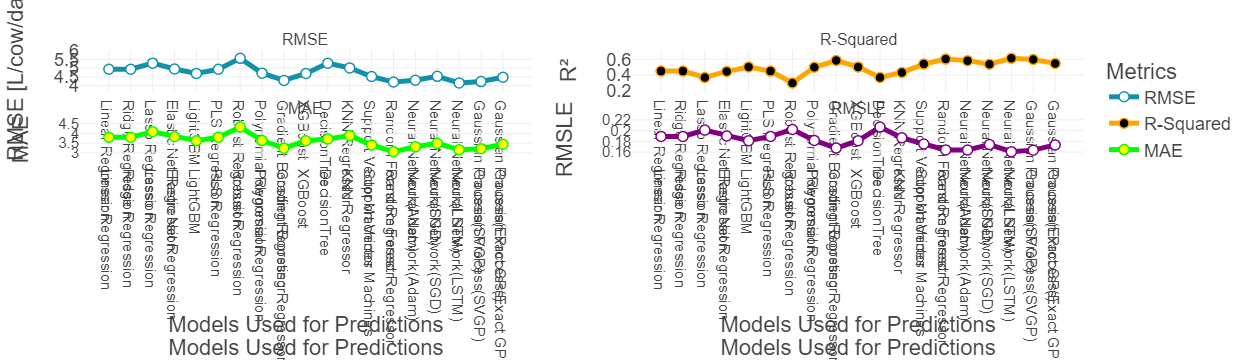

In [4]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming you have a DataFrame named mdf

columns = ['RMSE', 'R-Squared', 'MAE', 'RMSLE']  # Rearranged order

# Convert the columns to numeric type
mdf[columns] = mdf[columns].apply(pd.to_numeric)

# Create a subplot with 2 columns per row
fig = make_subplots(rows=len(columns)//2 + len(columns) % 2, cols=2, subplot_titles=columns)

# Define colors for lines and markers
line_colors = ["#1192AA", "#FFA500", "#00FF00", "#800080"]
marker_colors = ["white", "black", "yellow", "white"]

for i, column in enumerate(columns):
    row = i // 2 + 1  # Calculate the row for each subplot
    col = i % 2 + 1   # Calculate the column for each subplot

    # Create scatter trace for each column
    scatter_trace = go.Scatter(
        x=mdf['Model'],
        y=mdf[column],
        name=column,
        line_color=line_colors[i],
        line_width=5,
        marker=dict(
            symbol='circle',
            size=10,
            color=marker_colors[i],
            line=dict(
                color=line_colors[i],
                width=1.5
            )
        )
    )

    # Add trace to subplot
    fig.add_trace(scatter_trace, row=row, col=col)

    # Set subplot titles and axis labels
    fig.update_xaxes(title_text="Models Used for Predictions", tickfont=dict(size=15), row=row, col=col)

    # For 'R-Squared' subplot, set y-axis label without unit
    if column == 'R-Squared':
        fig.update_yaxes(title_text="R²", row=row, col=col)

    # For 'RMSE' subplot, add unit "[L/cow/day]" to the y-axis label
    elif column == 'RMSE':
        fig.update_yaxes(title_text="RMSE [L/cow/day]", row=row, col=col)

    # For other subplots, set y-axis label without unit
    else:
        fig.update_yaxes(title_text=column.replace(" ", "<br>"), tickfont=dict(size=15), row=row, col=col)

    fig.update_layout(
        font=dict(
            family="Arial",
            size=25
        ),
        template="presentation"  # Change the template to 'presentation'
    )

# Update layout for consistent settings
fig.update_layout(
    showlegend=True,
    height=1100,  # Increase the height to accommodate the last row
    # title_text="Comparison of all the Models",
    legend_title_text="Metrics",  # Legend title
    font=dict(family="Arial", size=18),
    template="presentation",
    margin=dict(b=200, t=50)  # Adjust bottom and top margins
)

# Show the plot
fig.show()


In [ ]:
import plotly.graph_objs as go
# from plotly.offline import plot, iplot, init_notebook_mode
# init_notebook_mode(connected=True)


columns = ['MAE', 'MSE', 'RMSE', 'RMSLE', 'R2 Square']

# Convert the columns to numeric type
mdf[columns] = mdf[columns].apply(pd.to_numeric)

for column in columns:
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=mdf['Model'],
        y=mdf[column],
        name=column,
        line_color="#1192AA",
        line_width=5,
        marker=dict(
            symbol='circle',
            size=8,
            color='white',
            line=dict(
                color='#1192AA',
                width=1.5
            )
        )
    ))

    fig.update_layout(
        title=f"Comparison of all the Models used for Predictions based on the {column}",
        xaxis_title="Models Used for Predictions",
        yaxis_title=column,
        font=dict(
            family="Arial",
            size=25
        ),
        height=700
    )

    fig.update_xaxes(tickfont=dict(size=15))

    fig.layout.template = "plotly_dark"
    fig.show()
    # fig.write_html('plotly_figure.html')

### Visualise the Modelling Results for concentrate Alone and for All the predictors

In [20]:
predicted_test_dataframe = pd.read_csv("data/")
predicted_test_dataframe.head(5)

smp_date smp_seas  sampling_year sampling_month  sampling_day     id  \
0  2011-10-07   Spring           2011            Oct             7  C1247   
1  2011-08-29   Winter           2011            Aug            29  C1222   
2  2011-11-04   Spring           2011            Nov             4  C1003   
3  2010-10-07   Spring           2010            Oct             7  C1159   
4  2011-07-12   Winter           2011            Jul            12  C6990   

               Breed treatment  lact   calv_date  ...   lw conc  Response  \
0  Holstein-Friesian         A     1  2011-02-23  ...  541  8.0  3.875000   
1  Holstein-Friesian         A     1  2010-11-18  ...  530  8.0  3.700000   
2  Holstein-Friesian         A     3  2011-02-24  ...  668  9.0  4.144444   
3  Holstein-Friesian         B     1  2010-09-02  ...  497  8.0  2.637500   
4  Holstein-Friesian         B     3  2011-02-23  ...  588  8.0  4.637500   

     my  Predicted_my_rf Predicted_my_rf_conc  Predicted_my_LSTM  \
0  31.0        27.866667            26.545206          25.469711   
1  29.6        21.436752            26.545206          22.780725   
2  37.3        24.843733            31.362323          30.147394   
3  21.1        23.690000            26.545206          26.521132   
4  37.1        29.837552            26.545206          30.626572   

   Predicted_my_gp_1  Predicted_my_gp_2  Predicted_my_rf_noconc  
0          26.091871          24.557724               25.839556  
1          21.283924          21.486145               23.883750  
2          29.595419          32.457584               25.771111  
3          25.455820          25.037563               23.921667  
4          30.866020          29.198118               30.021217  

[5 rows x 26 columns]

In [21]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    metrics = {
        'R-Squared': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'MAE': mean_absolute_error(y_true, y_pred)
    }
    return metrics

def save_metrics_to_csv(metrics_df, file_path='metrics_df_elanco.csv'):
    metrics_df.to_csv(file_path, index=False)

# Assuming predicted_test_dataframe is your DataFrame
# Replace 'Predicted_my_rf_conc', 'Predicted_my_rf', 'Predicted_my_rf_noconc', and 'my' with your actual column names
y_true = predicted_test_dataframe['my']

# Define prediction sets
prediction_sets = {
    'Predicted_my_rf_conc': predicted_test_dataframe['Predicted_my_rf_conc'],
    'Predicted_my_rf': predicted_test_dataframe['Predicted_my_rf'],
    'Predicted_my_rf_noconc': predicted_test_dataframe['Predicted_my_rf_noconc']
}

# Calculate metrics for each prediction set
metrics_dict = {}
for set_name, y_pred in prediction_sets.items():
    metrics_dict[set_name] = calculate_metrics(y_true, y_pred)

# Creating a new DataFrame to store the metrics
metrics_df_elanco = pd.DataFrame(metrics_dict)

# Transpose the DataFrame for the desired format
metrics_df_elanco = metrics_df_elanco.T.reset_index()
metrics_df_elanco.columns = ['Prediction Variations'] + list(metrics_dict['Predicted_my_rf_conc'].keys())

# Sort the DataFrame based on R-Squared values in ascending order
metrics_df_elanco = metrics_df_elanco.sort_values(by='R-Squared')

# Displaying the metrics DataFrame
print(metrics_df_elanco)

# Save the metrics DataFrame to a CSV file
save_metrics_to_csv(metrics_df_elanco)


    Prediction Variations  R-Squared        MSE      RMSE       MAPE       MAE
0    Predicted_my_rf_conc   0.293466  31.293304  5.594042  18.050526  4.426528
2  Predicted_my_rf_noconc   0.306984  30.694592  5.540270  16.745353  4.267506
1         Predicted_my_rf   0.602075  17.624634  4.198170  12.390355  3.060972


In [15]:
metrics_df

Prediction Variations  R-Squared        MSE      RMSE       MAPE       MAE
0    Predicted_my_rf_conc   0.293466  31.293304  5.594042  18.050526  4.426528
1  Predicted_my_rf_noconc   0.306984  30.694592  5.540270  16.745353  4.267506
2         Predicted_my_rf   0.602075  17.624634  4.198170  12.390355  3.060972

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Load the metrics DataFrame
metrics_df = pd.read_csv("metrics_df_elanco.csv")

# Function to create a scatter plot for a given model
def create_scatter_plot(x_data, y_data, metrics_row, subplot_label, plot_number):
    fig = go.Figure()
    
    # Add scatter plot
    fig.add_trace(go.Scatter(x=x_data,
                             y=y_data,
                             mode='markers',
                             marker=dict(size=4, color='teal', opacity=0.6),  # Adjusted marker size and opacity
                             showlegend=False))  # Hide legend
    
    # Update layout
    fig.update_layout(
        height=900, 
        width=800,
        template='presentation',
        font=dict(family='Times New Roman'),
        margin=dict(l=150, r=100, t=100, b=150)  # Adjust margins
    )
    
    # Update axes titles with bold formatting using <b> tags
    fig.update_xaxes(title_text='Milk Yield Predictions [L/cow/day]', 
                     tickfont=dict(family='Times New Roman', size=35, color='black'),  # Font settings for x-axis ticks
                     title_font=dict(size=32))
    fig.update_yaxes(title_text='Actual Milk Yield Observations [L/cow/day]', 
                     tickfont=dict(family='Times New Roman', size=35, color='black'),  # Font settings for y-axis ticks
                     title_font=dict(size=32))
    
    # Add subplot label (a), (b), or (c) as title with bold formatting
    fig.update_layout(title=f'<b>{subplot_label}</b>', title_x=0.5, title_font=dict(size=40))
    
    # Create and add metrics annotations below the plot
    metrics_colors = {
        'R-Squared': 'skyblue',
        'RMSE': 'green',
    }

    # Set annotation position
    annotation_x = 50
    annotation_y = 56

    # Add metrics as annotations
    annotations_text = []
    for metric, color in metrics_colors.items():
        metric_value = metrics_row.get(metric, None)
        if metric_value is not None:
            # Add <b> tags to make the metric names and values bold in the annotations
            if metric == 'RMSE':
                annotations_text.append(f'{metric}: {metric_value:.2f} L/cow')
            else:
                annotations_text.append(f'{metric}: {metric_value:.2f}')  # R-Squared without 'L/cow'
    
    # Join annotation texts with line breaks
    annotation_text = '<br>'.join(annotations_text)

    fig.add_annotation(
        x=annotation_x,  # Set x position for annotation
        y=annotation_y,  # Set y position for annotation
        text=annotation_text,
        font=dict(family='Times New Roman', size=30),  # No weight property, just family and size
        showarrow=False,
        align='left',
    )

    # Save the figure as a high-resolution SVG with scale = 10
    pio.write_image(fig, f'plot_{plot_number}.svg', format='svg', width=800, height=950, scale=20)

    return fig

# Create individual scatter plots for each model
fig1 = create_scatter_plot(predicted_test_dataframe['Predicted_my_rf_conc'],
                            predicted_test_dataframe['my'],
                            metrics_df.iloc[0],
                            '<b>(a)</b>',  # Bolded subplot label
                            '1')

fig2 = create_scatter_plot(predicted_test_dataframe['Predicted_my_rf_noconc'],
                            predicted_test_dataframe['my'],
                            metrics_df.iloc[1],
                            '<b>(b)</b>',  # Bolded subplot label
                            '2')

fig3 = create_scatter_plot(predicted_test_dataframe['Predicted_my_rf'],
                            predicted_test_dataframe['my'],
                            metrics_df.iloc[2],
                            '<b>(c)</b>',  # Bolded subplot label
                            '3')

# Show the plots
fig1.show()
fig2.show()
fig3.show()


In [107]:
os.getcwd()

'C:\\Users\\bnnen\\OneDrive\\Desktop\\Python Workspace\\gpytorch-master'

In [123]:
# Save the updated DataFrame with predictions
predicted_test_dataframe = pd.read_csv("data/")

individual_metrics_df = pd.read_csv(r'data/ Workspace\\gpytorch-master\\Metrics.csv')


In [126]:
individual_metrics_df.Parity.unique()

array([3, 2, 4, 1], dtype=int64)

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Convert Parity column to object type
individual_metrics_df['Parity'] = individual_metrics_df['Parity'].astype(str)

# Group the data by R_squared_group and Parity, then calculate the count of cows in each group
r_squared_group_percentages = individual_metrics_df.groupby(['R_squared_group', 'Parity']).size().reset_index(name='Count')

# Calculate the percentage of cows in each R_squared_group within each Parity group
total_count = r_squared_group_percentages['Count'].sum()  # Total number of cows
r_squared_group_percentages['Percentage'] = (r_squared_group_percentages['Count'] / total_count) * 100  # Calculate overall percentage

# Define a custom color scale with different shades of teal
color_scale = ['#008080', '#20B2AA', '#40E0D0', '#5F9EA0']  # Teal shades

# Create a bar chart using Plotly Express
fig = px.bar(
    r_squared_group_percentages,
    x='R_squared_group',
    y='Percentage',
    color='Parity',  # Use 'Parity' for colors
    text='Count',  # Change labels to actual counts of cows
    color_discrete_sequence=color_scale,  # Apply the custom color scale
    labels={'R_squared_group': 'R-squared Categories', 'Percentage': 'Percentage of Cows'},
    template='presentation',
    height=600,
    width=700
)

# Update layout for bold labels, adjust font sizes, and customize legend
fig.update_traces(
    texttemplate='%{text}',
    textposition='outside',
    textfont=dict(size=18, family="Times New Roman", color='teal')  # Change label color to teal
)  
fig.update_layout(
    barmode='group',  # Set bars side by side
    font=dict(size=16, family="Times New Roman"),  # General font size and family
    title_font=dict(size=18, family="Times New Roman"),  # Title font size
    xaxis_title_text='R-squared Categories',  # X-axis title with bold
    yaxis_title_text='Percentage of Cows (%)',  # Y-axis title with bold
    xaxis=dict(tickfont=dict(size=22, family="Times New Roman")),  # X-axis ticks
    yaxis=dict(tickfont=dict(size=22, family="Times New Roman")),  # Y-axis ticks
    bargap=0.2,  # Adjust gap between bars
    legend_title=dict(font=dict(size=14, family="Times New Roman")),  # Legend title font
    legend=dict(font=dict(size=14, family="Times New Roman"), title='<b>Parity</b>', itemsizing='constant'),  # Legend title with bold
    margin=dict(l=100, r=100, t=100, b=100)  # Adjust margins
)

# Save the figure as SVG with a scale of 10 using plotly.io
pio.write_image(fig, "bar_chart.svg", scale=10)

# Show the figure
fig.show()


In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Save the updated DataFrame with predictions
predicted_test_dataframe = pd.read_csv("data/")
metrics_df = pd.read_csv("metrics_df_elanco.csv")

# Create a subplot with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=('(a)<br>Predicted vs Actual with Concentrate only',
                                                    '(b)<br>Predicted vs Actual with all predictors excluding Concentrate',
                                                    '(c)<br>Predicted vs Actual with all predictors including Concentrate'),
                    horizontal_spacing=0.10)  # Adjust spacing between plots

# Increase the font size of the subplot titles
for i in range(3):  # Assuming there are 3 subplot titles
    fig.layout.annotations[i].font.size = 28  # Adjust this value as needed

# Define colors for the metrics annotations
metrics_colors = {
    'R-Squared': 'skyblue',
    'MSE': 'orange',
    'RMSE': 'green',
    'MAPE': 'red',
    'MAE': 'purple'
}

# Function to create annotations and shapes for a given metrics row
def create_annotations_shapes(metrics_row, start_y=53, gap_step=1.5, col_num=1):
    annotations = []
    shapes = []
    
    for metric, color in metrics_colors.items():
        metric_value = metrics_row.get(metric, None)
        if metric_value is not None:
            relative_position_y = start_y - gap_step * list(metrics_colors).index(metric)
            
            # Increase the size of the circle by adjusting x0, x1, y0, y1 values
            circle_size = 0.4  # Adjust this value to increase the circle size
            
            x0 = col_num - circle_size / 2 + 0.5  # Adjust this value to shift the circle to the right
            x1 = col_num + circle_size / 2 + 0.5  # Adjust this value to shift the circle to the right
            y0 = relative_position_y - circle_size / 2
            y1 = relative_position_y + circle_size / 2

            shapes.append({
                'type': 'circle',
                'xref': f'x{col_num}',
                'yref': f'y{col_num}',
                'x0': x0,
                'y0': y0,
                'x1': x1,
                'y1': y1,
                'fillcolor': color,
                'line_color': color,
            })
            
            annotations.append(dict(
                xref=f'x{col_num}',
                yref=f'y{col_num}',
                x=x1 + 0.3,  # Adjust this value to shift the annotation to the right
                y=relative_position_y,
                xanchor='left',
                yanchor='middle',
                text=f'{metric}: {metric_value:.2f}',
                font=dict(family='Arial', size=20),  # Adjust font size if necessary
                showarrow=False))
    
    return annotations, shapes

# Add scatter plot for the model with concentrate
fig.add_trace(go.Scatter(x=predicted_test_dataframe['Predicted_my_rf_conc'],
                         y=predicted_test_dataframe['my'],
                         mode='markers',
                         marker=dict(size=2, color='#0077b6'),  # Adjusted color
                         showlegend=False),  # Hide legend
              row=1, col=1)

# Add scatter plot for the model without concentrate
fig.add_trace(go.Scatter(x=predicted_test_dataframe['Predicted_my_rf_noconc'],
                         y=predicted_test_dataframe['my'],
                         mode='markers',
                         marker=dict(size=2, color='#d00000'),  # Adjusted color
                         showlegend=False),  # Hide legend
              row=1, col=2)

# Add scatter plot for the model with all predictors
fig.add_trace(go.Scatter(x=predicted_test_dataframe['Predicted_my_rf'],
                         y=predicted_test_dataframe['my'],
                         mode='markers',
                         marker=dict(size=2, color='#2ecc71'),  # Adjusted color
                         showlegend=False),  # Hide legend
              row=1, col=3)

# Update layout details
fig.update_layout(height=900, 
                  width = 2000, 
                  template='presentation',
                  margin=dict(l=150, r=100, t=100, b=100)  # Add margins: left (l), right (r), top (t), bottom (b))  # Increase the size of each plot
                 )

# Update axes titles for all plots
axes_titles = {'x': 'Milk Yield Predictions [L/cow/day]', 'y': 'Actual Milk Yield Observations [L/cow/day]'}
for col_num in range(1, 4):
    fig.update_xaxes(title_text=axes_titles['x'], row=1, col=col_num, tickfont=dict(size=26), title_font=dict(size=26))
    fig.update_yaxes(title_text=axes_titles['y'], row=1, col=col_num, tickfont=dict(size=26), title_font=dict(size=26))

# Create and add annotations for each model
for col_num in range(1, 4):
    metrics_row = metrics_df.iloc[col_num - 1]  # Use the corresponding row for each subplot
    annotations, shapes = create_annotations_shapes(metrics_row, col_num=col_num)
    
    # Add shapes to the layout
    for shape in shapes:
        fig.add_shape(shape, row=1, col=col_num)

    # Add annotations to the layout
    for annotation in annotations:
        fig.add_annotation(annotation, row=1, col=col_num)

# Save the figure as a high-resolution SVG
pio.write_image(fig, 'plot.svg', format='svg', width=2500, height=1000)


# # Show the plot
# fig.show()




In [63]:
all_cow_metrics_df = pd.read_csv("data/")
all_cow_metrics_df

ID  Record_Count  Parity  R_squared      RMSE        MSE       MAE  \
0    C7029             2       3   1.000000  1.490729   2.222272  1.068833   
1    C1045            51       2   0.895354  2.115376   4.474815  1.619554   
2    C5820            52       4   0.854798  3.272005  10.706016  2.612060   
3    C6973            53       3   0.848268  3.089788   9.546788  2.472384   
4    C1017            27       2   0.847963  3.574797  12.779170  2.443214   
..     ...           ...     ...        ...       ...        ...       ...   
125  C1203            58       1   0.008420  4.989025  24.890372  3.533729   
126  C1240            56       1   0.005810  3.546522  12.577821  2.970408   
127  C1207            55       1   0.005379  4.481969  20.088048  3.302570   
128  C7003            42       3   0.000542  4.363704  19.041915  3.486478   
129  C1259            50       1   0.000303  6.593095  43.468897  5.371221   

          MAPE  
0     3.191492  
1     5.153872  
2     7.944054  
3     8.363893  
4    10.504780  
..         ...  
125  20.169871  
126  12.602855  
127  19.805726  
128  12.243757  
129  18.045869  

[130 rows x 8 columns]

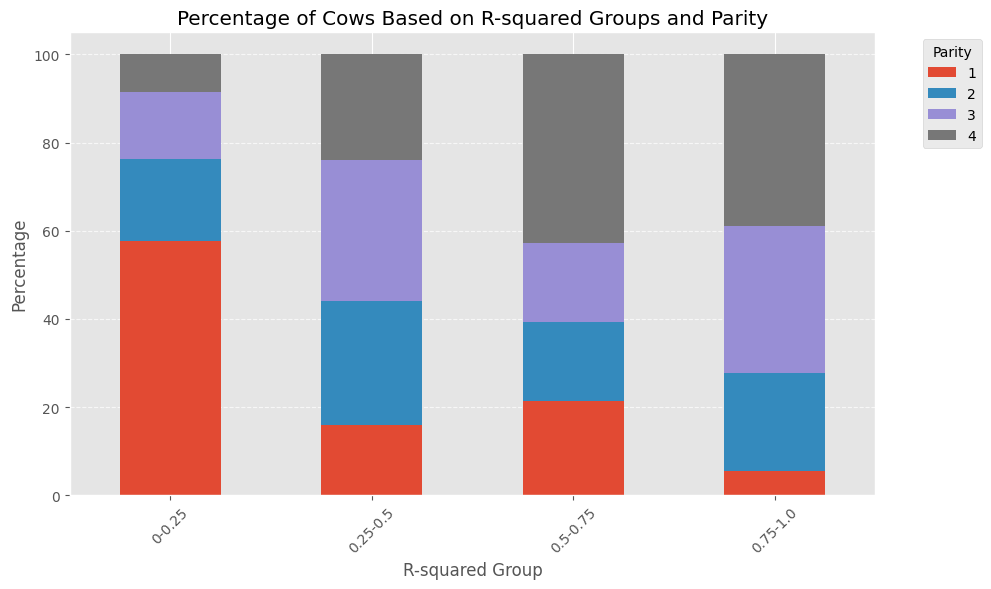

In [69]:
import pandas as pd
import matplotlib.pyplot as plt


import logging

# Get the root logger
logger = logging.getLogger()

# Set the log level to a higher level to suppress debug messages
logger.setLevel(logging.INFO)  # You can use logging.ERROR, logging.WARNING, logging.INFO, etc.

# To suppress debug messages from specific libraries, you can adjust their loggers as well
# For example, to suppress debug messages from matplotlib
matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)  # Suppress debug messages, only show warnings and errors


# Assuming you have a dataframe named 'all_cow_metrics_df' with 'R_squared' and 'Parity' columns
# Group the cows into four categories based on R-squared
all_cow_metrics_df['R_squared_group'] = pd.cut(all_cow_metrics_df['R_squared'], bins=[0, 0.25, 0.5, 0.75, 1.0], labels=['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])

# Calculate the percentage of cows in each R-squared group and Parity
r_squared_parity_percentages = all_cow_metrics_df.groupby(['R_squared_group', 'Parity']).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1) * 100

# Plot the percentage of cows based on R-squared groups and Parity
r_squared_parity_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of Cows Based on R-squared Groups and Parity')
plt.xlabel('R-squared Group')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Parity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


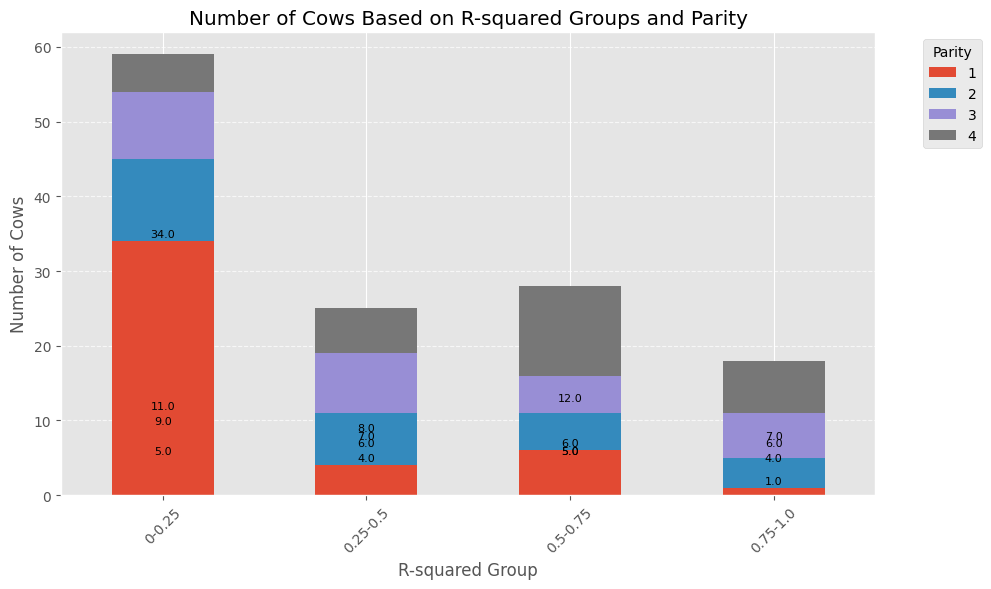

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a dataframe named 'all_cow_metrics_df' with 'R_squared' and 'Parity' columns
# Group the cows into four categories based on R-squared
all_cow_metrics_df['R_squared_group'] = pd.cut(all_cow_metrics_df['R_squared'], bins=[0, 0.25, 0.5, 0.75, 1.0], labels=['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1.0'])

# Calculate the count of cows in each R-squared group and Parity
r_squared_parity_counts = all_cow_metrics_df.groupby(['R_squared_group', 'Parity']).size().unstack(fill_value=0)

# Plot the count of cows based on R-squared groups and Parity
ax = r_squared_parity_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Cows Based on R-squared Groups and Parity')
plt.xlabel('R-squared Group')
plt.ylabel('Number of Cows')
plt.xticks(rotation=45)
plt.legend(title='Parity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the sum of cows for each group
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{}'.format(height),
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', fontsize=8)

plt.tight_layout()
plt.show()


### Import Libraries used for Optimisation

In [24]:
#Import all libraries
#Import all libraries
%set_env CUDA_VISIBLE_DEVICES=0
import random
import warnings
import math
import torch
import gpytorch
import sys
import os
import time
import logging
import urllib.request
import os.path
import seaborn as sns
import gpflow
import tensorflow as tf
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import gc
import tqdm
import sklearn
import copy
import properscoring as ps


# GPyTorch Imports
import gpytorch
from gpytorch.models import ExactGP, IndependentModelList, ApproximateGP, GP
from gpytorch.means import ConstantMean, MultitaskMean, LinearMean
from gpytorch.kernels import ScaleKernel, MultitaskKernel
from gpytorch.kernels import RBFKernel,  ScaleKernel, ProductKernel
from gpytorch.likelihoods import GaussianLikelihood, LikelihoodList, MultitaskGaussianLikelihood
from gpytorch.mlls import SumMarginalLogLikelihood, ExactMarginalLogLikelihood, VariationalELBO, AddedLossTerm
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

# General libraries
from matplotlib import pyplot as plt
from random import randrange,sample,randint
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy import linalg
from scipy.io import loadmat
from time import time
from math import floor  
from torch import nn, optim
from torch.autograd import Variable
from math import exp, pi
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,LabelEncoder,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, learning_curve
from sklearn.pipeline import make_pipeline
# pip install -U scikit-learn
# Used to split data into training and test data
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import(RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)


#Sklearn Libraries

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression,mutual_info_classif,SelectFromModel,RFE
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance
import xgboost
from xgboost import XGBRegressor
import lightgbm as lgb

## ANN LIBRARY
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Multiple math functions
from tensorflow import math
from tensorflow.keras.utils import plot_model
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# added these lines to include PyTorch-LBFGS
import sys
#sys.path.append(r"data/file.csv")
#sys.path.append("data/file.csv")
# sys.path.append("data/file.csv")
# from LBFGS import LBFGS, FullBatchLBFGS

#Added Torch Libraries
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.transforms import SigmoidTransform, PowerTransform
from torch.distributions.normal import Normal

from drs import drs

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2
    
plt.style.use('ggplot')

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extra Libraries

In [25]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
import numpy as np
import math
import datetime as dt
import sys
import pyodbc
import time
import tqdm.notebook as tqdm
import sklearn.metrics
import tqdm

### Load Random Forest Model (Pretrained Predictive Model) and Scalers used for training

In [26]:
import pickle
from pickle import load
# load the model
loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# load the scaler for predictors
scaler_x = load(open('scaler_x.pkl', 'rb'))

# load the scaler for output variable(milk yield)
scaler_y = load(open('scaler_y.pkl', 'rb'))

### Preprocessing - Normalisation of all numerical columns: (Days in Milk, Milk Yield, Concentrate consumed)

#### Load subset of the data: 81 cows for 91 days. This data was used for optimisation process¶

In [21]:
df_81cows_91days_optimisation = pd.read_csv("data/").drop("Unnamed: 0", axis=1)
df_81cows_91days_optimisation['smp_date'] = df_81cows_91days_optimisation['smp_date'].astype('datetime64[ns]')
print(df_81cows_91days_optimisation.columns)
#Description of the data subset
subset_data_summary = df_81cows_91days_optimisation[["dim","lw", "conc", "my", "Response"]].describe(include="all")
print("Statistical Summary of Cows in the Subset Dataset \n")
print(subset_data_summary)

Index(['smp_date', 'smp_seas', 'sampling_year', 'sampling_month',
       'sampling_day', 'id', 'Breed', 'treatment', 'lact', 'calv_date',
       'calving_year', 'calving_month', 'calving_day', 'calv_seas', 'dim',
       'sol', 'lw', 'conc', 'Response', 'my'],
      dtype='object')
Statistical Summary of Cows in the Subset Dataset 

               dim           lw         conc           my     Response
count  7371.000000  7371.000000  7371.000000  7371.000000  7371.000000
mean    149.821734   581.739113     8.224800    27.063926     3.292318
std      67.803801    81.168065     0.459264     5.282748     0.619078
min      39.000000   404.000000     8.000000     9.200000     1.150000
25%      96.000000   518.000000     8.000000    23.300000     2.847222
50%     135.000000   591.000000     8.000000    27.000000     3.312500
75%     203.000000   645.000000     8.000000    30.700000     3.762500
max     306.000000   886.000000    10.000000    47.800000     5.311111


In [22]:
### All Variables and Target Variables
new_arrangement = ["smp_date", "id", "lact", "dim", "lw", "conc", "my"]
df_81cows_91days = df_81cows_91days_optimisation[new_arrangement]
df_81cows_91days = pd.DataFrame(df_81cows_91days)
print(df_81cows_91days.shape)
### Response per animal per day
new_arrangement = ["smp_date", "id","Response"]
df_milk_yield_per_concentrate_consumed = df_81cows_91days_optimisation[new_arrangement]
df_milk_yield_per_concentrate_consumed = pd.DataFrame(df_milk_yield_per_concentrate_consumed)
df_milk_yield_per_concentrate_consumed = df_milk_yield_per_concentrate_consumed.set_index('smp_date')
response = df_milk_yield_per_concentrate_consumed.pivot(columns='id')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
response.columns = [col[1] for col in response.columns]
print(response.shape)
print(response.columns)
#response = conc.reset_index().rename_axis(columns=None)
#response = response.drop(["index"], axis=1) # Features
# response.head()

(7371, 7)
(91, 81)
Index(['C1014', 'C1024', 'C1032', 'C1035', 'C1039', 'C1045', 'C1065', 'C1066',
       'C1069', 'C1070', 'C1073', 'C1078', 'C1086', 'C1088', 'C1093', 'C1099',
       'C1100', 'C1104', 'C1107', 'C1121', 'C1134', 'C1144', 'C1169', 'C1175',
       'C1189', 'C1196', 'C1198', 'C1202', 'C1203', 'C1207', 'C1215', 'C1218',
       'C1219', 'C1222', 'C1224', 'C1228', 'C1231', 'C1233', 'C1239', 'C1240',
       'C1245', 'C1247', 'C1248', 'C1255', 'C1257', 'C1259', 'C1262', 'C1268',
       'C5735', 'C5792', 'C5820', 'C5857', 'C6544', 'C6602', 'C6651', 'C6706',
       'C6817', 'C6828', 'C6849', 'C6863', 'C6888', 'C6897', 'C6913', 'C6923',
       'C6931', 'C6940', 'C6964', 'C6965', 'C6982', 'C6990', 'C6995', 'C7003',
       'C7008', 'C7017', 'C7024', 'C7025', 'C7027', 'C7028', 'C7030', 'C7036',
       'C7046'],
      dtype='object')


In [7]:
df_81cows_91days.head(5)

smp_date     id  lact  dim   lw  conc    my
0 2011-04-05  C1014     3   44  624     8  32.7
1 2011-04-05  C1024     3   45  595     9  36.4
2 2011-04-05  C1032     2  111  563     8  27.7
3 2011-04-05  C1035     3   47  518     8  34.2
4 2011-04-05  C1039     3  144  570     8  30.7

In [23]:
import pandas as pd

# Assuming df_81cows_91days is your original DataFrame
# Group by 'smp_date' and perform the required calculations
summation_df_my_conc = df_81cows_91days.groupby('smp_date').agg(
    num_cows=('id', 'nunique'), # Counting unique cows per day
    sum_conc=('conc', 'sum'),
    sum_my=('my', 'sum')
    
).reset_index()

# Sorting the DataFrame by 'smp_date'
summation_df_my_conc.sort_values(by='smp_date', inplace=True)

# Save the DataFrame to a CSV file
summation_df_my_conc.to_csv('summation_df_my_conc.csv', index=False)

# Display the DataFrame
summation_df_my_conc.head(5)

smp_date  num_cows  sum_conc  sum_my
0 2011-04-05        81       659  2331.8
1 2011-04-07        81       657  2242.2
2 2011-04-08        81       657  2253.1
3 2011-04-09        81       657  2347.3
4 2011-04-10        81       657  2244.0

In [24]:
# Assuming your final_cows_dataframe has columns like 'smp_date', 'conc', 'my', and 'id_true'
# Adjust column names as needed

# Group by 'smp_date' and aggregate total concentrate consumption, total milk yield, and count of unique cows
aggregated_data = df_81cows_91days.groupby('smp_date').agg({
    'id': 'nunique',  # Count the number of unique cows
    'conc': 'sum',
    'my': 'sum'
}).reset_index()

# Rename the 'id_true' column to 'unique_cows'
aggregated_data.rename(columns={'id': 'unique_cows'}, inplace=True)

# Round the 'conc' and 'my' columns to one decimal point
aggregated_data['conc'] = aggregated_data['conc'].round(1)
aggregated_data['my'] = aggregated_data['my'].round(1)

# Print the new DataFrame with the desired information
print("DataFrame with date, total conc per day, total milk yield per day, and unique cows per day:")
print(aggregated_data)


DataFrame with date, total conc per day, total milk yield per day, and unique cows per day:
     smp_date  unique_cows  conc      my
0  2011-04-05           81   659  2331.8
1  2011-04-07           81   657  2242.2
2  2011-04-08           81   657  2253.1
3  2011-04-09           81   657  2347.3
4  2011-04-10           81   657  2244.0
..        ...          ...   ...     ...
86 2011-07-04           81   653  2173.5
87 2011-07-05           81   653  2195.8
88 2011-07-06           81   653  2263.9
89 2011-07-07           81   653  2229.0
90 2011-07-08           81   653  2094.0

[91 rows x 4 columns]


### Visualising the Herd Based Total Concentrate Allocation and Corresponding Total Milk Yield per day for the 81 cows accross 91 days

C:\Users\bnnen\anaconda3\envs\virtual1\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



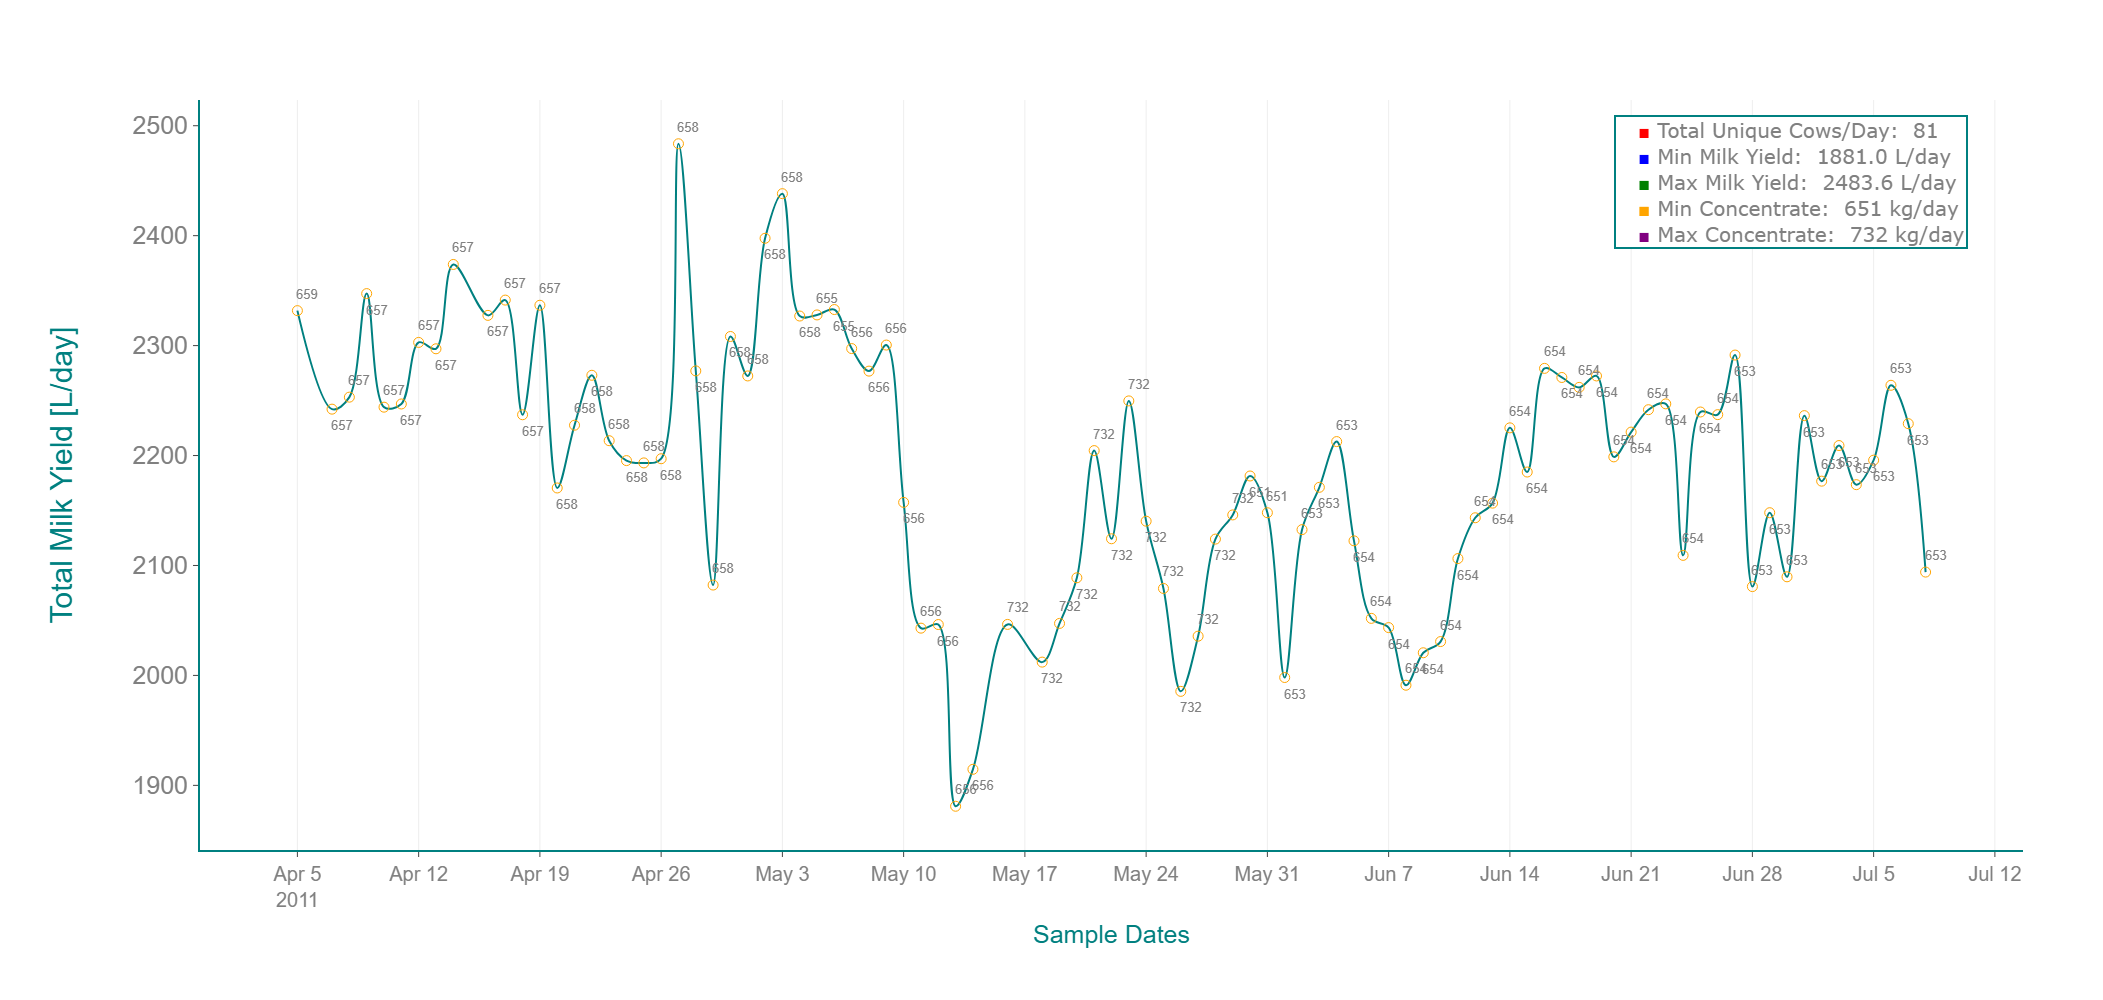

In [47]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio
import numpy as np

# Example DataFrame with datetime conversion
summation_df_my_conc['smp_date'] = pd.to_datetime(summation_df_my_conc['smp_date'])


# Creating the plot with Plotly
fig = go.Figure()

# Adding the milk yield line plot with a smooth curve
fig.add_trace(go.Scatter(
    x=summation_df_my_conc['smp_date'], 
    y=summation_df_my_conc['sum_my'],
    mode='lines+markers',
    name='Milk Yield',
    line=dict(color='teal', width=2, dash='solid'),
    marker=dict(symbol='circle-open', color='orange', size=10),
    line_shape='spline'  # Making the line plot a smooth curve
))

# Adding annotations for total concentrate with alternating positions
for i in range(len(summation_df_my_conc)):
    # Alternate annotation positions based on the index
    y_position = summation_df_my_conc['sum_my'][i] + (15 if i % 2 == 0 else -15)
    
    fig.add_annotation(
        x=summation_df_my_conc['smp_date'][i], 
        y=y_position,
        text=str(summation_df_my_conc['sum_conc'][i]),
        font=dict(
            family="Arial",
            size=13,
            color="gray"
        ),
        showarrow=False,
        xshift=10,
        yshift=0  # Remove yshift to prevent additional adjustment
    )

# Calculating additional annotation values
total_unique_cows_per_day = summation_df_my_conc['num_cows'].max()
min_total_milk_yield = summation_df_my_conc['sum_my'].min()
max_total_milk_yield = summation_df_my_conc['sum_my'].max()
min_total_concentrate = summation_df_my_conc['sum_conc'].min()
max_total_concentrate = summation_df_my_conc['sum_conc'].max()

# Adding a single annotation box with all additional information, colored boxes, and simulated padding
fig.add_annotation(
    x=0.97,
    y=0.98,
    xref="paper",
    yref="paper",
    text=(
        f"<br>"  # Top padding
        f"&nbsp;&nbsp;&nbsp;<span style='color:red;'>&#9632;</span>&nbsp;Total Unique Cows/Day: \t{total_unique_cows_per_day}<br>"
        f"&nbsp;&nbsp;&nbsp;<span style='color:blue;'>&#9632;</span>&nbsp;Min Milk Yield: \t{min_total_milk_yield} L/day<br>"
        f"&nbsp;&nbsp;&nbsp;<span style='color:green;'>&#9632;</span>&nbsp;Max Milk Yield: \t{max_total_milk_yield} L/day<br>"
        f"&nbsp;&nbsp;&nbsp;<span style='color:orange;'>&#9632;</span>&nbsp;Min Concentrate: \t{min_total_concentrate} kg/day<br>"
        f"&nbsp;&nbsp;&nbsp;<span style='color:purple;'>&#9632;</span>&nbsp;Max Concentrate: \t{max_total_concentrate} kg/day<br>"
        f"<br>"  # Bottom padding
    ),
    showarrow=False,
    align="left",
    bgcolor="white",
    bordercolor="teal",
    borderwidth=2,
    font=dict(size=20, color="gray")
)

# Updating layout for 7 days interval on x-axis, increasing plot size, and adjusting axis labels
fig.update_layout(
    title={
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=35, color='gray')
    },
    xaxis_title="Sample Dates",
    yaxis_title="Total Milk Yield [L/day]",
    template='presentation',
    xaxis=dict(
        tickmode='linear',
        tick0=summation_df_my_conc['smp_date'].min(),
        dtick=604800000,  # 7 days in milliseconds
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='teal',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=20,
            color='gray'
        ),
        title_font=dict(
            family='Arial',
            size=25,
            color='teal'  # Setting color of x-axis title to teal
        )
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='teal',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=25,
            color='gray'
        ),
        title_standoff=40,  # Increasing the distance of the y-axis label from the ticks
        title_font=dict(
            family='Arial',
            size=30,
            color='teal'  # Setting color of y-axis title to teal
        )
    ),
    showlegend=False,
    autosize=True,
    height=1000, # Height of the plot
    width = 2000,
    margin=dict(l=200, b=150)
 )

# Moving the legend inside the plot
fig.update_layout(
    legend=dict(
        x=0.8,
        y=0.9,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=20,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

# Save the plot as SVG
pio.write_image(fig, 'plot_milk_yield.svg', format='svg',  height=1000, width = 2000, scale = 5)

# Show plot
fig.show()


In [11]:
import pandas as pd

# Sample code to load your dataframe and scaler
# df_81cows_91days = pd.read_csv('your_file.csv')
# scaler_x = joblib.load('scaler_x.pkl')

# 1. Sort the DataFrame based on 'smp_date'
df_81cows_91days.sort_values('smp_date', inplace=True)
print(df_81cows_91days.shape)

# # 2. Get the unique dates and select the first 2 days
# unique_days = df_81cows_91days['smp_date'].unique()
# first_2_days = unique_days[:2]

# # 3. Filter the DataFrame
# filtered_df = df_81cows_91days[df_81cows_91days['smp_date'].isin(first_2_days)]

# # Show the result
# print(filtered_df.shape)

# Define process_data function
def process_data(dataframe):
    # Keep the original 'id', 'dim', 'lact', 'my', 'lw', and 'conc' for later use
    original_data = dataframe[['id', 'dim', 'lact', 'my', 'lw', 'conc']]

    # Process the data
    dataframe['lact'] = dataframe['lact'].astype('object')
    df_predictors = dataframe.drop(['smp_date', 'id', 'my'], axis=1)
    X_test_num_sub = df_predictors.select_dtypes(include=['int64', 'float64'])
    X_test_cat_sub = df_predictors.select_dtypes(include=['object'])
    X_test_cat_sub = pd.get_dummies(X_test_cat_sub, columns=['lact']).astype(int)
    X_test_num_subscaled = pd.DataFrame(scaler_x.transform(X_test_num_sub), 
                                        columns=X_test_num_sub.columns, 
                                        index=X_test_num_sub.index)
    X_test_subtransformed = pd.concat([X_test_cat_sub, X_test_num_subscaled], axis=1)
    processed_data_per_day = X_test_subtransformed.to_numpy()
    
    return original_data, processed_data_per_day

# Define process_all_data_by_day function
def process_all_data_by_day(filtered_df):
    processed_data_list = []
    for day in filtered_df['smp_date'].unique():
        df_day = filtered_df[filtered_df['smp_date'] == day]
        original_data, processed_data = process_data(df_day)
        for i in range(len(original_data)):
            row = original_data.iloc[i].tolist() + [processed_data[i]]
            processed_data_list.append([day] + row)
    return processed_data_list

# Applying the function
processed_data_list = process_all_data_by_day(df_81cows_91days)

# Creating a DataFrame from the list
columns = ['smp_date', 'id', 'dim', 'actual_lact', 'actual_my', 'lw', 'actual_conc', 'ProcessedData']
combined_processed_df = pd.DataFrame(processed_data_list, columns=columns)

# Display the DataFrame
combined_processed_df

(7371, 7)


smp_date     id  dim  actual_lact  actual_my   lw  actual_conc  \
0    2011-04-05  C1014   44            3       32.7  624            8   
1    2011-04-05  C6849   54            4       35.0  634            9   
2    2011-04-05  C6828  126            4       33.0  638            8   
3    2011-04-05  C6817  144            4       28.7  650            8   
4    2011-04-05  C6706  139            4       32.6  675            9   
...         ...    ...  ...          ...        ...  ...          ...   
7366 2011-07-08  C1175  302            1       26.0  495            8   
7367 2011-07-08  C1169  142            1       16.9  572            8   
7368 2011-07-08  C1144  144            2       26.6  522            8   
7369 2011-07-08  C1107  192            2       28.0  604            8   
7370 2011-07-08  C7046  192            3       28.5  709            8   

                                          ProcessedData  
0     [0.0, 0.0, 1.0, 0.0, -1.4866217176725547, 0.49...  
1     [0.0, 0.0, 0.0, 1.0, -1.3615008680043694, 0.62...  
2     [0.0, 0.0, 0.0, 1.0, -0.4606307503934347, 0.68...  
3     [0.0, 0.0, 0.0, 1.0, -0.23541322099070106, 0.8...  
4     [0.0, 0.0, 0.0, 1.0, -0.29797364582479374, 1.1...  
...                                                 ...  
7366  [1.0, 0.0, 0.0, 0.0, 1.7414962037666277, -1.22...  
7367  [1.0, 0.0, 0.0, 0.0, -0.26043739092433815, -0....  
7368  [0.0, 1.0, 0.0, 0.0, -0.23541322099070106, -0....  
7369  [0.0, 1.0, 0.0, 0.0, 0.3651668574165887, 0.229...  
7370  [0.0, 0.0, 1.0, 0.0, 0.3651668574165887, 1.628...  

[7371 rows x 8 columns]

In [12]:
combined_processed_df.smp_date.unique()

<DatetimeArray>
['2011-04-05 00:00:00', '2011-04-07 00:00:00', '2011-04-08 00:00:00',
 '2011-04-09 00:00:00', '2011-04-10 00:00:00', '2011-04-11 00:00:00',
 '2011-04-12 00:00:00', '2011-04-13 00:00:00', '2011-04-14 00:00:00',
 '2011-04-16 00:00:00', '2011-04-17 00:00:00', '2011-04-18 00:00:00',
 '2011-04-19 00:00:00', '2011-04-20 00:00:00', '2011-04-21 00:00:00',
 '2011-04-22 00:00:00', '2011-04-23 00:00:00', '2011-04-24 00:00:00',
 '2011-04-25 00:00:00', '2011-04-26 00:00:00', '2011-04-27 00:00:00',
 '2011-04-28 00:00:00', '2011-04-29 00:00:00', '2011-04-30 00:00:00',
 '2011-05-01 00:00:00', '2011-05-02 00:00:00', '2011-05-03 00:00:00',
 '2011-05-04 00:00:00', '2011-05-05 00:00:00', '2011-05-06 00:00:00',
 '2011-05-07 00:00:00', '2011-05-08 00:00:00', '2011-05-09 00:00:00',
 '2011-05-10 00:00:00', '2011-05-11 00:00:00', '2011-05-12 00:00:00',
 '2011-05-13 00:00:00', '2011-05-14 00:00:00', '2011-05-16 00:00:00',
 '2011-05-18 00:00:00', '2011-05-19 00:00:00', '2011-05-20 00:00:00',
 '20

## Optimisation with Scipy and trust-constr

In [59]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import pandas as pd

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

# Define the objective function
def objective_function(concentrations, predictions, total_concentrate):
    total_yield = 0
    for cow_id, conc in enumerate(concentrations):
        total_yield += predictions[cow_id]['predictions'][conc]
    return -total_yield  # Negative because we want to maximize

# Define function to calculate predictions for each cow
def calculate_predictions(daily_df, initial_guess_concentrations, scaler_x, scaler_y, loaded_model):
    predictions_for_cows = {}
    daily_df_reset_index = daily_df.reset_index(drop=True)  # Resetting the index
    for index, row in daily_df_reset_index.iterrows():
        cow_id = index  # Using the index as cow ID
        actual_conc = row['actual_conc']
        processed_row = row['ProcessedData']

        modified_row = take_predictors(processed_row, initial_guess_concentrations, scaler_x)
        # Predict yield using the loaded model
        predicted_yield = loaded_model.predict(modified_row)[0]
        predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

        # Store the predictions using the cow_id as the key
        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'predictions': {initial_guess_concentrations: predicted_yield}}

    return predictions_for_cows

# Define optimization function
def optimize_concentrations(combined_processed_df, scaler_x, scaler_y, loaded_model):
    # Choose the first day for optimization
    date = combined_processed_df['smp_date'].min()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

    # Calculate the total concentrate and number of cows for the first day
    total_concentrate = daily_df['actual_conc'].sum()
    number_of_cows = len(daily_df['id'].unique())

    # Initial guess and bounds for the first day
    initial_guess_concentration = total_concentrate / number_of_cows
    initial_guess = np.array([initial_guess_concentration] * number_of_cows)
    lower_bound, upper_bound = max(5, initial_guess_concentration), min(10, initial_guess_concentration)
    bounds = [(lower_bound, upper_bound)] * number_of_cows

    # Define linear constraint for total concentrate
    total_concentrate_constraint = LinearConstraint(np.ones((1, number_of_cows)), total_concentrate, total_concentrate)

    # Calculate predictions for each cow for the first day
    predictions_for_cows = calculate_predictions(daily_df, initial_guess_concentration, scaler_x, scaler_y, loaded_model)

    # Minimize negative total yield
    result = minimize(objective_function, initial_guess, args=(predictions_for_cows, total_concentrate), constraints=total_concentrate_constraint, bounds=bounds, method='trust-constr')

    # Extract solution
    optimal_concentrations = result.x
    return optimal_concentrations

# Call the optimization function with necessary arguments
optimal_concentrations = optimize_concentrations(combined_processed_df, scaler_x, scaler_y, loaded_model)
print(optimal_concentrations)


KeyError: 8.135802590368707

In [58]:
daily_df

smp_date     id  dim  actual_lact  actual_my   lw  actual_conc  \
0  2011-04-05  C1014   44            3       32.7  624            8   
1  2011-04-05  C1245   48            1       21.2  429            8   
2  2011-04-05  C1032  111            2       27.7  563            8   
3  2011-04-05  C1035   47            3       34.2  518            8   
4  2011-04-05  C1039  144            3       30.7  570            8   
..        ...    ...  ...          ...        ...  ...          ...   
76 2011-04-05  C7027  106            3       33.7  642            8   
77 2011-04-05  C7028   44            3       35.7  631            9   
78 2011-04-05  C7030  124            3       33.4  626            8   
79 2011-04-05  C7036  122            3       31.6  604            8   
80 2011-04-05  C7008   39            3       32.9  628            8   

                                        ProcessedData  
0   [0.0, 0.0, 1.0, 0.0, -1.4866217176725547, 0.49...  
1   [1.0, 0.0, 0.0, 0.0, -1.4365733778052805, -2.1...  
2   [0.0, 1.0, 0.0, 0.0, -0.6483120248957128, -0.3...  
3   [0.0, 0.0, 1.0, 0.0, -1.449085462772099, -0.91...  
4   [0.0, 0.0, 1.0, 0.0, -0.23541322099070106, -0....  
..                                                ...  
76  [0.0, 0.0, 1.0, 0.0, -0.7108724497298055, 0.73...  
77  [0.0, 0.0, 1.0, 0.0, -1.4866217176725547, 0.58...  
78  [0.0, 0.0, 1.0, 0.0, -0.4856549203270718, 0.52...  
79  [0.0, 0.0, 1.0, 0.0, -0.5106790902607089, 0.22...  
80  [0.0, 0.0, 1.0, 0.0, -1.5491821425066474, 0.54...  

[81 rows x 8 columns]

In [ ]:
list(initial_guess_concentrations.values())

In [41]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import pandas as pd

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def objective_function(concentrations, predictions, total_concentrate):
    total_yield = 0
    for cow_id, conc in concentrations.items():
        total_yield += predictions[cow_id]['predictions'][conc]
    return -total_yield  # Negative because we want to maximize

# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Set up logging
# logging.basicConfig(level=logging.DEBUG)

# Load your data here
# combined_processed_df = ...

# Choose the first day for optimization
date = combined_processed_df['smp_date'].min()
daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

# Calculate the total concentrate and number of cows for the first day
total_concentrate = daily_df['actual_conc'].sum()
total_milk_yield = daily_df['actual_my'].sum()  # Calculate total milk yield
number_of_cows = len(daily_df['id'].unique())

# Calculate initial guess concentrations for each cow
initial_guess_concentrations = {}
for cow_id in daily_df['id'].unique():
    initial_guess_concentrations[cow_id] = total_concentrate / number_of_cows

# Define linear constraint for total concentrate
total_concentrate_constraint = LinearConstraint(np.ones((1, number_of_cows)), total_concentrate, total_concentrate)

# Calculate predictions for each cow for the first day
predictions_for_cows = {}
for cow_id in daily_df['id'].unique():
    cow_data = daily_df[daily_df['id'] == cow_id]
    actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
    processed_row = cow_data['ProcessedData'].iloc[0]

    # Calculate the initial guess
    initial_guess = initial_guess_concentrations[cow_id]

    modified_row = take_predictors(processed_row, initial_guess, scaler_x)
    predicted_yield = loaded_model.predict(modified_row)[0]
    predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

    predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {initial_guess: predicted_yield}}

# Minimize negative total yield
result = minimize(objective_function, initial_guess_concentrations, args=(predictions_for_cows, total_concentrate), constraints=total_concentrate_constraint, method='trust-constr')

# Extract solution
optimal_concentrations = result.x

# Collect response rates for min/max calculation
daily_response_rates = []
for cow_id, optimal_conc in enumerate(optimal_concentrations):
    predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_conc]
    actual_conc = predictions_for_cows[cow_id]['actual_conc']
    actual_yield = predictions_for_cows[cow_id]['actual_yield']

    # Calculate and collect response rate
    if optimal_conc != actual_conc:  # Avoid division by zero
        response_rate = (predicted_yield - actual_yield) / (optimal_conc - actual_conc)
        daily_response_rates.append(response_rate)

    individual_cow_data.setdefault(date, {})[cow_id] = {
        'Predicted Milk Yield': predicted_yield,
        'Optimal Concentrate': optimal_conc,
        'Actual Concentrate': actual_conc,
        'Actual Milk Yield': actual_yield
    }

max_response_rate = max(daily_response_rates, default=None)
min_response_rate = min(daily_response_rates, default=None)
percentage_increase = ((-result.fun - total_milk_yield) / total_milk_yield) * 100 if total_milk_yield > 0 else 0  # Corrected calculation

results.append({
    'Date': date,
    'Number of Cows': number_of_cows,
    'Total Actual Concentrate': total_concentrate,
    'Total Predicted Milk Yield': -result.fun,
    'Percentage Increase in Milk Yield': percentage_increase,
    'Max Response Rate': max_response_rate,
    'Min Response Rate': min_response_rate,
    'Optimization Time': result.optimization_time
})

# Output results
results_df = pd.DataFrame(results)
results_df


TypeError: float() argument must be a string or a real number, not 'dict'

In [23]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import time
import pandas as pd
import datetime
import logging

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def objective_function(concentrations, predictions, total_concentrate):
    total_yield = 0
    for cow_id, conc in enumerate(concentrations):
        total_yield += predictions[cow_id]['predictions'][conc]
    return -total_yield  # Negative because we want to maximize

def solve_knapsack(predictions, total_concentrate, total_actual_concentrate_ratio, prev_optimal_concentrates=None):
    # Extract cow IDs and predictions
    cow_ids = list(predictions.keys())
    num_cows = len(cow_ids)
    
    # Initial concentration guess (uniform distribution)
    if prev_optimal_concentrates is None:
        initial_guess = np.full(num_cows, total_concentrate / num_cows)
    else:
        initial_guess = np.array([prev_optimal_concentrates[date].get(cow_id, total_concentrate / num_cows) for cow_id in range(num_cows)])
    
    # Define linear constraint for total concentrate
    total_concentrate_constraint = LinearConstraint(np.ones((1, num_cows)), total_concentrate, total_concentrate)
    
    # Define bounds for each cow's concentration
    lower_bounds = np.maximum(5, initial_guess - 1)  # Lower bound should be at least 5
    upper_bounds = np.minimum(10, initial_guess + 1)  # Upper bound should be at most 10
    bounds = list(zip(lower_bounds, upper_bounds))
    
    # Minimize negative total yield
    result = minimize(objective_function, initial_guess, args=(predictions, total_concentrate), constraints=total_concentrate_constraint, bounds=bounds, method='trust-constr')
    
    # Extract solution
    solution = {cow_ids[i]: result.x[i] for i in range(num_cows)}
    total_predicted_yield = -result.fun  # Convert back to positive value
    total_optimal_concentrate = sum(result.x)

    # Adjust total optimal concentrate to be within 0.05% less than the total actual concentrate
    total_optimal_concentrate = min(total_optimal_concentrate, total_concentrate * 0.9995)

    return solution, total_predicted_yield, total_optimal_concentrate

# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Iterate through all unique dates in the dataset for the first day
for date in combined_processed_df['smp_date'].unique()[:1]:
    try:
        start_time = time.time()
        daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

        number_of_cows = len(daily_df['id'].unique())
        predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
        response_rates = []

        # Find the closest available date with optimal concentrates
        prev_date = date - datetime.timedelta(days=1)
        while prev_date not in prev_optimal_concentrates and prev_date >= combined_processed_df['smp_date'].min():
            prev_date -= datetime.timedelta(days=1)

        if prev_date in prev_optimal_concentrates:
            prev_optimal_concentrates[date] = prev_optimal_concentrates[prev_date].copy()
        else:
            # If no previous date found, initialize with the initial guess
            prev_optimal_concentrates[date] = {cow_id: total_concentrate / number_of_cows for cow_id in daily_df['id'].unique()}

        # Calculate the relative change in total actual concentrate for the current day relative to the previous day
        total_actual_concentrate_ratio = total_actual_concentrate_ratios.get(date, None)
        print(f"Relative change in total actual concentrate for {date}: {total_actual_concentrate_ratio}")

        # Calculate predictions for each cow for the current date
        for cow_id in daily_df['id'].unique():
            cow_data = daily_df[daily_df['id'] == cow_id]
            actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
            processed_row = cow_data['ProcessedData'].iloc[0]

            total_concentrate += actual_conc
            total_actual_yield += actual_yield

            # Use the initial guess and bounds for the first day
            initial_guess_conc = total_concentrate / number_of_cows
            lower_bound, upper_bound = max(5, initial_guess_conc - 1), min(10, initial_guess_conc + 1)
            initial_guess_conc = max(5, min(10, initial_guess_conc))  # Ensure initial guess is within bounds

            modified_row = take_predictors(processed_row, initial_guess_conc, scaler_x)
            predicted_yield = loaded_model.predict(modified_row)[0]
            predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

            predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {initial_guess_conc: predicted_yield}}

        # Call solve_knapsack function with total_actual_concentrate_ratio argument
        optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate, total_actual_concentrate_ratio)


        # Collect response rates for min/max calculation
        daily_response_rates = []
        for cow_id in daily_df['id'].unique():
            optimal_concentrate = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']

            # Calculate and collect response rate
            if optimal_concentrate != actual_concentrate:  # Avoid division by zero
                response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
                daily_response_rates.append(response_rate)
        
            individual_cow_data.setdefault(date, {})[cow_id] = {
                'Predicted Milk Yield': predicted_yield,
                'Optimal Concentrate': optimal_concentrate,
                'Actual Concentrate': actual_concentrate,
                'Actual Milk Yield': actual_yield
            }

        max_response_rate = max(daily_response_rates, default=None)
        min_response_rate = min(daily_response_rates, default=None)
        percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

        results.append({
            'Date': date,
            'Number of Cows': number_of_cows,
            'Total Actual Concentrate': total_concentrate,
            'Total Actual Milk Yield': total_actual_yield,
            'Total Predicted Milk Yield': total_predicted_yield,
            'Total Optimal Concentrate': total_optimal_concentrate,
            'Percentage Increase in Milk Yield': percentage_increase,
            'Max Response Rate': max_response_rate,
            'Min Response Rate': min_response_rate,
            'Optimization Time': time.time() - start_time
        })

        # Store the optimal concentrates for the next day
        for cow_id in daily_df['id'].unique():
            prev_optimal_concentrates[date][cow_id] = optimal_allocation[cow_id]

        logging.info(f"Optimization completed for date: {date}")
    except Exception as e:
        logging.error(f"Error optimizing for date: {date}. Error message: {str(e)}")

# Output results
results_df = pd.DataFrame(results)
# results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df


Relative change in total actual concentrate for 2011-04-05 00:00:00: 1


ERROR:root:Error optimizing for date: 2011-04-05 00:00:00. Error message: 0


Empty DataFrame
Columns: []
Index: []

### Stop Optimisation for all days

In [ ]:
import numpy as np
import time
import pandas as pd
import pulp
import datetime
from pickle import load
import logging

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack(predictions, total_concentrate, prev_optimal_concentrates=None):
    problem = pulp.LpProblem("MaximizeMilkYield", pulp.LpMaximize)
    x = {cow_id: {conc: pulp.LpVariable(f"x_{cow_id}_{conc}", 0, 1, pulp.LpBinary) 
                  for conc in predictions[cow_id]['predictions']} 
         for cow_id in predictions}

    # Objective function and constraints
    problem += pulp.lpSum([x[cow_id][conc] * predictions[cow_id]['predictions'][conc] 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']])
    
    # Ensure the total optimized concentrate is within 0.02% of the total concentrate
    problem += pulp.lpSum([x[cow_id][conc] * conc 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']]) >= total_concentrate * 0.9998
    
    for cow_id in predictions:
        problem += pulp.lpSum([x[cow_id][conc] for conc in predictions[cow_id]['predictions']]) == 1

        # Ensure the optimized concentrate stays between 5 and 10
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) >= 5
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) <= 9

    # Solve the problem
    problem.solve()

    solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if pulp.value(x[cow_id][conc]) == 1)
                for cow_id in predictions}
    total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
    total_optimal_concentrate = sum(solution.values())

    # Adjust total optimal concentrate to be within 0.02% less than the total actual concentrate
    total_optimal_concentrate = min(total_optimal_concentrate, total_concentrate * 0.9998)

    return solution, total_predicted_yield, total_optimal_concentrate


# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Iterate through all unique dates in the dataset
for date in combined_processed_df['smp_date'].unique():
    try:
        start_time = time.time()
        daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

        number_of_cows = len(daily_df['id'].unique())
        predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
        response_rates = []

        # Find the closest available date with optimal concentrates
        prev_date = date - datetime.timedelta(days=1)
        while prev_date not in prev_optimal_concentrates and prev_date >= combined_processed_df['smp_date'].min():
            prev_date -= datetime.timedelta(days=1)

        if prev_date in prev_optimal_concentrates:
            prev_optimal_concentrates[date] = prev_optimal_concentrates[prev_date].copy()
        else:
            prev_optimal_concentrates[date] = {}  # If no previous date found, initialize empty

        # Calculate predictions for each cow for the current date
        for cow_id in daily_df['id'].unique():
            cow_data = daily_df[daily_df['id'] == cow_id]
            actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
            processed_row = cow_data['ProcessedData'].iloc[0]

            total_concentrate += actual_conc
            total_actual_yield += actual_yield

            # Calculate the range of concentration levels to consider
            if date == combined_processed_df['smp_date'].min():
                # For the first day, consider actual conc plus or minus 1 with an interval of 0.5
                conc_levels = np.arange(actual_conc - 1, actual_conc + 1.5, 0.3)
            else:
                if cow_id in prev_optimal_concentrates[date]:
                    previous_optimal_conc = prev_optimal_concentrates[date][cow_id]
                    conc_levels = np.arange(previous_optimal_conc - 1, previous_optimal_conc + 1.5, 0.3)
                else:
                    raise ValueError(f"No previous optimal concentrate found for cow {cow_id} on {prev_date}")

            predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}

            for conc in conc_levels:
                modified_row = take_predictors(processed_row, conc, scaler_x)
                predicted_yield = loaded_model.predict(modified_row)[0]
                predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

                predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

        optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate)

        # Collect response rates for min/max calculation
        daily_response_rates = []
        for cow_id in daily_df['id'].unique():
            optimal_concentrate = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']

            # Calculate and collect response rate
            if optimal_concentrate != actual_concentrate:  # Avoid division by zero
                response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
                daily_response_rates.append(response_rate)
        
            individual_cow_data.setdefault(date, {})[cow_id] = {
                'Predicted Milk Yield': predicted_yield,
                'Optimal Concentrate': optimal_concentrate,
                'Actual Concentrate': actual_concentrate,
                'Actual Milk Yield': actual_yield
            }

        max_response_rate = max(daily_response_rates, default=None)
        min_response_rate = min(daily_response_rates, default=None)
        percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

        results.append({
            'Date': date,
            'Number of Cows': number_of_cows,
            'Total Actual Concentrate': total_concentrate,
            'Total Actual Milk Yield': total_actual_yield,
            'Total Predicted Milk Yield': total_predicted_yield,
            'Total Optimal Concentrate': total_optimal_concentrate,
            'Percentage Increase in Milk Yield': percentage_increase,
            'Max Response Rate': max_response_rate,
            'Min Response Rate': min_response_rate,
            'Optimization Time': time.time() - start_time
        })

        # Store the optimal concentrates for the next day
        for cow_id in daily_df['id'].unique():
            prev_optimal_concentrates[date][cow_id] = optimal_allocation[cow_id]

        logging.info(f"Optimization completed for date: {date}")
    except Exception as e:
        logging.error(f"Error optimizing for date: {date}. Error message: {str(e)}")

# Output results
results_df = pd.DataFrame(results)
# results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df


In [90]:
combined_processed_df

smp_date     id  dim  actual_lact  actual_my   lw  actual_conc  \
0    2011-04-05  C1014   44            3       32.7  624            8   
1    2011-04-05  C6888  106            4       34.7  646            8   
2    2011-04-05  C6828  126            4       33.0  638            8   
3    2011-04-05  C6817  144            4       28.7  650            8   
4    2011-04-05  C6706  139            4       32.6  675            9   
...         ...    ...  ...          ...        ...  ...          ...   
7366 2011-07-08  C1189  306            1       17.7  541            8   
7367 2011-07-08  C1175  302            1       26.0  495            8   
7368 2011-07-08  C1169  142            1       16.9  572            8   
7369 2011-07-08  C1144  144            2       26.6  522            8   
7370 2011-07-08  C7046  192            3       28.5  709            8   

                                          ProcessedData  
0     [0.0, 0.0, 1.0, 0.0, -1.4866217176725547, 0.49...  
1     [0.0, 0.0, 0.0, 1.0, -0.7108724497298055, 0.78...  
2     [0.0, 0.0, 0.0, 1.0, -0.4606307503934347, 0.68...  
3     [0.0, 0.0, 0.0, 1.0, -0.23541322099070106, 0.8...  
4     [0.0, 0.0, 0.0, 1.0, -0.29797364582479374, 1.1...  
...                                                 ...  
7366  [1.0, 0.0, 0.0, 0.0, 1.791544543633902, -0.610...  
7367  [1.0, 0.0, 0.0, 0.0, 1.7414962037666277, -1.22...  
7368  [1.0, 0.0, 0.0, 0.0, -0.26043739092433815, -0....  
7369  [0.0, 1.0, 0.0, 0.0, -0.23541322099070106, -0....  
7370  [0.0, 0.0, 1.0, 0.0, 0.3651668574165887, 1.628...  

[7371 rows x 8 columns]

### All Dates

In [ ]:
import numpy as np
import time
import pandas as pd
import pulp
import datetime
from pickle import load
import logging

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack(predictions, total_concentrate, prev_optimal_concentrates=None):
    problem = pulp.LpProblem("MaximizeMilkYield", pulp.LpMaximize)
    x = {cow_id: {conc: pulp.LpVariable(f"x_{cow_id}_{conc}", 0, 1, pulp.LpBinary) 
                  for conc in predictions[cow_id]['predictions']} 
         for cow_id in predictions}

    # Objective function and constraints
    problem += pulp.lpSum([x[cow_id][conc] * predictions[cow_id]['predictions'][conc] 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']])
    
    # Ensure the total optimized concentrate is within 0.02% of the total concentrate
    problem += pulp.lpSum([x[cow_id][conc] * conc 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']]) >= total_concentrate * 0.9998
    
    for cow_id in predictions:
        problem += pulp.lpSum([x[cow_id][conc] for conc in predictions[cow_id]['predictions']]) == 1

        # Ensure the optimized concentrate stays between 5 and 10
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) >= 5
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) <= 9

    # Solve the problem
    problem.solve()

    solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if pulp.value(x[cow_id][conc]) == 1)
                for cow_id in predictions}
    total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
    total_optimal_concentrate = sum(solution.values())

    # Adjust total optimal concentrate to be within 0.02% less than the total actual concentrate
    total_optimal_concentrate = min(total_optimal_concentrate, total_concentrate * 0.9998)

    return solution, total_predicted_yield, total_optimal_concentrate


# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Iterate through all unique dates in the dataset
for date in combined_processed_df['smp_date'].unique():
    try:
        start_time = time.time()
        daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

        number_of_cows = len(daily_df['id'].unique())
        predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
        response_rates = []

        # Find the closest available date with optimal concentrates
        prev_date = date - datetime.timedelta(days=1)
        while prev_date not in prev_optimal_concentrates and prev_date >= combined_processed_df['smp_date'].min():
            prev_date -= datetime.timedelta(days=1)

        if prev_date in prev_optimal_concentrates:
            prev_optimal_concentrates[date] = prev_optimal_concentrates[prev_date].copy()
        else:
            prev_optimal_concentrates[date] = {}  # If no previous date found, initialize empty

        # Calculate predictions for each cow for the current date
        for cow_id in daily_df['id'].unique():
            cow_data = daily_df[daily_df['id'] == cow_id]
            actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
            processed_row = cow_data['ProcessedData'].iloc[0]

            total_concentrate += actual_conc
            total_actual_yield += actual_yield

            # Calculate the range of concentration levels to consider
            if date == combined_processed_df['smp_date'].min():
                # For the first day, consider actual conc plus or minus 1 with an interval of 0.5
                conc_levels = np.arange(actual_conc - 1, actual_conc + 1.5, 0.3)
            else:
                if cow_id in prev_optimal_concentrates[date]:
                    previous_optimal_conc = prev_optimal_concentrates[date][cow_id]
                    conc_levels = np.arange(previous_optimal_conc - 1, previous_optimal_conc + 1.5, 0.3)
                else:
                    raise ValueError(f"No previous optimal concentrate found for cow {cow_id} on {prev_date}")

            predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}

            for conc in conc_levels:
                modified_row = take_predictors(processed_row, conc, scaler_x)
                predicted_yield = loaded_model.predict(modified_row)[0]
                predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

                predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

        optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate)

        # Collect response rates for min/max calculation
        daily_response_rates = []
        for cow_id in daily_df['id'].unique():
            optimal_concentrate = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']

            # Calculate and collect response rate
            if optimal_concentrate != actual_concentrate:  # Avoid division by zero
                response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
                daily_response_rates.append(response_rate)
        
            individual_cow_data.setdefault(date, {})[cow_id] = {
                'Predicted Milk Yield': predicted_yield,
                'Optimal Concentrate': optimal_concentrate,
                'Actual Concentrate': actual_concentrate,
                'Actual Milk Yield': actual_yield
            }

        max_response_rate = max(daily_response_rates, default=None)
        min_response_rate = min(daily_response_rates, default=None)
        percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

        results.append({
            'Date': date,
            'Number of Cows': number_of_cows,
            'Total Actual Concentrate': total_concentrate,
            'Total Actual Milk Yield': total_actual_yield,
            'Total Predicted Milk Yield': total_predicted_yield,
            'Total Optimal Concentrate': total_optimal_concentrate,
            'Percentage Increase in Milk Yield': percentage_increase,
            'Max Response Rate': max_response_rate,
            'Min Response Rate': min_response_rate,
            'Optimization Time': time.time() - start_time
        })

        # Store the optimal concentrates for the next day
        for cow_id in daily_df['id'].unique():
            prev_optimal_concentrates[date][cow_id] = optimal_allocation[cow_id]

        logging.info(f"Optimization completed for date: {date}")
    except Exception as e:
        logging.error(f"Error optimizing for date: {date}. Error message: {str(e)}")

# Output results
results_df = pd.DataFrame(results)
# results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df


### Check mate the days

In [180]:
import numpy as np
import time
import pandas as pd
import pulp
import datetime
from pickle import load
import logging

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack(predictions, total_concentrate, total_actual_concentrate_ratio, prev_optimal_concentrates=None):
    problem = pulp.LpProblem("MaximizeMilkYield", pulp.LpMaximize)
    x = {cow_id: {conc: pulp.LpVariable(f"x_{cow_id}_{conc}", 0, 1, pulp.LpBinary) 
                  for conc in predictions[cow_id]['predictions']} 
         for cow_id in predictions}

    # Objective function and constraints
    problem += pulp.lpSum([x[cow_id][conc] * predictions[cow_id]['predictions'][conc] 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']])
    
    # Adjust the constraint based on the total_actual_concentrate_ratio
    if total_actual_concentrate_ratio >= 1.1:
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for cow_id in predictions 
                               for conc in predictions[cow_id]['predictions']]) >= total_concentrate * 0.96   #5% below total concentrate 
    else:
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for cow_id in predictions 
                               for conc in predictions[cow_id]['predictions']]) >= total_concentrate * 0.9998   #0.02% below total concentrate

    problem += pulp.lpSum([x[cow_id][conc] * conc 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']]) <= total_concentrate
    
    for cow_id in predictions:
        problem += pulp.lpSum([x[cow_id][conc] for conc in predictions[cow_id]['predictions']]) == 1

        # Ensure the optimized concentrate stays between 5 and 10
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) >= 5
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) <= 9

    # Solve the problem
    problem.solve()

    solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if pulp.value(x[cow_id][conc]) == 1)
                for cow_id in predictions}
    total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
    total_optimal_concentrate = sum(solution.values())

    # Adjust total optimal concentrate to be within 0.02% less than the total actual concentrate
    total_optimal_concentrate = min(total_optimal_concentrate, total_concentrate * 0.9998)

    return solution, total_predicted_yield, total_optimal_concentrate




# Filter out data before '2011-05-14'
# combined_processed_df = combined_processed_df[combined_processed_df['smp_date'] >= '2011-05-14']

# Calculate the relative change in total actual concentrate for each day relative to the previous day
total_actual_concentrate_ratios = {}
dates = combined_processed_df['smp_date'].unique()
for i, date in enumerate(dates):
    if i == 0:
        total_actual_concentrate_ratios[date] = 1  # Set ratio to 1 for the first day
    else:
        prev_date = dates[i - 1]
        total_actual_concentrate_prev = combined_processed_df[combined_processed_df['smp_date'] == prev_date]['actual_conc'].sum()
        total_actual_concentrate_current = combined_processed_df[combined_processed_df['smp_date'] == date]['actual_conc'].sum()
        total_actual_concentrate_ratios[date] = total_actual_concentrate_current / total_actual_concentrate_prev if total_actual_concentrate_prev != 0 else 0
    



# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Set up logging
logging.basicConfig(level=logging.DEBUG)

# Iterate through all unique dates in the dataset
for date in combined_processed_df['smp_date'].unique()[:2]:
    try:
        start_time = time.time()
        daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

        number_of_cows = len(daily_df['id'].unique())
        predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
        response_rates = []

        # Find the closest available date with optimal concentrates
        prev_date = date - datetime.timedelta(days=1)
        while prev_date not in prev_optimal_concentrates and prev_date >= combined_processed_df['smp_date'].min():
            prev_date -= datetime.timedelta(days=1)

        if prev_date in prev_optimal_concentrates:
            prev_optimal_concentrates[date] = prev_optimal_concentrates[prev_date].copy()
        else:
            prev_optimal_concentrates[date] = {}  # If no previous date found, initialize empty

        # Calculate the relative change in total actual concentrate for the current day relative to the previous day
        total_actual_concentrate_ratio = total_actual_concentrate_ratios.get(date, None)
        print(f"Relative change in total actual concentrate for {date}: {total_actual_concentrate_ratio}")

        # Calculate predictions for each cow for the current date
        for cow_id in daily_df['id'].unique():
            cow_data = daily_df[daily_df['id'] == cow_id]
            actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
            processed_row = cow_data['ProcessedData'].iloc[0]
        
            total_concentrate += actual_conc
            total_actual_yield += actual_yield
        
            # Calculate the range of concentration levels to consider
            # Calculate the range of concentration levels to consider
            if date == combined_processed_df['smp_date'].min():
                # For the first day, consider actual conc plus or minus 1 with an interval of 0.5
                conc_levels = np.arange(actual_conc - 1, actual_conc + 1.5, 0.3)
            else:
                if cow_id in prev_optimal_concentrates[date]:
                    previous_optimal_conc = prev_optimal_concentrates[date][cow_id]
                    conc_levels = np.arange(previous_optimal_conc - 1, previous_optimal_conc + 1.5, 0.3)
                else:
                    raise ValueError(f"No previous optimal concentrate found for cow {cow_id} on {prev_date}")

        
            predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}
        
            for conc in conc_levels:
                modified_row = take_predictors(processed_row, conc, scaler_x)
                predicted_yield = loaded_model.predict(modified_row)[0]
                predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]
        
                predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

        # Call solve_knapsack function with total_actual_concentrate_ratio argument
        optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate, total_actual_concentrate_ratio)


        # Collect response rates for min/max calculation
        daily_response_rates = []
        for cow_id in daily_df['id'].unique():
            optimal_concentrate = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']

            # Calculate and collect response rate
            if optimal_concentrate != actual_concentrate:  # Avoid division by zero
                response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
                daily_response_rates.append(response_rate)
        
            individual_cow_data.setdefault(date, {})[cow_id] = {
                'Predicted Milk Yield': predicted_yield,
                'Optimal Concentrate': optimal_concentrate,
                'Actual Concentrate': actual_concentrate,
                'Actual Milk Yield': actual_yield
            }

        max_response_rate = max(daily_response_rates, default=None)
        min_response_rate = min(daily_response_rates, default=None)
        percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

        results.append({
            'Date': date,
            'Number of Cows': number_of_cows,
            'Total Actual Concentrate': total_concentrate,
            'Total Actual Milk Yield': total_actual_yield,
            'Total Predicted Milk Yield': total_predicted_yield,
            'Total Optimal Concentrate': total_optimal_concentrate,
            'Percentage Increase in Milk Yield': percentage_increase,
            'Max Response Rate': max_response_rate,
            'Min Response Rate': min_response_rate,
            'Optimization Time': time.time() - start_time
        })

        # Store the optimal concentrates for the next day
        for cow_id in daily_df['id'].unique():
            prev_optimal_concentrates[date][cow_id] = optimal_allocation[cow_id]

        logging.info(f"Optimization completed for date: {date}")
    except Exception as e:
        logging.error(f"Error optimizing for date: {date}. Error message: {str(e)}")

# Output results
results_df = pd.DataFrame(results)
# results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df


Relative change in total actual concentrate for 2011-05-14 00:00:00: 1


DEBUG:pulp.apis.core:C:\Users\bnnen\anaconda3\envs\virtual1\Lib\site-packages\pulp\solverdir\cbc\win\64\cbc.exe C:\Users\bnnen\AppData\Local\Temp\bf8f713d1e4a413c98d53d23659b30da-pulp.mps max timeMode elapsed branch printingOptions all solution C:\Users\bnnen\AppData\Local\Temp\bf8f713d1e4a413c98d53d23659b30da-pulp.sol 
INFO:root:Optimization completed for date: 2011-05-14 00:00:00


Relative change in total actual concentrate for 2011-05-16 00:00:00: 1.1158536585365855


DEBUG:pulp.apis.core:C:\Users\bnnen\anaconda3\envs\virtual1\Lib\site-packages\pulp\solverdir\cbc\win\64\cbc.exe C:\Users\bnnen\AppData\Local\Temp\d05474519a5a4dd2869ab5b48368d145-pulp.mps max timeMode elapsed branch printingOptions all solution C:\Users\bnnen\AppData\Local\Temp\d05474519a5a4dd2869ab5b48368d145-pulp.sol 
INFO:root:Optimization completed for date: 2011-05-16 00:00:00


Date  Number of Cows  Total Actual Concentrate  \
0 2011-05-14              81                       656   
1 2011-05-16              81                       732   

   Total Actual Milk Yield  Total Predicted Milk Yield  \
0                   1914.6                 2309.890425   
1                   2046.4                 2242.945168   

   Total Optimal Concentrate  Percentage Increase in Milk Yield  \
0                   655.8688                          20.646110   
1                   702.8000                           9.604435   

   Max Response Rate  Min Response Rate  Optimization Time  
0       1.929792e+01      -1.096367e+01           9.697221  
1       9.063119e+15      -2.120539e+15          11.070060

In [ ]:
individual_cow_data

In [165]:
# Convert individual_cow_data to DataFrame
individual_cow_df = pd.DataFrame.from_dict({(i,j): individual_cow_data[i][j] 
                                             for i in individual_cow_data.keys() 
                                             for j in individual_cow_data[i].keys()},
                                           orient='index')

# Reset index and rename the level_0 and level_1 columns if needed
individual_cow_df.reset_index(inplace=True)
individual_cow_df.rename(columns={'level_0': 'Date', 'level_1': 'Cow_ID'}, inplace=True)

# Print the DataFrame
print(individual_cow_df)


          Date Cow_ID  Predicted Milk Yield  Optimal Concentrate  \
0   2011-05-14  C6706             25.913639                  7.0   
1   2011-05-14  C6828             25.715833                  7.0   
2   2011-05-14  C6817             27.830083                  8.8   
3   2011-05-14  C6544             32.117000                  7.0   
4   2011-05-14  C6651             26.469917                  7.0   
..         ...    ...                   ...                  ...   
157 2011-05-16  C1175             24.968667                  9.0   
158 2011-05-16  C1169             25.838333                  9.0   
159 2011-05-16  C1144             27.953333                  8.4   
160 2011-05-16  C1239             24.032667                  9.0   
161 2011-05-16  C1202             21.069333                  8.4   

     Actual Concentrate  Actual Milk Yield  
0                     8               24.5  
1                     8               21.7  
2                     8               23.6  
3  

In [ ]:
# Extract data for Timestamp('2011-05-16 00:00:00')
data_for_date = individual_cow_data.get(pd.Timestamp('2011-05-16 00:00:00'))

# Check if data exists for the specified date
if data_for_date is not None:
    print("Data for Timestamp('2011-05-16 00:00:00'):")
    print(data_for_date)
else:
    print("No data found for Timestamp('2011-05-16 00:00:00').")


In [106]:
# Filter out data before '2011-05-14'
combined_processed_df = combined_processed_df[combined_processed_df['smp_date'] >= '2011-05-14']

# Initialize variables to store total concentrate for the first and second days
total_concentrate_first_day = None
total_concentrate_second_day = None

# Iterate through all unique dates in the dataset
for date in combined_processed_df['smp_date'].unique()[:2]:  # Consider only the first two days
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]
    total_concentrate = daily_df['actual_conc'].sum()  # Assuming 'actual_conc' contains the concentrate data
    
    # Store the total concentrate for the first and second days
    if total_concentrate_first_day is None:
        total_concentrate_first_day = total_concentrate
    else:
        total_concentrate_second_day = total_concentrate
        break  # Exit loop after processing the second day

# Calculate the ratio of change
if total_concentrate_first_day != 0:
    ratio_of_change = total_concentrate_second_day / total_concentrate_first_day
else:
    ratio_of_change = float('inf')  # Consider the ratio as infinity if the total_concentrate_first_day is 0

print("Ratio of change in total concentrate:", ratio_of_change)


Ratio of change in total concentrate: 1.1158536585365855


In [ ]:
import numpy as np
import time
import pandas as pd
import pulp
import datetime
from pickle import load

# Load the model and the scalers
# loaded_model = load(open('Random_forest_model.pkl', 'rb'))
# scaler_x = load(open('scaler_x.pkl', 'rb'))
# scaler_y = load(open('scaler_y.pkl', 'rb'))

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level and scale
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack(predictions, total_concentrate, prev_optimal_concentrates=None):
    problem = pulp.LpProblem("MaximizeMilkYield", pulp.LpMaximize)
    x = {cow_id: {conc: pulp.LpVariable(f"x_{cow_id}_{conc}", 0, 1, pulp.LpBinary) 
                  for conc in predictions[cow_id]['predictions']} 
         for cow_id in predictions}

    # Objective function and constraints
    problem += pulp.lpSum([x[cow_id][conc] * predictions[cow_id]['predictions'][conc] 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']])
    
    # Ensure the total optimized concentrate is within 0.02% of the total concentrate
    problem += pulp.lpSum([x[cow_id][conc] * conc 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']]) >= total_concentrate * 0.9998
    
    for cow_id in predictions:
        problem += pulp.lpSum([x[cow_id][conc] for conc in predictions[cow_id]['predictions']]) == 1

        # Ensure the optimized concentrate stays between 5 and 10
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) >= 5
        problem += pulp.lpSum([x[cow_id][conc] * conc 
                               for conc in predictions[cow_id]['predictions']]) <= 9

    # Solve the problem
    problem.solve()

    solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if pulp.value(x[cow_id][conc]) == 1)
                for cow_id in predictions}
    total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
    total_optimal_concentrate = sum(solution.values())

    # Adjust total optimal concentrate to be within 0.02% less than the total actual concentrate
    total_optimal_concentrate = min(total_optimal_concentrate, total_concentrate * 0.9998)

    return solution, total_predicted_yield, total_optimal_concentrate


# Main data processing loop
results = []
individual_cow_data = {}

# Initialize dictionary to store previous day's optimal concentrates for each cow
prev_optimal_concentrates = {}

# Iterate through all unique dates in the dataset
for date in combined_processed_df['smp_date'].unique()[:5]:
    start_time = time.time()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

    number_of_cows = len(daily_df['id'].unique())
    predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
    response_rates = []

    # Find the closest available date with optimal concentrates
    prev_date = date - datetime.timedelta(days=1)
    while prev_date not in prev_optimal_concentrates and prev_date >= combined_processed_df['smp_date'].min():
        prev_date -= datetime.timedelta(days=1)

    if prev_date in prev_optimal_concentrates:
        prev_optimal_concentrates[date] = prev_optimal_concentrates[prev_date].copy()
    else:
        prev_optimal_concentrates[date] = {}  # If no previous date found, initialize empty

    # Calculate predictions for each cow for the current date
    for cow_id in daily_df['id'].unique():
        cow_data = daily_df[daily_df['id'] == cow_id]
        actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
        processed_row = cow_data['ProcessedData'].iloc[0]

        total_concentrate += actual_conc
        total_actual_yield += actual_yield

        # Calculate the range of concentration levels to consider
        if date == combined_processed_df['smp_date'].min():
            # For the first day, consider actual conc plus or minus 1 with an interval of 0.5
            conc_levels = np.arange(actual_conc - 1, actual_conc + 1.5, 0.3)
        else:
            if cow_id in prev_optimal_concentrates[date]:
                previous_optimal_conc = prev_optimal_concentrates[date][cow_id]
                conc_levels = np.arange(previous_optimal_conc - 1, previous_optimal_conc + 1.5, 0.3)
            else:
                raise ValueError(f"No previous optimal concentrate found for cow {cow_id} on {prev_date}")

        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}

        for conc in conc_levels:
            modified_row = take_predictors(processed_row, conc, scaler_x)
            predicted_yield = loaded_model.predict(modified_row)[0]
            predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

            predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

    optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate)

    # Collect response rates for min/max calculation
    daily_response_rates = []
    for cow_id in daily_df['id'].unique():
        optimal_concentrate = optimal_allocation[cow_id]
        predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
        actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
        actual_yield = predictions_for_cows[cow_id]['actual_yield']

        # Calculate and collect response rate
        if optimal_concentrate != actual_concentrate:  # Avoid division by zero
            response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
            daily_response_rates.append(response_rate)
    
        individual_cow_data.setdefault(date, {})[cow_id] = {
            'Predicted Milk Yield': predicted_yield,
            'Optimal Concentrate': optimal_concentrate,
            'Actual Concentrate': actual_concentrate,
            'Actual Milk Yield': actual_yield
        }

    max_response_rate = max(daily_response_rates, default=None)
    min_response_rate = min(daily_response_rates, default=None)
    percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

    results.append({
        'Date': date,
        'Number of Cows': number_of_cows,
        'Total Actual Concentrate': total_concentrate,
        'Total Actual Milk Yield': total_actual_yield,
        'Total Predicted Milk Yield': total_predicted_yield,
        'Total Optimal Concentrate': total_optimal_concentrate,
        'Percentage Increase in Milk Yield': percentage_increase,
        'Max Response Rate': max_response_rate,
        'Min Response Rate': min_response_rate,
        'Optimization Time': time.time() - start_time
    })

    # Store the optimal concentrates for the next day
    for cow_id in daily_df['id'].unique():
        prev_optimal_concentrates[date][cow_id] = optimal_allocation[cow_id]

# Output results
results_df = pd.DataFrame(results)
# results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df



In [ ]:
individual_cow_data

In [76]:
# Extract unique cow IDs for each day
unique_cow_ids_per_day = {}
for date in combined_processed_df['smp_date'].unique():
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]
    unique_cow_ids_per_day[date] = set(daily_df['id'].unique())

# Check if the same set of cow IDs exists across all days
first_day_cow_ids = unique_cow_ids_per_day[combined_processed_df['smp_date'].min()]
same_set_of_cow_ids = all(first_day_cow_ids == cow_ids for cow_ids in unique_cow_ids_per_day.values())

if same_set_of_cow_ids:
    print("The same set of cow IDs exists across all days.")
else:
    print("The set of cow IDs varies across different days.")


The same set of cow IDs exists across all days.


In [27]:
import numpy as np
import time
import joblib
import pandas as pd
import pulp
import random

# Load the model
# best_random_forest_model_X_with_id_label_with_concentrate_nw_5_Fold = joblib.load('best_random_forest_model_X_with_id_label_with_concentrate_nw_5_Fold.joblib')

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack(predictions, total_concentrate):
    problem = pulp.LpProblem("MaximizeMilkYield", pulp.LpMaximize)
    x = {cow_id: {conc: pulp.LpVariable(f"x_{cow_id}_{conc}", 0, 1, pulp.LpBinary) 
                  for conc in predictions[cow_id]['predictions']} 
         for cow_id in predictions}

    # Objective function and constraints
    problem += pulp.lpSum([x[cow_id][conc] * predictions[cow_id]['predictions'][conc] 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']])
    problem += pulp.lpSum([x[cow_id][conc] * conc 
                           for cow_id in predictions 
                           for conc in predictions[cow_id]['predictions']]) == total_concentrate
    for cow_id in predictions:
        problem += pulp.lpSum([x[cow_id][conc] for conc in predictions[cow_id]['predictions']]) == 1

    # Solve the problem
    problem.solve()

    solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if pulp.value(x[cow_id][conc]) == 1)
                for cow_id in predictions}
    total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
    total_optimal_concentrate = sum(solution.values())

    return solution, total_predicted_yield, total_optimal_concentrate

# Main data processing loop
results = []
individual_cow_data = {}

for date in combined_processed_df['smp_date'].unique():
    start_time = time.time()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

    number_of_cows = len(daily_df['id'].unique())
    predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
    response_rates = []

    for cow_id in daily_df['id'].unique():
        cow_data = daily_df[daily_df['id'] == cow_id]
        actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
        processed_row = cow_data['ProcessedData'].iloc[0]

        total_concentrate += actual_conc
        total_actual_yield += actual_yield

        # Generate random concentration levels between 5 and 10 with an interval of 0.5
        conc_levels = np.arange(5, 10.5, 0.5)
        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}

        for conc in conc_levels:
            modified_row = take_predictors(processed_row, conc, scaler_x)
            predicted_yield = loaded_model.predict(modified_row)[0]
            predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]

            # Check if the response rate is within the acceptable range
            if actual_conc != conc:  # Avoid division by zero
                response_rate = (predicted_yield - actual_yield) / (conc - actual_conc)
                if -2 <= response_rate <= 2:
                    predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield
            else:
                predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

    optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack(predictions_for_cows, total_concentrate)

    # Collect response rates for min/max calculation
    daily_response_rates = []
    for cow_id in daily_df['id'].unique():
        optimal_concentrate = optimal_allocation[cow_id]
        predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_concentrate]
        actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
        actual_yield = predictions_for_cows[cow_id]['actual_yield']

        # Calculate and collect response rate
        if optimal_concentrate != actual_concentrate:  # Avoid division by zero
            response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
            daily_response_rates.append(response_rate)
    
        individual_cow_data.setdefault(date, {})[cow_id] = {
            'Predicted Milk Yield': predicted_yield,
            'Optimal Concentrate': optimal_concentrate,
            'Actual Concentrate': actual_concentrate,
            'Actual Milk Yield': actual_yield
        }

    max_response_rate = max(daily_response_rates, default=None)
    min_response_rate = min(daily_response_rates, default=None)
    percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

    results.append({
        'Date': date,
        'Number of Cows': number_of_cows,
        'Total Actual Concentrate': total_concentrate,
        'Total Actual Milk Yield': total_actual_yield,
        'Total Predicted Milk Yield': total_predicted_yield,
        'Total Optimal Concentrate': total_optimal_concentrate,
        'Percentage Increase in Milk Yield': percentage_increase,
        'Max Response Rate': max_response_rate,
        'Min Response Rate': min_response_rate,
        'Optimization Time': time.time() - start_time
    })

# Output results
results_df = pd.DataFrame(results)
results_df.to_csv('optimization_results_Elanco.csv', index=False)
results_df

Date  Number of Cows  Total Actual Concentrate  \
0  2011-04-05              81                       659   
1  2011-04-07              81                       657   
2  2011-04-08              81                       657   
3  2011-04-09              81                       657   
4  2011-04-10              81                       657   
..        ...             ...                       ...   
86 2011-07-04              81                       653   
87 2011-07-05              81                       653   
88 2011-07-06              81                       653   
89 2011-07-07              81                       653   
90 2011-07-08              81                       653   

    Total Actual Milk Yield  Total Predicted Milk Yield  \
0                    2331.8                 2435.880832   
1                    2242.2                 2320.578405   
2                    2253.1                 2343.837404   
3                    2347.3                 2410.178413   
4                    2244.0                 2315.276594   
..                      ...                         ...   
86                   2173.5                 2275.717145   
87                   2195.8                 2271.109934   
88                   2263.9                 2339.614397   
89                   2229.0                 2270.536743   
90                   2094.0                 2157.682913   

    Total Optimal Concentrate  Percentage Increase in Milk Yield  \
0                       659.0                           4.463540   
1                       657.0                           3.495603   
2                       657.0                           4.027225   
3                       657.0                           2.678755   
4                       657.0                           3.176319   
..                        ...                                ...   
86                      653.0                           4.702882   
87                      653.0                           3.429726   
88                      653.0                           3.344423   
89                      653.0                           1.863470   
90                      653.0                           3.041209   

    Max Response Rate  Min Response Rate  Optimization Time  
0            1.957000          -1.494667          12.392098  
1            1.950000          -1.851933          13.880105  
2            1.961667          -1.595556          14.537641  
3            1.998667          -1.408333          13.540115  
4            1.906211          -1.857256          13.399021  
..                ...                ...                ...  
86           1.973500          -0.386000          12.972543  
87           1.929689          -1.933235          13.434857  
88           1.986444          -1.850000          13.179979  
89           1.930000          -1.442000          13.203968  
90           1.991222          -1.726667          12.607514  

[91 rows x 10 columns]

In [ ]:
individual_cow_data# Initialize a dictionary to store the sum of optimal concentrate for each day
sum_optimal_concentrate_per_day = {}

# Iterate through each day in the individual_cow_data
for date, cows_data in individual_cow_data.items():
    # Sum the 'Optimal Concentrate' for all cows on that day
    total_optimal_concentrate_for_day = sum(cow_data['Optimal Concentrate'] for cow_data in cows_data.values())
    # Store the sum in the dictionary
    sum_optimal_concentrate_per_day[date] = total_optimal_concentrate_for_day

# Display the sum of optimal concentrate for each day
sum_optimal_concentrate_per_day

### Visualisation on a cow to cow Basis

In [89]:
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import interactive_output
from plotly.subplots import make_subplots

# Assuming 'individual_cow_data' is structured like {date: {cow_id: {metrics}}}

# Extract unique cow IDs
cow_ids = set(cow_id for day_data in individual_cow_data.values() for cow_id in day_data)

# Dropdown widget for selecting a cow
cow_id_dropdown = widgets.Dropdown(options=list(cow_ids), description='Cow ID:')

# Function to update the plot
def update_plot(cow_id):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Initialize lists to store data
    dates, actual_milk_yields, predicted_milk_yields, actual_concentrates, optimal_concentrates = [], [], [], [], []

    # Iterate over dates and extract data for the selected cow
    for date, cows_data in individual_cow_data.items():
        if cow_id in cows_data:
            cow_data = cows_data[cow_id]
            dates.append(date)
            actual_milk_yields.append(cow_data.get('Actual Milk Yield', 0))
            predicted_milk_yields.append(cow_data.get('Predicted Milk Yield', 0))
            actual_concentrates.append(cow_data.get('Actual Concentrate', 0))
            optimal_concentrates.append(cow_data.get('Optimal Concentrate', 0))

    # Plot actual vs predicted milk yield and concentrates with curved lines
    fig.add_trace(go.Scatter(x=dates, y=actual_milk_yields, mode='lines+markers', name='Actual Milk Yield', line=dict(color='gray', width=1), marker=dict(symbol='circle-open', size=8), line_shape='spline'), secondary_y=False)
    fig.add_trace(go.Scatter(x=dates, y=predicted_milk_yields, mode='lines+markers', name='Predicted Milk Yield', line=dict(color='#FF2400', width=3), marker=dict(symbol='circle', size=12), line_shape='spline'), secondary_y=False)
    fig.add_trace(go.Scatter(x=dates, y=actual_concentrates, mode='lines+markers', name='Actual Concentrate', line=dict(color='orange', width=1), marker=dict(symbol='circle'), line_shape='spline'), secondary_y=True)
    fig.add_trace(go.Scatter(x=dates, y=optimal_concentrates, mode='lines+markers', name='Optimal Concentrate', line=dict(color='teal', dash='dot', width=0.5), marker=dict(symbol='square', size=8), line_shape='spline'), secondary_y=True)

    # Calculate total values
    total_actual_milk_yield = sum(actual_milk_yields)
    total_predicted_milk_yield = sum(predicted_milk_yields)
    total_actual_concentrate = sum(actual_concentrates)
    total_optimal_concentrate = sum(optimal_concentrates)

    # Add annotations for total values with colored squares
    annotations = [
        dict(x=0.03, y=1.05, xref='paper', yref='paper', text=f'<b>Total Actual Milk Yield:</b> {total_actual_milk_yield:.2f}L<br><b>Total Predicted Milk Yield:</b> {total_predicted_milk_yield:.2f}L<br><b>Total Actual Concentrate:</b> {total_actual_concentrate:.2f}kg<br><b>Total Optimal Concentrate:</b> {total_optimal_concentrate:.2f}kg', 
             showarrow=False, font=dict(size=12), align='left', 
             bordercolor='teal', borderwidth=2, bgcolor='white', 
             borderpad=4),
    ]
    fig.update_layout(annotations=annotations)

    # Embed the legend inside the graph
    fig.update_layout(legend=dict(x=0.5, y=1.05, xanchor='center', yanchor='top', orientation='h'))

    # Update plot layout
    fig.update_layout(
        title_text=f'Optimisation Details for Cow {cow_id}',
        title_font=dict(size=35, color='gray'),
        template='presentation',
        height=950
    )
    fig.update_xaxes(title_text="Sample Date", tickfont=dict(size=20, color='darkred'), title_font=dict(size=25, color='darkred'))
    fig.update_yaxes(title_text="Milk Yield [litres/cow/day]", secondary_y=False, tickfont=dict(size=20, color='darkgreen'), title_font=dict(size=25, color='darkgreen'))
    fig.update_yaxes(title_text="Concentrate [kg/cow/day]", secondary_y=True, tickfont=dict(size=20, color='darkblue'), title_font=dict(size=25, color='darkblue'))

    fig.show()

# Create an interactive output widget
output = interactive_output(update_plot, {'cow_id': cow_id_dropdown})

# Display the widgets and the output
display(cow_id_dropdown, output)


Dropdown(description='Cow ID:', options=('C1024', 'C6931', 'C6982', 'C7008', 'C1134', 'C6602', 'C6544', 'C1069…

Output()

In [78]:
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import interactive_output
from plotly.subplots import make_subplots

# Assuming 'individual_cow_data' is structured like {date: {cow_id: {metrics}}}

# Dropdown widget for selecting a date
date_dropdown = widgets.Dropdown(options=list(individual_cow_data.keys()), description='Date:')

# Function to update the plot
def update_plot(selected_date):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Extract data for the selected date
    cows_data = individual_cow_data[selected_date]

    # Extract unique cow IDs
    cow_ids = list(cows_data.keys())

    # Initialize lists to store data
    actual_milk_yields, predicted_milk_yields, actual_concentrates, optimal_concentrates = [], [], [], []

    # Iterate over cow IDs and extract data
    for cow_id in cow_ids:
        cow_data = cows_data[cow_id]
        actual_milk_yields.append(cow_data.get('Actual Milk Yield', 0))
        predicted_milk_yields.append(cow_data.get('Predicted Milk Yield', 0))
        actual_concentrates.append(cow_data.get('Actual Concentrate', 0))
        optimal_concentrates.append(cow_data.get('Optimal Concentrate', 0))

    # Plot actual vs predicted milk yield and concentrates with curved lines
    fig.add_trace(go.Scatter(x=cow_ids, y=actual_milk_yields, mode='lines+markers', name='Actual Milk Yield', line=dict(color='gray', width=1), marker=dict(symbol='circle-open', size=8), line_shape='spline'), secondary_y=False)
    fig.add_trace(go.Scatter(x=cow_ids, y=predicted_milk_yields, mode='lines+markers', name='Predicted Milk Yield', line=dict(color='#FF2400', width=3), marker=dict(symbol='circle', size=12), line_shape='spline'), secondary_y=False)
    fig.add_trace(go.Scatter(x=cow_ids, y=actual_concentrates, mode='lines+markers', name='Actual Concentrate', line=dict(color='orange', width=1), marker=dict(symbol='square'), line_shape='spline'), secondary_y=True)
    fig.add_trace(go.Scatter(x=cow_ids, y=optimal_concentrates, mode='lines+markers', name='Optimal Concentrate', line=dict(color='teal', dash='dot', width=0.5), marker=dict(symbol='square', size=8), line_shape='spline'), secondary_y=True)

    # Calculate total values
    total_actual_milk_yield = sum(actual_milk_yields)
    total_predicted_milk_yield = sum(predicted_milk_yields)
    total_actual_concentrate = sum(actual_concentrates)
    total_optimal_concentrate = sum(optimal_concentrates)

    # Add annotations for total values with colored squares
    annotations = [
        dict(x=0.03, y=1.05, xref='paper', yref='paper', text=f'<b>Total Actual Milk Yield:</b> {total_actual_milk_yield:.2f}L<br><b>Total Predicted Milk Yield:</b> {total_predicted_milk_yield:.2f}L<br><b>Total Actual Concentrate:</b> {total_actual_concentrate:.2f}kg<br><b>Total Optimal Concentrate:</b> {total_optimal_concentrate:.2f}kg', 
             showarrow=False, font=dict(size=12), align='left', 
             bordercolor='teal', borderwidth=2, bgcolor='white', 
             borderpad=4),
    ]
    fig.update_layout(annotations=annotations)

    # Embed the legend inside the graph
    fig.update_layout(legend=dict(x=0.5, y=1.05, xanchor='center', yanchor='top', orientation='h'))

    # Update plot layout
    fig.update_layout(
        title_text=f'Optimization Details for All Cows on Date {selected_date}',
        title_font=dict(size=35, color='gray'),
        template='presentation',
        height=550
    )
    fig.update_xaxes(title_text="Cow ID", tickfont=dict(size=20, color='darkred'), title_font=dict(size=25, color='darkred'), type='category')
    fig.update_yaxes(title_text="Milk Yield [litres/cow/day]", secondary_y=False, tickfont=dict(size=20, color='darkgreen'), title_font=dict(size=25, color='darkgreen'))
    fig.update_yaxes(title_text="Concentrate [kg/cow/day]", secondary_y=True, tickfont=dict(size=20, color='darkblue'), title_font=dict(size=25, color='darkblue'))

    fig.show()

# Create an interactive output widget
output = interactive_output(update_plot, {'selected_date': date_dropdown})

# Display the widgets and the output
display(date_dropdown, output)


Dropdown(description='Date:', options=(Timestamp('2011-04-05 00:00:00'), Timestamp('2011-04-07 00:00:00')), va…

Output()

In [162]:
# Flatten individual_cow_data to a list of records
records = []
for date, cows in individual_cow_data.items():
    for cow_id, data in cows.items():
        record = data.copy()
        record['Date'] = date
        record['Cow ID'] = cow_id
        records.append(record)

# Create a DataFrame
df_opt = pd.DataFrame(records)

# Save to CSV
csv_file = 'individual_cow_data_elanco.csv'
df_opt.to_csv(csv_file, index=False)

In [29]:
### The Average Increase in milk Yield accross the 91 is 
results_df["Percentage Increase in Milk Yield"].mean()

3.5101285871962418

#### The End of the Optimisation

In [69]:
results_df

Date  Number of Cows  Total Actual Concentrate  \
0  2011-04-05              81                       659   
1  2011-04-07              81                       657   
2  2011-04-08              81                       657   
3  2011-04-09              81                       657   
4  2011-04-10              81                       657   
5  2011-04-11              81                       657   
6  2011-04-12              81                       657   
7  2011-04-13              81                       657   
8  2011-04-14              81                       657   
9  2011-04-16              81                       657   
10 2011-04-17              81                       657   
11 2011-04-18              81                       657   
12 2011-04-19              81                       657   
13 2011-04-20              81                       658   
14 2011-04-21              81                       658   
15 2011-04-22              81                       658   
16 2011-04-23              81                       658   
17 2011-04-24              81                       658   
18 2011-04-25              81                       658   
19 2011-04-26              81                       658   
20 2011-04-27              81                       658   
21 2011-04-28              81                       658   
22 2011-04-29              81                       658   
23 2011-04-30              81                       658   
24 2011-05-01              81                       658   
25 2011-05-02              81                       658   
26 2011-05-03              81                       658   
27 2011-05-04              81                       658   
28 2011-05-05              81                       655   
29 2011-05-06              81                       655   
30 2011-05-07              81                       656   
31 2011-05-08              81                       656   
32 2011-05-09              81                       656   
33 2011-05-10              81                       656   
34 2011-05-11              81                       656   
35 2011-05-12              81                       656   
36 2011-05-13              81                       656   
37 2011-05-14              81                       656   
38 2011-05-16              81                       732   
39 2011-05-18              81                       732   
40 2011-05-19              81                       732   
41 2011-05-20              81                       732   
42 2011-05-21              81                       732   
43 2011-05-22              81                       732   
44 2011-05-23              81                       732   
45 2011-05-24              81                       732   
46 2011-05-25              81                       732   
47 2011-05-26              81                       732   
48 2011-05-27              81                       732   
49 2011-05-28              81                       732   
50 2011-05-29              81                       732   
51 2011-05-30              81                       651   
52 2011-05-31              81                       651   
53 2011-06-01              81                       653   
54 2011-06-02              81                       653   
55 2011-06-03              81                       653   
56 2011-06-04              81                       653   
57 2011-06-05              81                       654   
58 2011-06-06              81                       654   
59 2011-06-07              81                       654   
60 2011-06-08              81                       654   
61 2011-06-09              81                       654   
62 2011-06-10              81                       654   
63 2011-06-11              81                       654   
64 2011-06-12              81                       654   
65 2011-06-13              81                       654   
66 2011-06-14              81                       654 

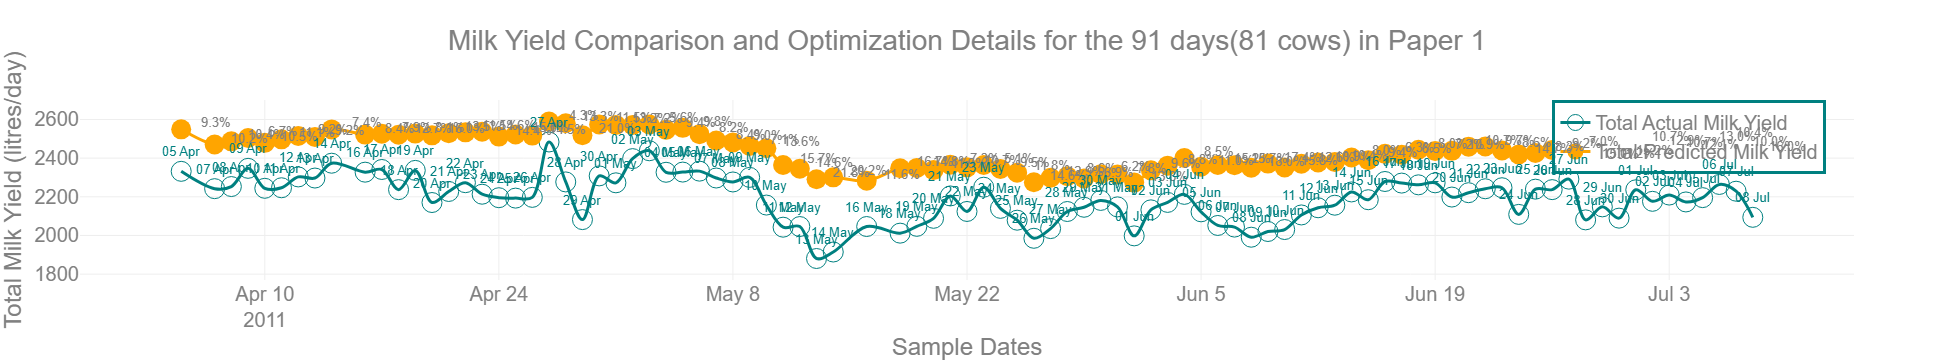

In [67]:
import pandas as pd
import plotly.graph_objects as go

# Load results from CSV
results_df = pd.read_csv('optimization_results_Elanco.csv')

# Convert 'Date' to datetime for proper plotting and sort by date
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.sort_values(by='Date', inplace=True)

# Define marker size
marker_size = 20

# Plotly figure
fig = go.Figure()

# Adding actual milk yield as smooth scatter plot
fig.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Total Actual Milk Yield'],
                         mode='lines+markers',
                         name='Total Actual Milk Yield',
                         line=dict(color='teal', shape='spline'),
                         marker=dict(size=marker_size, symbol = "circle-open")))

# Adding predicted milk yield as smooth scatter plot
fig.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Total Predicted Milk Yield'],
                         mode='lines+markers',
                         name='Total Predicted Milk Yield',
                         line=dict(color='orange', shape='spline'),
                         marker=dict(size=marker_size, symbol = "circle")))

# Update layout using a presentation template and custom settings
fig.update_layout(template='presentation',
                  title='Milk Yield Comparison and Optimization Details for the 91 days(81 cows) in Paper 1',
                  xaxis_title='Sample Dates',
                  yaxis_title='Total Milk Yield (litres/day)',
                  # legend_title='Legend',
                  font=dict(family="Arial, sans-serif", size=20, color='gray'),
                  autosize=True,
                  # width=1800,
                  height=1000,
                  legend=dict(x=0.83, y=1, bordercolor='teal', borderwidth=3))

# Add annotations for percentage increase and date labels
annotation_font_size = 13
for i in range(len(results_df)):
    # Annotate with percentage increase
    fig.add_annotation(x=results_df['Date'][i], y=results_df['Total Predicted Milk Yield'][i],
                       text=f"{results_df['Percentage Increase in Milk Yield'][i]:.1f}%",
                       showarrow=False, yshift=7, xshift= 35, font=dict(size=annotation_font_size, color="gray"))

    # Annotate with date (day and month)
    date_str = results_df['Date'][i].strftime("%d %b")  # Format date as 'day month'
    fig.add_annotation(x=results_df['Date'][i], y=results_df['Total Actual Milk Yield'][i],
                       text=date_str,
                       showarrow=False, yshift=20, font=dict(size=annotation_font_size, color="teal"))

# Show figure
fig.show()


In [68]:
results_df["Percentage Increase in Milk Yield"].mean()

11.213848757419797

### Optimisation using OR-Tools

In [ ]:
# !pip install ortools

In [166]:
import pandas as pd

# Sample code to load your dataframe and scaler
# df_81cows_91days = pd.read_csv('your_file.csv')
# scaler_x = joblib.load('scaler_x.pkl')

# 1. Sort the DataFrame based on 'smp_date'
df_81cows_91days.sort_values('smp_date', inplace=True)
print(df_81cows_91days.shape)

# 2. Get the unique dates and select the first 2 days
unique_days = df_81cows_91days['smp_date'].unique()
first_2_days = unique_days[:2]

# 3. Filter the DataFrame
filtered_df = df_81cows_91days[df_81cows_91days['smp_date'].isin(first_2_days)]

# Show the result
print(filtered_df.shape)

# Define process_data function
def process_data(dataframe):
    # Keep the original 'id', 'dim', 'lact', 'my', 'lw', and 'conc' for later use
    original_data = dataframe[['id', 'dim', 'lact', 'my', 'lw', 'conc']]

    # Process the data
    dataframe['lact'] = dataframe['lact'].astype('object')
    df_predictors = dataframe.drop(['smp_date', 'id', 'my'], axis=1)
    X_test_num_sub = df_predictors.select_dtypes(include=['int64', 'float64'])
    X_test_cat_sub = df_predictors.select_dtypes(include=['object'])
    X_test_cat_sub = pd.get_dummies(X_test_cat_sub, columns=['lact']).astype(int)
    X_test_num_subscaled = pd.DataFrame(scaler_x.transform(X_test_num_sub), 
                                        columns=X_test_num_sub.columns, 
                                        index=X_test_num_sub.index)
    X_test_subtransformed = pd.concat([X_test_cat_sub, X_test_num_subscaled], axis=1)
    processed_data_per_day = X_test_subtransformed.to_numpy()
    
    return original_data, processed_data_per_day

# Define process_all_data_by_day function
def process_all_data_by_day(filtered_df):
    processed_data_list = []
    for day in filtered_df['smp_date'].unique():
        df_day = filtered_df[filtered_df['smp_date'] == day]
        original_data, processed_data = process_data(df_day)
        for i in range(len(original_data)):
            row = original_data.iloc[i].tolist() + [processed_data[i]]
            processed_data_list.append([day] + row)
    return processed_data_list

# Applying the function
processed_data_list = process_all_data_by_day(filtered_df)

# Creating a DataFrame from the list
columns = ['smp_date', 'id', 'dim', 'actual_lact', 'actual_my', 'lw', 'actual_conc', 'ProcessedData']
combined_processed_df = pd.DataFrame(processed_data_list, columns=columns)

# Display the DataFrame
combined_processed_df

(7371, 7)
(162, 7)


smp_date     id  dim  actual_lact  actual_my   lw  actual_conc  \
0   2011-04-05  C1014   44            3       32.7  624            8   
1   2011-04-05  C6849   54            4       35.0  634            9   
2   2011-04-05  C6828  126            4       33.0  638            8   
3   2011-04-05  C6817  144            4       28.7  650            8   
4   2011-04-05  C6706  139            4       32.6  675            9   
..         ...    ...  ...          ...        ...  ...          ...   
157 2011-04-07  C1189  214            1       14.1  507            8   
158 2011-04-07  C1175  210            1       24.4  484            8   
159 2011-04-07  C1169   50            1       28.1  558            8   
160 2011-04-07  C1144   52            2       29.7  486            8   
161 2011-04-07  C1207   44            1       23.6  457            8   

                                         ProcessedData  
0    [0.0, 0.0, 1.0, 0.0, -1.4866217176725547, 0.49...  
1    [0.0, 0.0, 0.0, 1.0, -1.3615008680043694, 0.62...  
2    [0.0, 0.0, 0.0, 1.0, -0.4606307503934347, 0.68...  
3    [0.0, 0.0, 0.0, 1.0, -0.23541322099070106, 0.8...  
4    [0.0, 0.0, 0.0, 1.0, -0.29797364582479374, 1.1...  
..                                                 ...  
157  [1.0, 0.0, 0.0, 0.0, 0.6404327266865965, -1.06...  
158  [1.0, 0.0, 0.0, 0.0, 0.5903843868193224, -1.37...  
159  [1.0, 0.0, 0.0, 0.0, -1.4115492078716436, -0.3...  
160  [0.0, 1.0, 0.0, 0.0, -1.3865250379380065, -1.3...  
161  [1.0, 0.0, 0.0, 0.0, -1.4866217176725547, -1.7...  

[162 rows x 8 columns]

In [167]:
import numpy as np
import time
import joblib
import pandas as pd
from ortools.linear_solver import pywraplp

# Load the model
# best_random_forest_model_X_with_id_label_with_concentrate_nw_5_Fold = joblib.load('best_random_forest_model_X_with_id_label_with_concentrate_nw_5_Fold.joblib')

# Define functions for model predictions and optimization
def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    # Adjust the concentration level
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    # Reshape the data to 2D array as it contains a single sample
    return modified_row.reshape(1, -1)

def solve_knapsack_or_tools(predictions, total_concentrate):
    # Ensure total_concentrate is a float
    total_concentrate = float(total_concentrate)
    # Create the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return None

    # Variables
    x = {}
    for cow_id in predictions:
        for conc in predictions[cow_id]['predictions']:
            x[(cow_id, conc)] = solver.BoolVar(f'x_{cow_id}_{conc}')

    # Objective: Maximize total predicted milk yield
    objective = solver.Objective()
    for cow_id, cow_data in predictions.items():
        for conc, predicted_yield in cow_data['predictions'].items():
            objective.SetCoefficient(x[(cow_id, conc)], predicted_yield)
    objective.SetMaximization()

    # Constraint: Total concentrate usage
    total_conc_constraint = solver.Constraint(0, total_concentrate)
    for cow_id, cow_data in predictions.items():
        for conc, _ in cow_data['predictions'].items():
            total_conc_constraint.SetCoefficient(x[(cow_id, conc)], conc)

    # Constraint: One concentrate level per cow
    for cow_id in predictions:
        solver.Add(sum(x[(cow_id, conc)] for conc in predictions[cow_id]['predictions']) == 1)

    # Solve the problem
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        solution = {cow_id: next(conc for conc in predictions[cow_id]['predictions'] if x[(cow_id, conc)].solution_value() == 1) for cow_id in predictions}
        total_predicted_yield = sum(predictions[cow_id]['predictions'][solution[cow_id]] for cow_id in solution)
        total_optimal_concentrate = sum(solution.values())
        return solution, total_predicted_yield, total_optimal_concentrate
    else:
        print("No solution found.")
        return None


# Main data processing loop
results = []
individual_cow_data = {}

for date in combined_processed_df['smp_date'].unique():
    start_time = time.time()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]

    number_of_cows = len(daily_df['id'].unique())
    predictions_for_cows, total_concentrate, total_actual_yield = {}, 0, 0
    response_rates = []

    for cow_id in daily_df['id'].unique():
        cow_data = daily_df[daily_df['id'] == cow_id]
        actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
        processed_row = cow_data['ProcessedData'].iloc[0]  # Get the processed data

        total_concentrate += actual_conc
        total_actual_yield += actual_yield

        conc_levels = [actual_conc + delta for delta in np.arange(-1, 1.5, 0.5)]
        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}

        for conc in conc_levels:
            modified_row = take_predictors(processed_row, conc, scaler_x)
            predicted_yield = loaded_model.predict(modified_row)[0]
            # Apply inverse transformation to the prediction
            predicted_yield = scaler_y.inverse_transform([[predicted_yield]])[0, 0]
            predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

    optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack_or_tools(predictions_for_cows, total_concentrate)

    for cow_id in daily_df['id'].unique():
        optimal_conc = optimal_allocation[cow_id]
        predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_conc]
        actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
        actual_yield = predictions_for_cows[cow_id]['actual_yield']
    
        individual_cow_data.setdefault(date, {})[cow_id] = {
            'Predicted Milk Yield': predicted_yield,
            'Optimal Concentrate': optimal_conc,
            'Actual Concentrate': actual_concentrate,
            'Actual Milk Yield': actual_yield
        }



        if optimal_concentrate != actual_concentrate:  # Avoid division by zero
            response_rate = (predicted_yield - actual_yield) / (optimal_concentrate - actual_concentrate)
            response_rates.append(response_rate)

    max_response_rate = max(response_rates, default=None)
    min_response_rate = min(response_rates, default=None)
    percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

    results.append({
        'Date': date,
        'Number of Cows': number_of_cows,
        'Total Actual Concentrate': total_concentrate,
        'Total Actual Milk Yield': total_actual_yield,
        'Total Predicted Milk Yield': total_predicted_yield,
        'Total Optimal Concentrate': total_optimal_concentrate,
        'Percentage Increase in Milk Yield': percentage_increase,
        'Max Response Rate': max_response_rate,
        'Min Response Rate': min_response_rate,
        'Optimization Time': time.time() - start_time
    })

# Output results
results_df_tools = pd.DataFrame(results)
results_df_tools.to_csv('optimization_results_Elanco_tools.csv', index=False)
results_df_tools

Date  Number of Cows  Total Actual Concentrate  \
0 2011-04-05              81                       659   
1 2011-04-07              81                       657   

   Total Actual Milk Yield  Total Predicted Milk Yield  \
0                   2331.8                 2573.886638   
1                   2242.2                 2510.018994   

   Total Optimal Concentrate  Percentage Increase in Milk Yield  \
0                      659.0                          10.381964   
1                      657.0                          11.944474   

   Max Response Rate  Min Response Rate  Optimization Time  
0           0.787146          -0.183707           6.363430  
1           0.599824          -0.135356           5.921448

### Optimisation using Pyomo

In [149]:
# !pip install pyomo
# For IPOPT, follow installation instructions from https://www.coin-or.org/download/source/Ipopt/


In [184]:
import numpy as np
import pandas as pd
import joblib
import pyomo.environ as pyo
import time

# # Load your model, scaler, and data
# loaded_model = joblib.load('your_model_file.joblib')
# scaler_x = joblib.load('scaler_x.pkl')
# scaler_y = joblib.load('scaler_y.pkl')
# combined_processed_df = pd.read_csv('your_data.csv')

def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    return modified_row.reshape(1, -1)

def get_predicted_yield(processed_row, conc, model, scaler_x, scaler_y):
    modified_row = take_predictors(processed_row, conc, scaler_x)
    predicted_yield = model.predict(modified_row)[0]
    return scaler_y.inverse_transform([[predicted_yield]])[0][0]

def solve_knapsack_pyomo(predictions, total_actual_concentrate):
    model = pyo.ConcreteModel()

    COWS = set(predictions.keys())
    CONCENTRATIONS = {cow: list(predictions[cow]['predictions'].keys()) for cow in COWS}
    model.x = pyo.Var([(cow, conc) for cow in COWS for conc in CONCENTRATIONS[cow]], domain=pyo.Binary)

    def objective_rule(m):
        return sum(m.x[cow, conc] * predictions[cow]['predictions'][conc] for cow in COWS for conc in CONCENTRATIONS[cow])
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    # Constraint: Total optimal concentrate must equal total actual concentrate
    def total_concentrate_rule(m):
        return sum(m.x[cow, conc] * conc for cow in COWS for conc in CONCENTRATIONS[cow]) == total_actual_concentrate
    model.total_concentrate_constraint = pyo.Constraint(rule=total_concentrate_rule)

    # Constraint: Each cow is assigned exactly one concentrate level
    def one_conc_rule(m, cow):
        return sum(m.x[cow, conc] for conc in CONCENTRATIONS[cow]) == 1
    model.one_conc_constraint = pyo.Constraint(COWS, rule=one_conc_rule)

    solver = pyo.SolverFactory('ipopt', executable="C:\\Ipopt\\bin\\ipopt.exe")
    result = solver.solve(model)

    if (result.solver.status == pyo.SolverStatus.ok) and (result.solver.termination_condition == pyo.TerminationCondition.optimal):
        solution = {}
        for cow in COWS:
            selected_concs = [conc for conc in CONCENTRATIONS[cow] if pyo.value(model.x[cow, conc]) == 1]
            solution[cow] = selected_concs[0] if selected_concs else None

        # Ensure that the total optimal concentrate equals the total actual concentrate
        total_optimal_concentrate = sum(solution[cow] for cow in solution if solution[cow] is not None)
        if total_optimal_concentrate != total_actual_concentrate:
            print("Total optimal concentrate does not match total actual concentrate.")
            return None, None, None

        total_predicted_yield = sum(predictions[cow]['predictions'][solution[cow]] for cow in solution if solution[cow] is not None)
        return solution, total_predicted_yield, total_optimal_concentrate
    else:
        print("No optimal solution found.")
        return None, None, None

results = []

for date in combined_processed_df['smp_date'].unique():
    start_time = time.time()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]
    total_actual_concentrate = daily_df['actual_conc'].sum()
    total_actual_yield = daily_df['actual_my'].sum()
    number_of_cows = len(daily_df['id'].unique())

    predictions_for_cows = {}
    for cow_id in daily_df['id'].unique():
        cow_data = daily_df[daily_df['id'] == cow_id]
        actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
        processed_row = cow_data['ProcessedData'].iloc[0]

        conc_levels = np.clip([actual_conc - 2, actual_conc, actual_conc + 2], a_min=0, a_max=None)  # Ensure concentration is at least 0
        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}
        for conc in conc_levels:
            predicted_yield = get_predicted_yield(processed_row, conc, loaded_model, scaler_x, scaler_y)
            predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

    optimal_allocation, total_predicted_yield, total_optimal_concentrate = solve_knapsack_pyomo(predictions_for_cows, total_actual_concentrate)

    response_rates = []
    for cow_id in daily_df['id'].unique():
        if optimal_allocation and optimal_allocation.get(cow_id) is not None:
            optimal_conc = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_conc]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']

            if optimal_conc != actual_concentrate:
                response_rate = (predicted_yield - actual_yield) / (optimal_conc - actual_concentrate) if optimal_conc != actual_concentrate else 0
                response_rates.append(response_rate)

    max_response_rate = max(response_rates, default=None)
    min_response_rate = min(response_rates, default=None)
    percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

    results.append({
        'Date': date,
        'Number of Cows': number_of_cows,
        'Total Actual Concentrate': total_actual_concentrate,
        'Total Actual Milk Yield': total_actual_yield,
        'Total Predicted Milk Yield': total_predicted_yield,
        'Total Optimal Concentrate': total_optimal_concentrate,
        'Percentage Increase in Milk Yield': percentage_increase,
        'Max Response Rate': max_response_rate,
        'Min Response Rate': min_response_rate,
        'Optimization Time': time.time() - start_time
    })

results_df_pyomo = pd.DataFrame(results)
results_df_pyomo.to_csv('optimization_results_pyomo.csv', index=False)
print(results_df_pyomo)


Total optimal concentrate does not match total actual concentrate.


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [180]:
import numpy as np
import pandas as pd
import joblib
import pyomo.environ as pyo
import time

# # Load your model, scaler, and data
# loaded_model = joblib.load('your_model_file.joblib')
# scaler_x = joblib.load('scaler_x.pkl')
# scaler_y = joblib.load('scaler_y.pkl')
# combined_processed_df = pd.read_csv('your_data.csv')

def take_predictors(processed_row, new_conc, scaler_x):
    modified_row = np.copy(processed_row)
    modified_row[-1] = (new_conc - scaler_x.mean_[-1]) / scaler_x.scale_[-1]
    return modified_row.reshape(1, -1)

def get_predicted_yield(processed_row, conc, model, scaler_x, scaler_y):
    modified_row = take_predictors(processed_row, conc, scaler_x)
    predicted_yield = model.predict(modified_row)[0]
    return scaler_y.inverse_transform([[predicted_yield]])[0][0]

def solve_knapsack_pyomo(predictions, total_actual_concentrate):
    model = pyo.ConcreteModel()

    COWS = set(predictions.keys())
    CONCENTRATIONS = {cow: list(predictions[cow]['predictions'].keys()) for cow in COWS}

    model.x = pyo.Var([(cow, conc) for cow in COWS for conc in CONCENTRATIONS[cow]], domain=pyo.Binary)

    def objective_rule(m):
        return sum(m.x[cow, conc] * predictions[cow]['predictions'][conc] for cow in COWS for conc in CONCENTRATIONS[cow])
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    def total_concentrate_rule(m):
        return sum(m.x[cow, conc] * conc for cow in COWS for conc in CONCENTRATIONS[cow]) == total_actual_concentrate
    model.total_concentrate_constraint = pyo.Constraint(rule=total_concentrate_rule)

    def one_conc_rule(m, cow):
        return sum(m.x[cow, conc] for conc in CONCENTRATIONS[cow]) == 1
    model.one_conc_constraint = pyo.Constraint(COWS, rule=one_conc_rule)

    solver = pyo.SolverFactory('ipopt', executable="C:\\Ipopt\\bin\\ipopt.exe")
    result = solver.solve(model)

    if (result.solver.status == pyo.SolverStatus.ok) and (result.solver.termination_condition == pyo.TerminationCondition.optimal):
        solution = {}
        for cow in COWS:
            selected_concs = [conc for conc in CONCENTRATIONS[cow] if pyo.value(model.x[cow, conc]) == 1]
            solution[cow] = selected_concs[0] if selected_concs else None

        total_predicted_yield = sum(predictions[cow]['predictions'][solution[cow]] for cow in COWS if solution[cow] is not None)
        return solution, total_predicted_yield
    else:
        print("No optimal solution found.")
        return None, None

results = []

for date in combined_processed_df['smp_date'].unique():
    start_time = time.time()
    daily_df = combined_processed_df[combined_processed_df['smp_date'] == date]
    total_actual_concentrate = daily_df['actual_conc'].sum()
    total_actual_yield = daily_df['actual_my'].sum()
    number_of_cows = len(daily_df['id'].unique())

    predictions_for_cows = {}
    for cow_id in daily_df['id'].unique():
        cow_data = daily_df[daily_df['id'] == cow_id]
        actual_conc, actual_yield = cow_data['actual_conc'].iloc[0], cow_data['actual_my'].iloc[0]
        processed_row = cow_data['ProcessedData'].iloc[0]

        conc_levels = np.clip([actual_conc - 2, actual_conc, actual_conc + 2], a_min=0, a_max=None)  # Ensure concentration is at least 0
        predictions_for_cows[cow_id] = {'actual_conc': actual_conc, 'actual_yield': actual_yield, 'predictions': {}}
        for conc in conc_levels:
            predicted_yield = get_predicted_yield(processed_row, conc, loaded_model, scaler_x, scaler_y)
            predictions_for_cows[cow_id]['predictions'][conc] = predicted_yield

    optimal_allocation, total_predicted_yield = solve_knapsack_pyomo(predictions_for_cows, total_actual_concentrate)

    response_rates = []
    total_optimal_concentrate = 0
    for cow_id in daily_df['id'].unique():
        if optimal_allocation and optimal_allocation.get(cow_id) is not None:
            optimal_conc = optimal_allocation[cow_id]
            predicted_yield = predictions_for_cows[cow_id]['predictions'][optimal_conc]
            actual_concentrate = predictions_for_cows[cow_id]['actual_conc']
            actual_yield = predictions_for_cows[cow_id]['actual_yield']
            total_optimal_concentrate += optimal_conc

            if optimal_conc != actual_concentrate:
                response_rate = (predicted_yield - actual_yield) / (optimal_conc - actual_concentrate) if optimal_conc != actual_concentrate else 0
                response_rates.append(response_rate)

    max_response_rate = max(response_rates, default=None)
    min_response_rate = min(response_rates, default=None)
    percentage_increase = ((total_predicted_yield - total_actual_yield) / total_actual_yield) * 100 if total_actual_yield > 0 else 0

    results.append({
        'Date': date,
        'Number of Cows': number_of_cows,
        'Total Actual Concentrate': total_actual_concentrate,
        'Total Actual Milk Yield': total_actual_yield,
        'Total Predicted Milk Yield': total_predicted_yield,
        'Total Optimal Concentrate': total_optimal_concentrate,
        'Percentage Increase in Milk Yield': percentage_increase,
        'Max Response Rate': max_response_rate,
        'Min Response Rate': min_response_rate,
        'Optimization Time': time.time() - start_time
    })

results_df_pyomo = pd.DataFrame(results)
results_df_pyomo.to_csv('optimization_results_pyomo.csv', index=False)
print(results_df_pyomo)

        Date  Number of Cows  Total Actual Concentrate  \
0 2011-04-05              81                       659   
1 2011-04-07              81                       657   

   Total Actual Milk Yield  Total Predicted Milk Yield  \
0                   2331.8                 2569.662953   
1                   2242.2                 2533.199429   

   Total Optimal Concentrate  Percentage Increase in Milk Yield  \
0                        611                          10.200830   
1                        611                          12.978299   

   Max Response Rate  Min Response Rate  Optimization Time  
0          10.354500          -7.897917           3.971381  
1           9.887667          -2.244417           3.380757  
